## IMPORTS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import networkx as nx
import os

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind
from matplotlib_venn import venn3

## INFO DEMOGRÀFICA

In [ ]:
path = "data/subject_clinical_data (Marti).xlsx"
clinical_data = pd.read_excel(path)

In [ ]:
clinical_data

id  mstype  edss    age  genre
0      0       0   3.0  60.78      1
1      1       0   1.5  37.95      0
2      2       0   2.0  52.64      0
3      3       0   3.0  53.86      1
4      4       0   2.0  43.65      0
..   ...     ...   ...    ...    ...
138  138      -1   0.0  32.98      1
139  139      -1   0.0  23.76      0
140  140      -1   0.0  24.11      0
141  141      -1   0.0  23.98      0
142  142      -1   0.0  23.46      0

[143 rows x 5 columns]

In [ ]:
clinical_data_HV = clinical_data[clinical_data['mstype']==-1]
clinical_data_PwMS = clinical_data[clinical_data['mstype']==0]

In [ ]:
print(clinical_data_HV['age'].mean())
print(clinical_data_HV['age'].std())

36.61790630466195
9.602638728027937


In [ ]:
print(clinical_data_PwMS['age'].mean())
print(clinical_data_PwMS['age'].std())

45.6648
9.482759109171793


In [ ]:
print(clinical_data_HV['genre'].value_counts()[0])
print(clinical_data_HV['genre'].value_counts()[1])

15
3


In [ ]:
print(clinical_data_PwMS['genre'].value_counts()[0])
print(clinical_data_PwMS['genre'].value_counts()[1])

90
35


In [ ]:
print(clinical_data_PwMS['edss'].mean())
print(clinical_data_PwMS['edss'].std())

2.112
1.0996040343041964


## LOAD DATA

In [5]:
data_directory = ""

Load target variables

In [6]:
path = data_directory+"data/subject_clinical_data.xlsx"
clinical_data = pd.read_excel(path)
clinical_data = clinical_data.drop(columns=["id"])

Load brain networks

In [7]:
brain_networks = np.empty((clinical_data.shape[0], 3, 76, 76))

def getFileName(i):
    name = str(i)
    while len(name) < 4:
        name = "0"+name
    name = name+".csv"
    return name

for i in range(clinical_data.shape[0]):
    file_name = getFileName(i)
    fa = pd.read_csv(data_directory+"data/FA/"+file_name, header=None)
    brain_networks[i,0,:,:] = np.array(fa)
    gm = pd.read_csv(data_directory+"data/GM/"+file_name, header=None)
    brain_networks[i,1,:,:] = np.array(gm)
    rs = pd.read_csv(data_directory+"data/RS/"+file_name, header=None)
    brain_networks[i,2,:,:] = np.array(rs)

Load node names

In [8]:
node_names = pd.read_csv(data_directory+"data/nodes.csv", index_col=0)
node_names = node_names.drop(columns='region_id')

Constants

In [9]:
NUM_NODES = 76
NUM_ARESTES = int((NUM_NODES*(NUM_NODES-1))/2)
NUM_SUBJECTS = clinical_data.shape[0]

## DATA ANALYSIS

### Exploració de clinical data

In [10]:
print("Shape: ", clinical_data.shape)
clinical_data

Shape:  (143, 2)


mstype  edss
0         0   3.0
1         0   1.5
2         0   2.0
3         0   3.0
4         0   2.0
..      ...   ...
138      -1   0.0
139      -1   0.0
140      -1   0.0
141      -1   0.0
142      -1   0.0

[143 rows x 2 columns]

In [11]:
clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mstype  143 non-null    int64  
 1   edss    143 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.4 KB


In [12]:
clinical_data.describe()

mstype        edss
count  143.000000  143.000000
mean    -0.125874    1.846154
std      0.332873    1.245033
min     -1.000000    0.000000
25%      0.000000    1.000000
50%      0.000000    1.500000
75%      0.000000    2.500000
max      0.000000    6.000000

<Axes: xlabel='edss', ylabel='Count'>

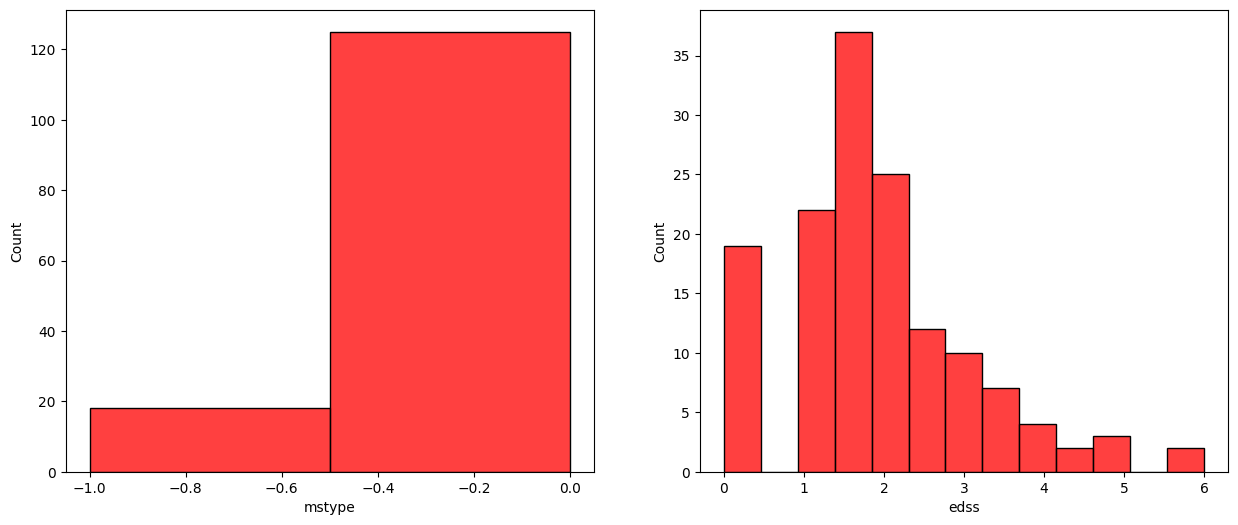

In [13]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.histplot(x=clinical_data['mstype'], color ='red', ax=axes[0],bins=2)
sns.histplot(x=clinical_data['edss'], color ='red', ax=axes[1],bins=13)

In [14]:
print(clinical_data['mstype'].value_counts(), "\n")
print(clinical_data['edss'].value_counts())

mstype
 0    125
-1     18
Name: count, dtype: int64 

edss
1.5    37
2.0    25
1.0    22
0.0    19
2.5    12
3.0    10
3.5     7
4.0     4
5.0     3
6.0     2
4.5     2
Name: count, dtype: int64


In [15]:
print(clinical_data[clinical_data['edss']==0])

     mstype  edss
32        0   0.0
73       -1   0.0
74       -1   0.0
75       -1   0.0
76       -1   0.0
77       -1   0.0
78       -1   0.0
79       -1   0.0
80       -1   0.0
81       -1   0.0
82       -1   0.0
135      -1   0.0
136      -1   0.0
137      -1   0.0
138      -1   0.0
139      -1   0.0
140      -1   0.0
141      -1   0.0
142      -1   0.0


### Exploració de les xarxes cerebrals

In [16]:
print("Número de subjectes: ", brain_networks.shape[0])
print("Mida de les xarxes: ", brain_networks.shape[2:])

Número de subjectes:  143
Mida de les xarxes:  (76, 76)


#### Xarxes FA

In [17]:
fa = brain_networks[:,0,:,:]

fa_values = fa.flatten()
print(fa_values)
print(fa_values.shape)

[0.         0.43570114 0.         ... 0.4248559  0.39936464 0.        ]
(825968,)


In [18]:
pd.DataFrame(fa_values).describe()

0
count  825968.000000
mean        0.236047
std         0.207528
min         0.000000
25%         0.000000
50%         0.319193
75%         0.422540
max         0.867121

[Text(0.5, 1.0, 'Histograma de valors de les matrius FA')]

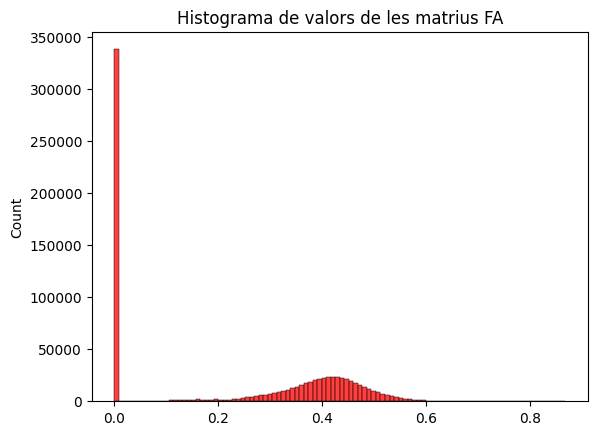

In [19]:
sns.histplot(x=fa_values, color ='red', bins=100).set(title='Histograma de valors de les matrius FA')

In [20]:
print("Nombre d'arestes que son 0: ", np.count_nonzero(fa_values == 0))

Nombre d'arestes que son 0:  337944


[Text(0.5, 1.0, 'Histograma de valors de les matrius FA sense contar els 0')]

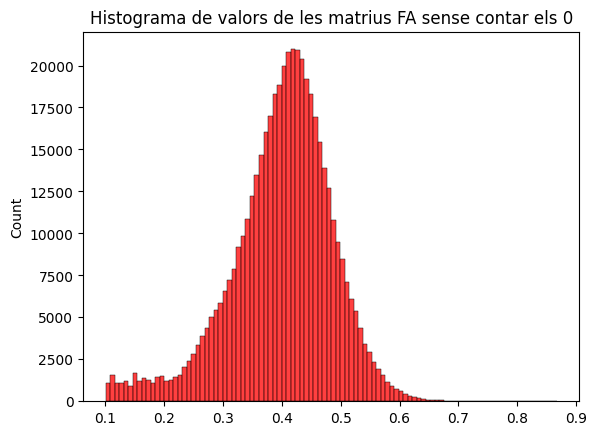

In [21]:
fa_values_non_zero = fa_values[np.nonzero(fa_values > 0)[0]]

sns.histplot(x=fa_values_non_zero, color ='red', bins=100).set(title='Histograma de valors de les matrius FA sense contar els 0')

#### Xarxes GM

In [22]:
gm = brain_networks[:,1,:,:]

gm_values = gm.flatten()
print(gm_values)
print(gm_values.shape)

[0.         0.01977221 0.01685782 ... 0.16536942 0.03532892 0.        ]
(825968,)


In [23]:
pd.DataFrame(gm_values).describe()

0
count  825968.000000
mean        0.069399
std         0.087333
min         0.000000
25%         0.018075
50%         0.039771
75%         0.083131
max         1.000000

[Text(0.5, 1.0, 'Histograma de valors de les matrius GM')]

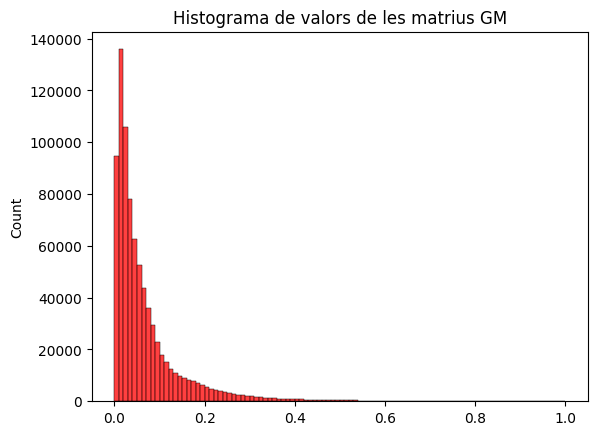

In [24]:
sns.histplot(x=gm_values, color ='red', bins=100).set(title='Histograma de valors de les matrius GM')

In [25]:
print("Nombre d'arestes que son 0: ", np.count_nonzero(gm_values == 0))

Nombre d'arestes que son 0:  10946


[Text(0.5, 1.0, 'Histograma de valors de les matrius GM sense contar els 0')]

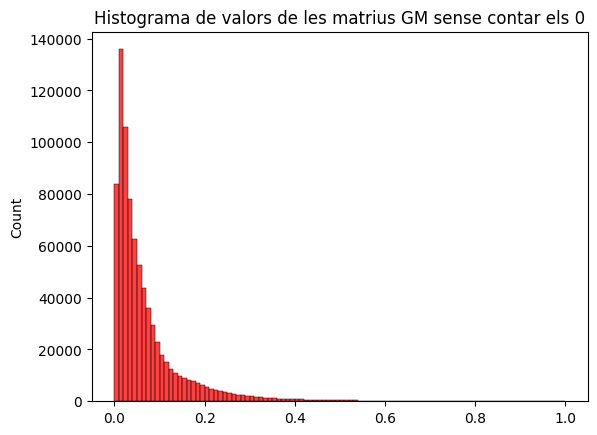

In [26]:
gm_values_non_zero = gm_values[np.nonzero(gm_values > 0)[0]]

sns.histplot(x=gm_values_non_zero, color ='red', bins=100).set(title='Histograma de valors de les matrius GM sense contar els 0')

#### Xarxes RS

In [27]:
rs = brain_networks[:,2,:,:]

rs_values = rs.flatten()
print(rs_values)
print(rs_values.shape)

[0.         0.69056623 0.30572181 ... 0.66556017 0.5175166  0.        ]
(825968,)


In [28]:
pd.DataFrame(rs_values).describe()

0
count  825968.000000
mean        0.285672
std         0.206543
min         0.000000
25%         0.115738
50%         0.249507
75%         0.421852
max         1.000000

[Text(0.5, 1.0, 'Histograma de valors de les matrius RS')]

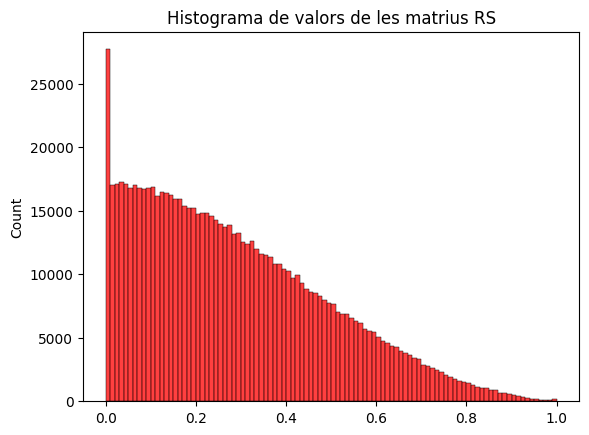

In [29]:
sns.histplot(x=rs_values, color ='red', bins=100).set(title='Histograma de valors de les matrius RS')

In [30]:
print("Nombre d'arestes que son 0: ", np.count_nonzero(rs_values == 0))

Nombre d'arestes que son 0:  10868


[Text(0.5, 1.0, 'Histograma de valors de les matrius RS sense contar els 0')]

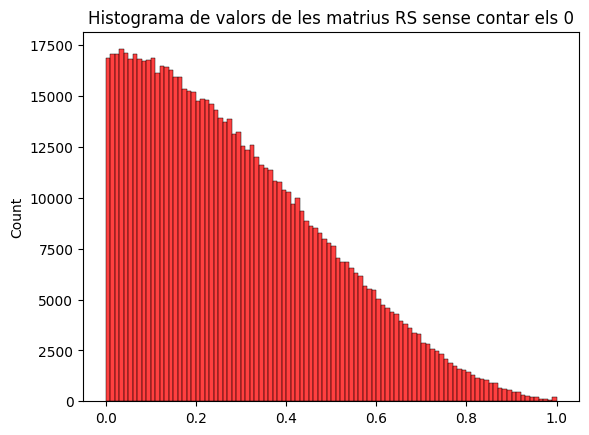

In [31]:
rs_values_non_zero = rs_values[np.nonzero(rs_values > 0)[0]]

sns.histplot(x=rs_values_non_zero, color ='red', bins=100).set(title='Histograma de valors de les matrius RS sense contar els 0')

### Anàlisi dels grups (Healthy Volunteers i People with MS)

In [32]:
HV_index = clinical_data['mstype'] == -1
PwMS_index = clinical_data['mstype'] == 0

#### Anàlisi a partir dels nodes

En aquest apartat es fa un anàlisi de què tan útil és cada node per distingir entre els grups HV i PwMS. Per fer-ho, s'utilitzarà el sumatori dels pesos de totes les arestes connectades a cada node, és a dir la mètrica strength.

In [33]:
def get_nodes_sum(mat):
    nodes_sum = np.empty((mat.shape[:2]))
    for i in range(nodes_sum.shape[0]):
        for j in range(nodes_sum.shape[1]):
            nodes_sum[i][j] = np.sum(mat[i][j])
    return nodes_sum

In [34]:
def get_p_values_nodes(HV_nodes_sum, PwMS_nodes_sum):
    p_values = np.array([])
    for i in range(NUM_NODES):
        _ , p_value = ttest_ind(HV_nodes_sum[:,i], PwMS_nodes_sum[:,i], equal_var=False)
        p_values = np.append(p_values, p_value)
    return p_values

##### Amb les xarxes FA:

In [35]:
# Matriu que per cada persona conté el strength de tots els nodes
fa_nodes_sum = get_nodes_sum(fa)

In [36]:
# Es separa entre HV i PwMS
HV_fa_nodes_sum = fa_nodes_sum[HV_index, :]
PwMS_fa_nodes_sum = fa_nodes_sum[PwMS_index, :]

print(HV_fa_nodes_sum.shape)
print(PwMS_fa_nodes_sum.shape)

(18, 76)
(125, 76)


Boxplots dels valors de strength per cada node:

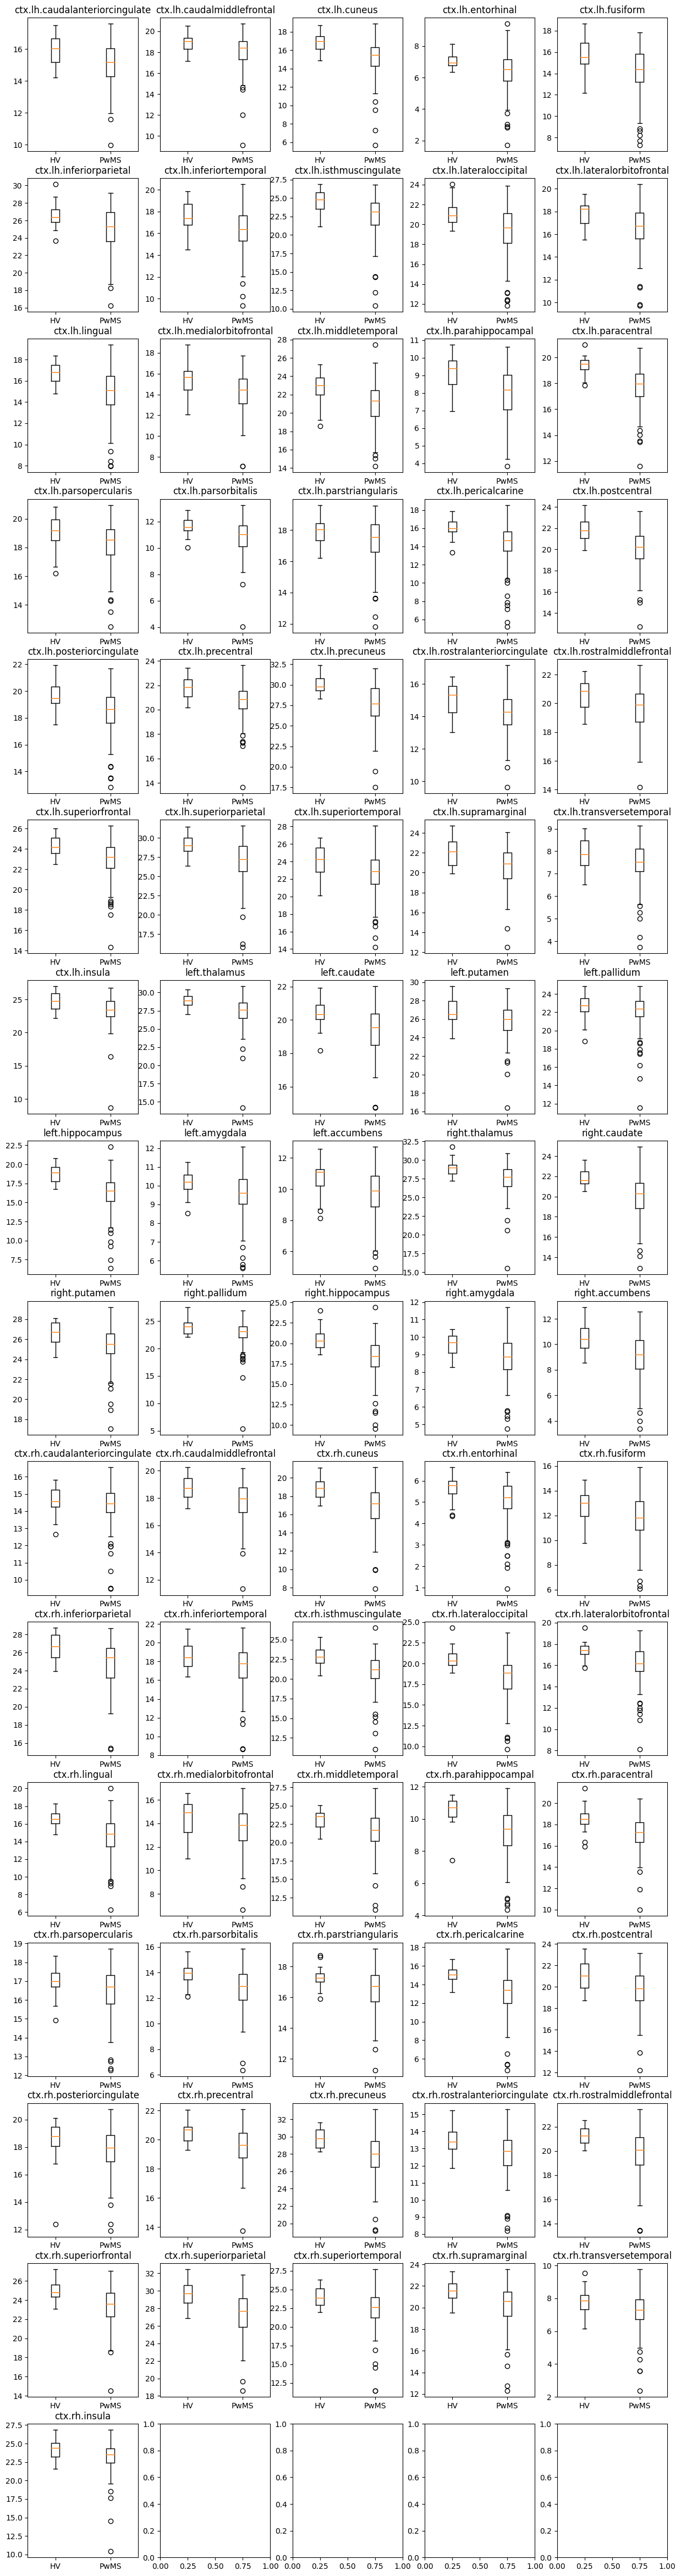

In [37]:
fig, axes = plt.subplots(16,5, figsize=(15,60))

for i in range(fa_nodes_sum.shape[1]):
    data = [HV_fa_nodes_sum[:,i], PwMS_fa_nodes_sum[:,i]]
    row = int(i/5)
    column = i%5
    axes[row, column].boxplot(data, labels=['HV', 'PwMS'])
    axes[row, column].set_title(node_names['region_name'][i])

A continuació, es comprova que la variancia de les mostres per cada node no té per què ser semblant.

In [38]:
print("            HV             PwMS")
print("----------------------------------")
for i in range(NUM_NODES):
    print("Node ", i, ": ", round(np.var(HV_fa_nodes_sum[:,i]),2), " -------- ", round(np.var(PwMS_fa_nodes_sum[:,i]),2))

            HV             PwMS
----------------------------------
Node  0 :  0.82  --------  1.67
Node  1 :  0.7  --------  2.56
Node  2 :  1.0  --------  4.14
Node  3 :  0.27  --------  1.47
Node  4 :  2.1  --------  5.11
Node  5 :  2.38  --------  6.13
Node  6 :  2.01  --------  3.73
Node  7 :  2.05  --------  6.93
Node  8 :  1.73  --------  6.19
Node  9 :  1.11  --------  3.44
Node  10 :  0.87  --------  4.89
Node  11 :  2.16  --------  3.43
Node  12 :  3.31  --------  4.92
Node  13 :  1.18  --------  1.97
Node  14 :  0.6  --------  2.35
Node  15 :  1.44  --------  2.22
Node  16 :  0.55  --------  1.71
Node  17 :  0.8  --------  1.97
Node  18 :  0.96  --------  5.55
Node  19 :  1.38  --------  3.19
Node  20 :  1.09  --------  2.56
Node  21 :  0.8  --------  1.84
Node  22 :  1.33  --------  5.46
Node  23 :  0.95  --------  1.7
Node  24 :  1.11  --------  2.29
Node  25 :  0.92  --------  3.65
Node  26 :  1.95  --------  7.7
Node  27 :  3.51  --------  5.12
Node  28 :  2.01  -------- 

Identifiquem tots els nodes que superen el t-test:

In [39]:
fa_nodes_p_values = get_p_values_nodes(HV_fa_nodes_sum, PwMS_fa_nodes_sum)

fa_nodes_t_test = np.where(fa_nodes_p_values<0.05)[0]
print("Número de nodes que superen el t-test: ", fa_nodes_t_test.shape[0], "\n")
node_indexs = np.argsort(fa_nodes_p_values)[:fa_nodes_t_test.shape[0]]
print(node_names['region_name'][node_indexs])

Número de nodes que superen el t-test:  73 

63          ctx.rh.pericalcarine
39                 right.caudate
14            ctx.lh.paracentral
35              left.hippocampus
22              ctx.lh.precuneus
                 ...            
75                 ctx.rh.insula
17       ctx.lh.parstriangularis
56    ctx.rh.medialorbitofrontal
60        ctx.rh.parsopercularis
15        ctx.lh.parsopercularis
Name: region_name, Length: 73, dtype: object


##### Amb les xarxes GM:

In [40]:
# Matriu que per cada persona conté el strength de tots els nodes
gm_nodes_sum = get_nodes_sum(gm)

In [41]:
# Es separa entre HV i PwMS
HV_gm_nodes_sum = gm_nodes_sum[HV_index, :]
PwMS_gm_nodes_sum = gm_nodes_sum[PwMS_index, :]

print(HV_gm_nodes_sum.shape)
print(PwMS_gm_nodes_sum.shape)

(18, 76)
(125, 76)


Boxplots dels valors de strength per cada node:

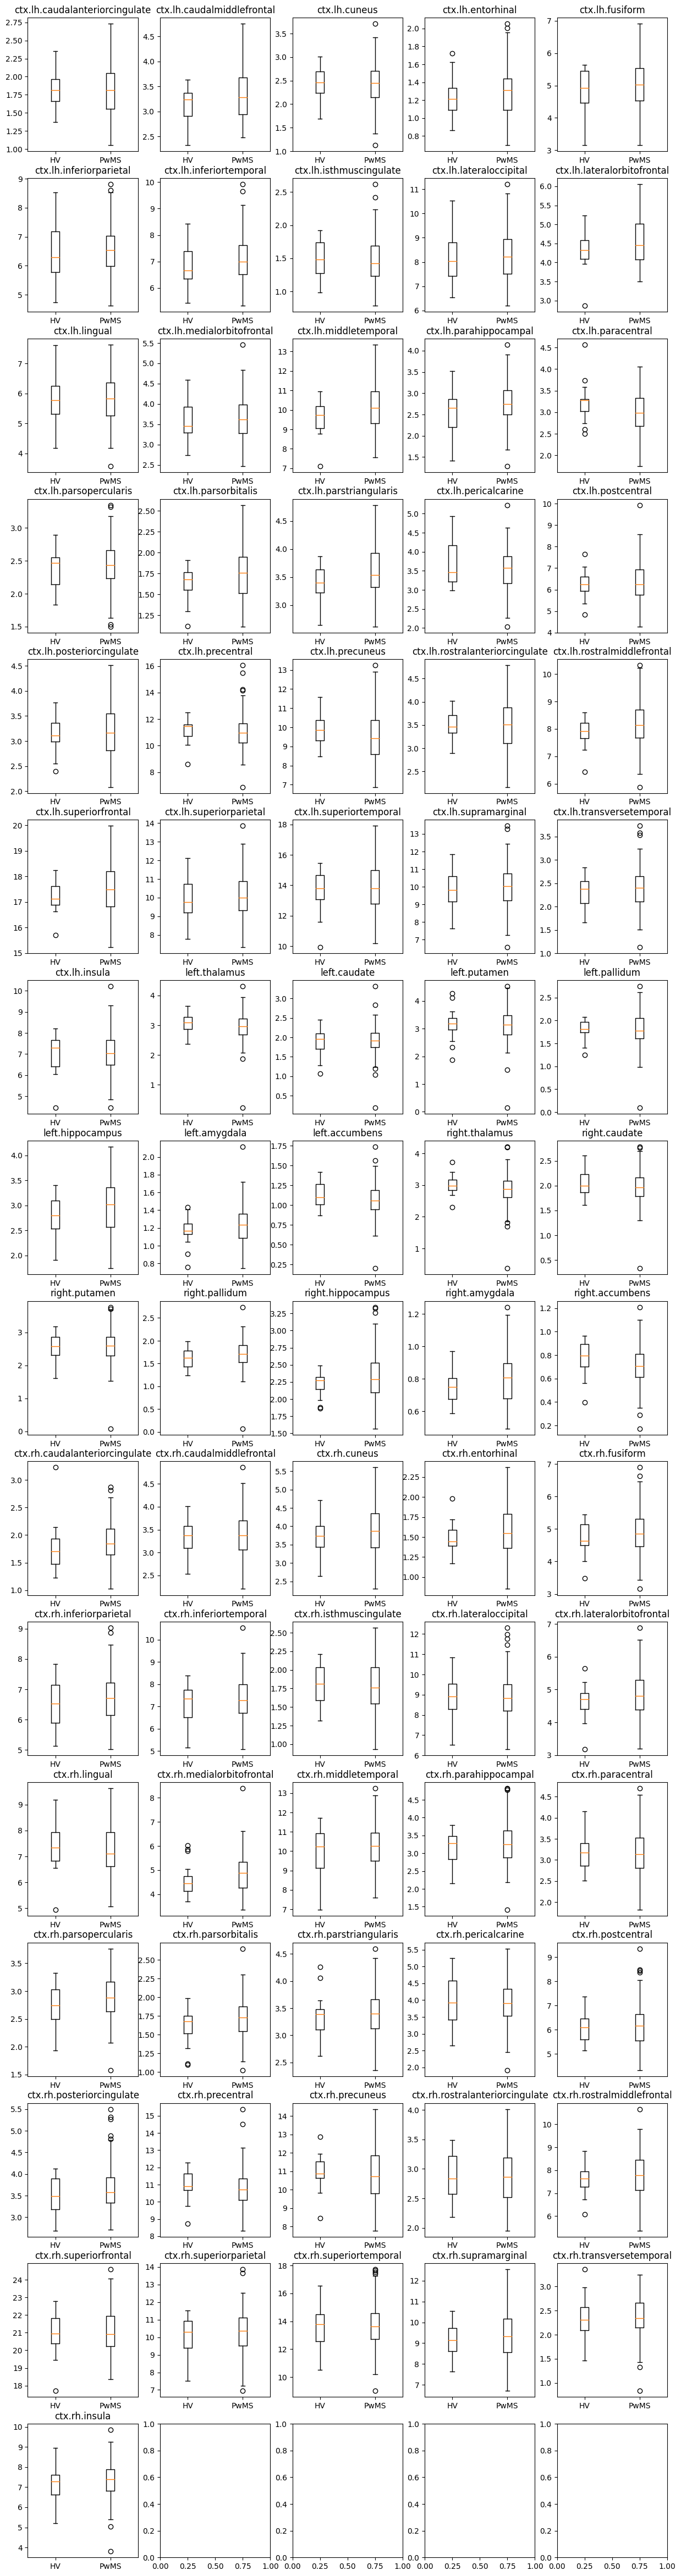

In [42]:
fig, axes = plt.subplots(16,5, figsize=(15,60))

for i in range(gm_nodes_sum.shape[1]):
    data = [HV_gm_nodes_sum[:,i], PwMS_gm_nodes_sum[:,i]]
    row = int(i/5)
    column = i%5
    axes[row, column].boxplot(data, labels=['HV', 'PwMS'])
    axes[row, column].set_title(node_names['region_name'][i])

A continuació, es comprova que la variancia de les mostres per cada node no té per què ser semblant.

In [43]:
print("            HV             PwMS")
print("----------------------------------")
for i in range(NUM_NODES):
    print("Node ", i, ": ", round(np.var(HV_gm_nodes_sum[:,i]),2), " -------- ", round(np.var(PwMS_gm_nodes_sum[:,i]),2))

            HV             PwMS
----------------------------------
Node  0 :  0.06  --------  0.12
Node  1 :  0.14  --------  0.26
Node  2 :  0.11  --------  0.21
Node  3 :  0.05  --------  0.07
Node  4 :  0.42  --------  0.49
Node  5 :  0.82  --------  0.67
Node  6 :  0.55  --------  0.84
Node  7 :  0.08  --------  0.11
Node  8 :  1.05  --------  0.95
Node  9 :  0.23  --------  0.35
Node  10 :  0.6  --------  0.63
Node  11 :  0.26  --------  0.29
Node  12 :  0.81  --------  1.35
Node  13 :  0.27  --------  0.23
Node  14 :  0.2  --------  0.2
Node  15 :  0.09  --------  0.13
Node  16 :  0.04  --------  0.09
Node  17 :  0.1  --------  0.21
Node  18 :  0.37  --------  0.29
Node  19 :  0.43  --------  0.9
Node  20 :  0.11  --------  0.27
Node  21 :  0.76  --------  1.72
Node  22 :  0.6  --------  1.58
Node  23 :  0.1  --------  0.3
Node  24 :  0.25  --------  0.71
Node  25 :  0.4  --------  0.99
Node  26 :  1.3  --------  1.45
Node  27 :  1.82  --------  2.47
Node  28 :  1.34  --------  1

Identifiquem tots els nodes que superen el t-test:

In [44]:
gm_nodes_p_values = get_p_values_nodes(HV_gm_nodes_sum, PwMS_gm_nodes_sum)

gm_nodes_t_test = np.where(gm_nodes_p_values<0.05)[0]
print("Número de nodes que superen el t-test: ", gm_nodes_t_test.shape[0], "\n")
node_indexs = np.argsort(gm_nodes_p_values)[:gm_nodes_t_test.shape[0]]
print(node_names['region_name'][node_indexs])

Número de nodes que superen el t-test:  5 

24    ctx.lh.rostralmiddlefrontal
17        ctx.lh.parstriangularis
42              right.hippocampus
43                 right.amygdala
35               left.hippocampus
Name: region_name, dtype: object


##### Amb les xarxes RS:

In [45]:
# Matriu que per cada persona conté el strength de tots els nodes
rs_nodes_sum = get_nodes_sum(rs)

In [46]:
# Es separa entre HV i PwMS
HV_rs_nodes_sum = rs_nodes_sum[HV_index, :]
PwMS_rs_nodes_sum = rs_nodes_sum[PwMS_index, :]

print(HV_rs_nodes_sum.shape)
print(PwMS_rs_nodes_sum.shape)

(18, 76)
(125, 76)


Boxplots dels valors de strength per cada node:

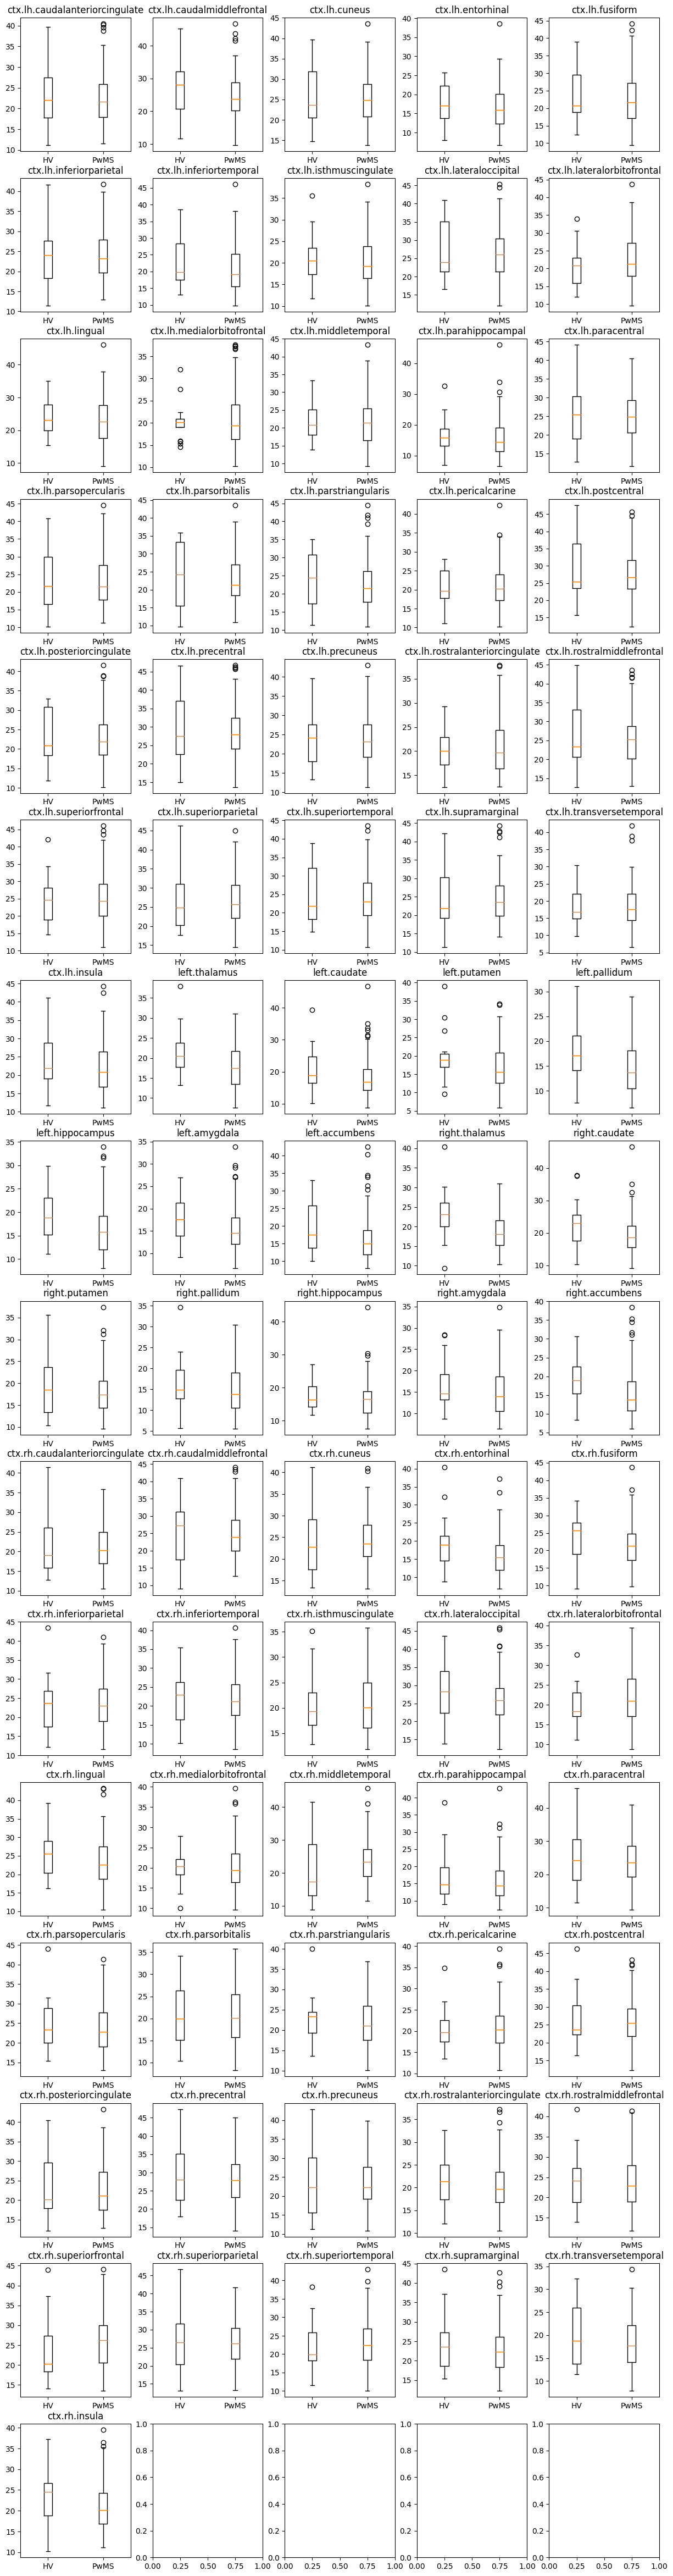

In [47]:
fig, axes = plt.subplots(16,5, figsize=(15,60))

for i in range(rs_nodes_sum.shape[1]):
    data = [HV_rs_nodes_sum[:,i], PwMS_rs_nodes_sum[:,i]]
    row = int(i/5)
    column = i%5
    axes[row, column].boxplot(data, labels=['HV', 'PwMS'])
    axes[row, column].set_title(node_names['region_name'][i])

A continuació, es comprova que la variancia de les mostres per cada node no té per què ser semblant.

In [48]:
print("            HV             PwMS")
print("----------------------------------")
for i in range(NUM_NODES):
    print("Node ", i, ": ", round(np.var(HV_rs_nodes_sum[:,i]),2), " -------- ", round(np.var(PwMS_rs_nodes_sum[:,i]),2))

            HV             PwMS
----------------------------------
Node  0 :  55.57  --------  39.65
Node  1 :  71.78  --------  46.07
Node  2 :  44.89  --------  32.71
Node  3 :  27.1  --------  29.29
Node  4 :  55.34  --------  50.86
Node  5 :  57.03  --------  39.91
Node  6 :  53.41  --------  42.27
Node  7 :  32.22  --------  30.1
Node  8 :  59.51  --------  42.41
Node  9 :  36.6  --------  43.13
Node  10 :  31.09  --------  44.13
Node  11 :  16.51  --------  37.68
Node  12 :  33.18  --------  42.66
Node  13 :  32.92  --------  37.47
Node  14 :  74.18  --------  36.61
Node  15 :  77.1  --------  47.85
Node  16 :  75.61  --------  41.05
Node  17 :  55.24  --------  44.09
Node  18 :  27.62  --------  30.35
Node  19 :  77.38  --------  43.94
Node  20 :  47.75  --------  37.3
Node  21 :  76.47  --------  47.58
Node  22 :  47.24  --------  35.85
Node  23 :  18.65  --------  31.78
Node  24 :  75.71  --------  43.84
Node  25 :  53.74  --------  46.35
Node  26 :  61.68  --------  38.37
Nod

Identifiquem tots els nodes que superen el t-test:

In [49]:
rs_nodes_p_values = get_p_values_nodes(HV_rs_nodes_sum, PwMS_rs_nodes_sum)

rs_nodes_t_test = np.where(rs_nodes_p_values<0.05)[0]
print("Número de nodes que superen el t-test: ", rs_nodes_t_test.shape[0], "\n")
node_indexs = np.argsort(rs_nodes_p_values)[:rs_nodes_t_test.shape[0]]
print(node_names['region_name'][node_indexs])

Número de nodes que superen el t-test:  5 

38      right.thalamus
44     right.accumbens
31       left.thalamus
35    left.hippocampus
39       right.caudate
Name: region_name, dtype: object


##### Comparació

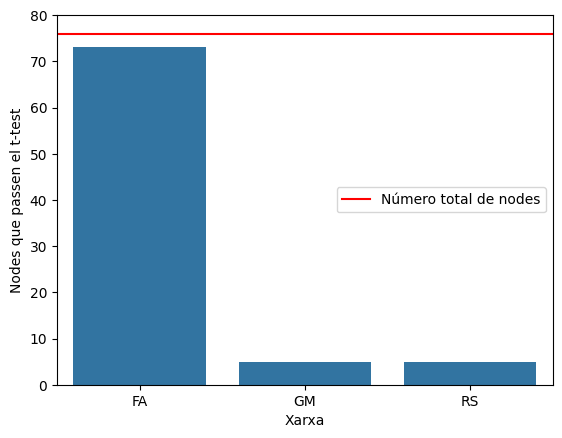

In [50]:
dim1 = fa_nodes_t_test.shape[0]
dim2 = gm_nodes_t_test.shape[0]
dim3 = rs_nodes_t_test.shape[0]

df = pd.DataFrame({'NumNodesTtest': [dim1, dim2, dim3], 'Xarxa': ['FA', 'GM', 'RS']})

ax = sns.barplot(x='Xarxa', y='NumNodesTtest', data=df)
plt.axhline(NUM_NODES, color='red', linestyle='-', label='Número total de nodes')
ax.set_ylim(0, 80)
plt.xlabel('Xarxa')
plt.ylabel('Nodes que passen el t-test')
plt.legend()
plt.show()

#### Anàlisi a partir de les arestes

A continuació, s'analitzarà què tan útil és cada aresta per distingir entre els grups HV i PwMS.

In [51]:
def get_p_values_links(HV_networks, PwMS_networks):
    p_values = np.empty((0))
    rows = np.empty((0), dtype=int)
    columns = np.empty((0), dtype=int)

    for i in range(NUM_NODES):
        for j in range(NUM_NODES):
            if i>j:
                _ , p_value = ttest_ind(HV_networks[:,i,j], PwMS_networks[:,i,j], equal_var=False)
                p_values = np.append(p_values, p_value)
                rows = np.append(rows, i)
                columns = np.append(columns, j)

    df_links = pd.DataFrame({'p_value': p_values, 'row': rows, 'column': columns}, columns=['p_value', 'row', 'column'])
    return df_links

In [52]:
def get_node_pass_percentage(relevant_links):
    percentages = np.zeros((NUM_NODES))
    for i in range(NUM_NODES):
        links_ttest = relevant_links[(relevant_links['row'] == i) | (relevant_links['column'] == i)]
        links_count = links_ttest.shape[0]
        percentages[i] = (links_count / NUM_NODES) * 100

    return percentages

##### Xarxes FA

In [53]:
# Es separa entre HV i PwMS
HV_fa = fa[HV_index, :, :]
PwMS_fa = fa[PwMS_index, :, :]

print(HV_fa.shape)
print(PwMS_fa.shape)

(18, 76, 76)
(125, 76, 76)


In [54]:
# Calculem els p-values per cada una de les arestes
fa_links = get_p_values_links(HV_fa, PwMS_fa)

fa_links

p_value  row  column
0     0.012217    1       0
1          NaN    2       0
2          NaN    2       1
3          NaN    3       0
4          NaN    3       1
...        ...  ...     ...
2845  0.015720   75      70
2846  0.000850   75      71
2847  0.001835   75      72
2848  0.002425   75      73
2849  0.019908   75      74

[2850 rows x 3 columns]

A continuació es comprova que les arestes que han obtingut NaN com a p-value al t-test és perquè tenen 0 com a pes en tots els casos, i per tant no serveixen per distingir entre grups.

In [55]:
fa_nans = fa_links[pd.isna(fa_links['p_value'])]

print(fa_nans.shape)
fa_nans

(1051, 3)


p_value  row  column
1         NaN    2       0
2         NaN    2       1
3         NaN    3       0
4         NaN    3       1
6         NaN    4       0
...       ...  ...     ...
2809      NaN   75      34
2810      NaN   75      35
2811      NaN   75      36
2812      NaN   75      37
2823      NaN   75      48

[1051 rows x 3 columns]

In [56]:
print(fa[:,2,0])
print(fa[:,3,1])
print(fa[:,75,48])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Obtenim quines arestes passen el t-test.

In [57]:
fa_relevant_links = fa_links[fa_links['p_value'] < 0.05]

print("Nombre d'arestes que passen el t-test: ", fa_relevant_links.shape[0])
fa_relevant_links

Nombre d'arestes que passen el t-test:  1095


p_value  row  column
0     0.012217    1       0
5     0.001153    3       2
8     0.000136    4       2
11    0.003818    5       1
12    0.007071    5       2
...        ...  ...     ...
2845  0.015720   75      70
2846  0.000850   75      71
2847  0.001835   75      72
2848  0.002425   75      73
2849  0.019908   75      74

[1095 rows x 3 columns]

Per cada node, calculem quin percentatge de les seves arestes han passat el t-test.

In [58]:
fa_nodes_link_percentage = get_node_pass_percentage(fa_relevant_links)

print("Percentatge d'arestes de cada node que passen el t-test:", "\n")

for i in range(NUM_NODES):
    print("Node ", i+1, ": ", round(fa_nodes_link_percentage[i], 2), "%")

Percentatge d'arestes de cada node que passen el t-test: 

Node  1 :  31.58 %
Node  2 :  38.16 %
Node  3 :  36.84 %
Node  4 :  13.16 %
Node  5 :  23.68 %
Node  6 :  53.95 %
Node  7 :  34.21 %
Node  8 :  46.05 %
Node  9 :  44.74 %
Node  10 :  23.68 %
Node  11 :  36.84 %
Node  12 :  23.68 %
Node  13 :  39.47 %
Node  14 :  21.05 %
Node  15 :  44.74 %
Node  16 :  28.95 %
Node  17 :  21.05 %
Node  18 :  32.89 %
Node  19 :  39.47 %
Node  20 :  44.74 %
Node  21 :  36.84 %
Node  22 :  40.79 %
Node  23 :  72.37 %
Node  24 :  22.37 %
Node  25 :  40.79 %
Node  26 :  59.21 %
Node  27 :  69.74 %
Node  28 :  39.47 %
Node  29 :  40.79 %
Node  30 :  15.79 %
Node  31 :  51.32 %
Node  32 :  52.63 %
Node  33 :  38.16 %
Node  34 :  53.95 %
Node  35 :  23.68 %
Node  36 :  43.42 %
Node  37 :  14.47 %
Node  38 :  11.84 %
Node  39 :  68.42 %
Node  40 :  47.37 %
Node  41 :  47.37 %
Node  42 :  31.58 %
Node  43 :  46.05 %
Node  44 :  14.47 %
Node  45 :  15.79 %
Node  46 :  23.68 %
Node  47 :  36.84 %
Node  48 :

[Text(0.5, 1.0, 'Histograma dels percentatges')]

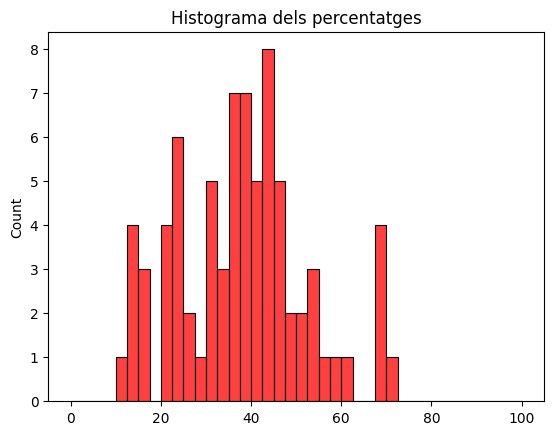

In [59]:
sns.histplot(x=fa_nodes_link_percentage, color ='red', bins=40, binrange=(0,100)).set(title='Histograma dels percentatges')

##### Xarxes GM

In [60]:
# Es separa entre HV i PwMS
HV_gm = gm[HV_index, :, :]
PwMS_gm = gm[PwMS_index, :, :]

print(HV_gm.shape)
print(PwMS_gm.shape)

(18, 76, 76)
(125, 76, 76)


In [61]:
# Calculem els p-values per cada una de les arestes
gm_links = get_p_values_links(HV_gm, PwMS_gm)

gm_links

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


p_value  row  column
0     0.390145    1       0
1     0.727809    2       0
2     0.340382    2       1
3     0.399229    3       0
4     0.068653    3       1
...        ...  ...     ...
2845  0.681773   75      70
2846  0.391955   75      71
2847  0.692952   75      72
2848  0.318834   75      73
2849  0.911502   75      74

[2850 rows x 3 columns]

Obtenim quines arestes passen el t-test

In [62]:
gm_relevant_links = gm_links[gm_links['p_value'] < 0.05]

print("Nombre d'arestes que passen el t-test: ", gm_relevant_links.shape[0])
gm_relevant_links

Nombre d'arestes que passen el t-test:  306


p_value  row  column
7     0.044037    4       1
16    0.033757    6       1
37    0.021648    9       1
39    0.039057    9       3
42    0.031423    9       6
...        ...  ...     ...
2669  0.035784   73      41
2670  0.014723   73      42
2671  0.023189   73      43
2676  0.040595   73      48
2682  0.028007   73      54

[306 rows x 3 columns]

Per cada node, calculem quin percentatge de les seves arestes han passat el t-test.

In [63]:
gm_nodes_link_percentage = get_node_pass_percentage(gm_relevant_links)

print("Percentatge d'arestes de cada node que passen el t-test:", "\n")

for i in range(NUM_NODES):
    print("Node ", i+1, ": ", round(gm_nodes_link_percentage[i], 2), "%")

Percentatge d'arestes de cada node que passen el t-test: 

Node  1 :  1.32 %
Node  2 :  31.58 %
Node  3 :  0.0 %
Node  4 :  3.95 %
Node  5 :  9.21 %
Node  6 :  0.0 %
Node  7 :  15.79 %
Node  8 :  0.0 %
Node  9 :  0.0 %
Node  10 :  28.95 %
Node  11 :  0.0 %
Node  12 :  1.32 %
Node  13 :  36.84 %
Node  14 :  21.05 %
Node  15 :  22.37 %
Node  16 :  1.32 %
Node  17 :  25.0 %
Node  18 :  43.42 %
Node  19 :  5.26 %
Node  20 :  2.63 %
Node  21 :  3.95 %
Node  22 :  6.58 %
Node  23 :  14.47 %
Node  24 :  1.32 %
Node  25 :  34.21 %
Node  26 :  15.79 %
Node  27 :  1.32 %
Node  28 :  2.63 %
Node  29 :  1.32 %
Node  30 :  6.58 %
Node  31 :  0.0 %
Node  32 :  10.53 %
Node  33 :  0.0 %
Node  34 :  0.0 %
Node  35 :  0.0 %
Node  36 :  42.11 %
Node  37 :  18.42 %
Node  38 :  11.84 %
Node  39 :  13.16 %
Node  40 :  3.95 %
Node  41 :  0.0 %
Node  42 :  25.0 %
Node  43 :  39.47 %
Node  44 :  44.74 %
Node  45 :  5.26 %
Node  46 :  1.32 %
Node  47 :  0.0 %
Node  48 :  15.79 %
Node  49 :  27.63 %
Node  50 : 

[Text(0.5, 1.0, 'Histograma dels percentatges')]

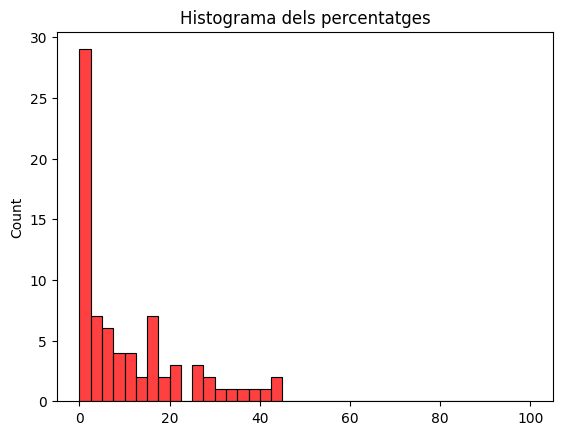

In [64]:
sns.histplot(x=gm_nodes_link_percentage, color ='red', bins=40, binrange=(0,100)).set(title='Histograma dels percentatges')

##### Xarxes RS

In [65]:
# Es separa entre HV i PwMS
HV_rs = rs[HV_index, :, :]
PwMS_rs = rs[PwMS_index, :, :]

print(HV_rs.shape)
print(PwMS_rs.shape)

(18, 76, 76)
(125, 76, 76)


In [66]:
# Calculem els p-values per cada una de les arestes
rs_links = get_p_values_links(HV_rs, PwMS_rs)

rs_links

p_value  row  column
0     0.823733    1       0
1     0.654146    2       0
2     0.106231    2       1
3     0.624963    3       0
4     0.602645    3       1
...        ...  ...     ...
2845  0.503725   75      70
2846  0.689167   75      71
2847  0.183784   75      72
2848  0.685891   75      73
2849  0.237743   75      74

[2850 rows x 3 columns]

Obtenim quines arestes passen el t-test

In [67]:
rs_relevant_links = rs_links[rs_links['p_value'] < 0.05]

print("Nombre d'arestes que passen el t-test: ", rs_relevant_links.shape[0])
rs_relevant_links

Nombre d'arestes que passen el t-test:  159


p_value  row  column
56    0.017748   11       1
97    0.020717   14       6
229   0.018260   21      19
258   0.003881   23       5
260   0.034493   23       7
...        ...  ...     ...
2734  0.044953   74      33
2745  0.041053   74      44
2753  0.033660   74      52
2778  0.033707   75       3
2810  0.003304   75      35

[159 rows x 3 columns]

Per cada node, calculem quin percentatge de les seves arestes han passat el t-test.

In [68]:
rs_nodes_link_percentage = get_node_pass_percentage(rs_relevant_links)

print("Percentatge d'arestes de cada node que passen el t-test:", "\n")

for i in range(NUM_NODES):
    print("Node ", i+1, ": ", round(rs_nodes_link_percentage[i], 2), "%")

Percentatge d'arestes de cada node que passen el t-test: 

Node  1 :  1.32 %
Node  2 :  7.89 %
Node  3 :  2.63 %
Node  4 :  2.63 %
Node  5 :  1.32 %
Node  6 :  6.58 %
Node  7 :  9.21 %
Node  8 :  10.53 %
Node  9 :  3.95 %
Node  10 :  3.95 %
Node  11 :  1.32 %
Node  12 :  6.58 %
Node  13 :  9.21 %
Node  14 :  3.95 %
Node  15 :  2.63 %
Node  16 :  2.63 %
Node  17 :  5.26 %
Node  18 :  6.58 %
Node  19 :  0.0 %
Node  20 :  1.32 %
Node  21 :  5.26 %
Node  22 :  5.26 %
Node  23 :  3.95 %
Node  24 :  13.16 %
Node  25 :  0.0 %
Node  26 :  2.63 %
Node  27 :  2.63 %
Node  28 :  2.63 %
Node  29 :  0.0 %
Node  30 :  9.21 %
Node  31 :  2.63 %
Node  32 :  14.47 %
Node  33 :  6.58 %
Node  34 :  6.58 %
Node  35 :  9.21 %
Node  36 :  18.42 %
Node  37 :  3.95 %
Node  38 :  7.89 %
Node  39 :  10.53 %
Node  40 :  11.84 %
Node  41 :  0.0 %
Node  42 :  2.63 %
Node  43 :  5.26 %
Node  44 :  1.32 %
Node  45 :  18.42 %
Node  46 :  3.95 %
Node  47 :  6.58 %
Node  48 :  2.63 %
Node  49 :  13.16 %
Node  50 :  5.2

[Text(0.5, 1.0, 'Histograma dels percentatges')]

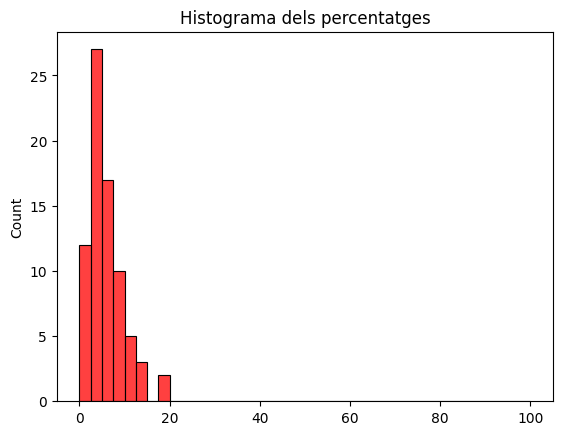

In [69]:
sns.histplot(x=rs_nodes_link_percentage, color ='red', bins=40, binrange=(0,100)).set(title='Histograma dels percentatges')

##### Comparació

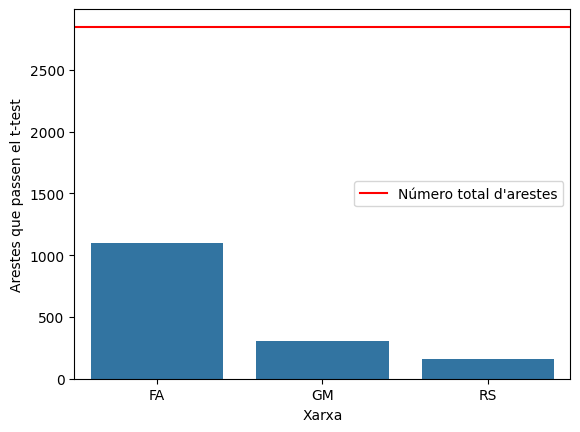

In [70]:
dim1 = fa_relevant_links.shape[0]
dim2 = gm_relevant_links.shape[0]
dim3 = rs_relevant_links.shape[0]

df = pd.DataFrame({'NumLinksTtest': [dim1, dim2, dim3], 'Xarxa': ['FA', 'GM', 'RS']})

ax = sns.barplot(x='Xarxa', y='NumLinksTtest', data=df)
plt.axhline(NUM_ARESTES, color='red', linestyle='-', label="Número total d'arestes")
#ax.set_ylim(0, 80)
plt.xlabel('Xarxa')
plt.ylabel('Arestes que passen el t-test')
plt.legend()
plt.show()

### Anàlisi dels valors d'EDSS

En aquest apartat es farà un anàlisi de la relació entre els nodes de les xarxes i els valors de EDSS de cada persona. Per fer-ho, es calcularà la correlació entre l'strength de cada node i els valors de EDSS.

#### Xarxes FA

In [71]:
print(fa_nodes_sum.shape)

(143, 76)


In [72]:
fa_edss_correlations = np.array([])

for i in range(fa_nodes_sum.shape[1]):
    node_i = fa_nodes_sum[:,i]
    df_node_i = pd.Series(node_i)
    correlation = clinical_data['edss'].corr(df_node_i)
    fa_edss_correlations = np.append(fa_edss_correlations, correlation)
fa_edss_correlations = np.absolute(fa_edss_correlations)

print("Correlació de cada node amb l'EDSS:", "\n")

for i in range(NUM_NODES):
    print("Node ", i+1, ": ", round(fa_edss_correlations[i], 3))

Correlació de cada node amb l'EDSS: 

Node  1 :  0.25
Node  2 :  0.261
Node  3 :  0.313
Node  4 :  0.364
Node  5 :  0.313
Node  6 :  0.323
Node  7 :  0.31
Node  8 :  0.215
Node  9 :  0.302
Node  10 :  0.265
Node  11 :  0.32
Node  12 :  0.247
Node  13 :  0.342
Node  14 :  0.281
Node  15 :  0.421
Node  16 :  0.211
Node  17 :  0.269
Node  18 :  0.224
Node  19 :  0.248
Node  20 :  0.381
Node  21 :  0.285
Node  22 :  0.292
Node  23 :  0.341
Node  24 :  0.295
Node  25 :  0.276
Node  26 :  0.348
Node  27 :  0.377
Node  28 :  0.376
Node  29 :  0.349
Node  30 :  0.321
Node  31 :  0.214
Node  32 :  0.248
Node  33 :  0.33
Node  34 :  0.295
Node  35 :  0.161
Node  36 :  0.33
Node  37 :  0.219
Node  38 :  0.262
Node  39 :  0.228
Node  40 :  0.387
Node  41 :  0.289
Node  42 :  0.187
Node  43 :  0.366
Node  44 :  0.278
Node  45 :  0.454
Node  46 :  0.243
Node  47 :  0.333
Node  48 :  0.307
Node  49 :  0.218
Node  50 :  0.209
Node  51 :  0.354
Node  52 :  0.279
Node  53 :  0.315
Node  54 :  0.347
Node

[Text(0.5, 1.0, 'Histograma de les correlacions')]

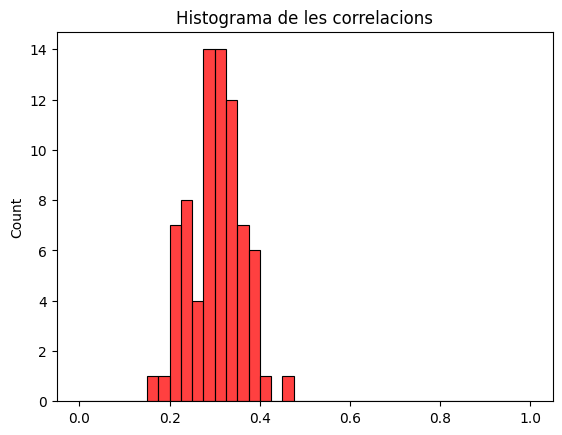

In [73]:
sns.histplot(x=fa_edss_correlations, color ='red', bins=40, binrange=(0,1)).set(title='Histograma de les correlacions')

In [74]:
pd.DataFrame(fa_edss_correlations).describe()

0
count  76.000000
mean    0.302873
std     0.057591
min     0.161421
25%     0.264573
50%     0.311515
75%     0.342951
max     0.453711

In [75]:
print(fa_edss_correlations)

[0.2497946  0.26103892 0.31324148 0.36375755 0.3134199  0.32277327
 0.30978823 0.21462549 0.30187856 0.26546966 0.31964004 0.24718545
 0.3422082  0.28124766 0.42053421 0.21136485 0.26908131 0.22392556
 0.24840224 0.38063009 0.28502021 0.29234182 0.34068109 0.29537722
 0.27622174 0.34817903 0.37726305 0.37564449 0.34888456 0.32133399
 0.21355461 0.2481384  0.32962364 0.2948275  0.1614212  0.32984364
 0.21880327 0.261884   0.22784559 0.38724241 0.28878603 0.18702213
 0.36590031 0.27801193 0.45371092 0.24265026 0.33305905 0.30716067
 0.21783365 0.20859897 0.35431074 0.27913733 0.31512512 0.34715566
 0.31520783 0.3415412  0.31496134 0.31861914 0.28542415 0.37660933
 0.27857969 0.29257084 0.31433103 0.34518084 0.36794057 0.23600693
 0.37020499 0.33615527 0.22594737 0.35626695 0.36143534 0.39631852
 0.33356124 0.31465009 0.2890249  0.27517463]


#### Xarxes GM

In [76]:
gm_edss_correlations = np.array([])

for i in range(gm_nodes_sum.shape[1]):
    node_i = gm_nodes_sum[:,i]
    df_node_i = pd.Series(node_i)
    correlation = clinical_data['edss'].corr(df_node_i)
    gm_edss_correlations = np.append(gm_edss_correlations, correlation)
gm_edss_correlations = np.absolute(gm_edss_correlations)

print("Correlació de cada node amb l'EDSS:", "\n")

for i in range(NUM_NODES):
    print("Node ", i+1, ": ", round(gm_edss_correlations[i], 3))

Correlació de cada node amb l'EDSS: 

Node  1 :  0.144
Node  2 :  0.179
Node  3 :  0.198
Node  4 :  0.197
Node  5 :  0.161
Node  6 :  0.14
Node  7 :  0.192
Node  8 :  0.112
Node  9 :  0.126
Node  10 :  0.19
Node  11 :  0.12
Node  12 :  0.085
Node  13 :  0.209
Node  14 :  0.27
Node  15 :  0.004
Node  16 :  0.093
Node  17 :  0.152
Node  18 :  0.159
Node  19 :  0.13
Node  20 :  0.091
Node  21 :  0.187
Node  22 :  0.008
Node  23 :  0.155
Node  24 :  0.142
Node  25 :  0.163
Node  26 :  0.244
Node  27 :  0.168
Node  28 :  0.153
Node  29 :  0.128
Node  30 :  0.159
Node  31 :  0.225
Node  32 :  0.105
Node  33 :  0.018
Node  34 :  0.121
Node  35 :  0.008
Node  36 :  0.27
Node  37 :  0.205
Node  38 :  0.052
Node  39 :  0.164
Node  40 :  0.089
Node  41 :  0.117
Node  42 :  0.042
Node  43 :  0.22
Node  44 :  0.184
Node  45 :  0.122
Node  46 :  0.07
Node  47 :  0.179
Node  48 :  0.184
Node  49 :  0.239
Node  50 :  0.132
Node  51 :  0.145
Node  52 :  0.146
Node  53 :  0.078
Node  54 :  0.068
Node  5

[Text(0.5, 1.0, 'Histograma de les correlacions')]

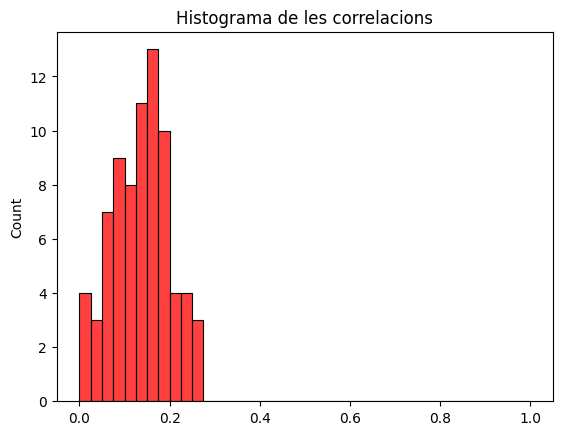

In [77]:
sns.histplot(x=gm_edss_correlations, color ='red', bins=40, binrange=(0,1)).set(title='Histograma de les correlacions')

In [78]:
pd.DataFrame(gm_edss_correlations).describe()

0
count  76.000000
mean    0.136081
std     0.063967
min     0.003649
25%     0.090954
50%     0.142707
75%     0.179507
max     0.269935

#### Xarxes RS

In [79]:
rs_edss_correlations = np.array([])

for i in range(rs_nodes_sum.shape[1]):
    node_i = rs_nodes_sum[:,i]
    df_node_i = pd.Series(node_i)
    correlation = clinical_data['edss'].corr(df_node_i)
    rs_edss_correlations = np.append(rs_edss_correlations, correlation)
rs_edss_correlations = np.absolute(rs_edss_correlations)

print("Correlació de cada node amb l'EDSS:", "\n")

for i in range(NUM_NODES):
    print("Node ", i+1, ": ", round(rs_edss_correlations[i], 3))

Correlació de cada node amb l'EDSS: 

Node  1 :  0.077
Node  2 :  0.112
Node  3 :  0.081
Node  4 :  0.044
Node  5 :  0.035
Node  6 :  0.141
Node  7 :  0.159
Node  8 :  0.008
Node  9 :  0.076
Node  10 :  0.042
Node  11 :  0.107
Node  12 :  0.048
Node  13 :  0.047
Node  14 :  0.022
Node  15 :  0.094
Node  16 :  0.056
Node  17 :  0.081
Node  18 :  0.051
Node  19 :  0.09
Node  20 :  0.1
Node  21 :  0.002
Node  22 :  0.096
Node  23 :  0.045
Node  24 :  0.001
Node  25 :  0.092
Node  26 :  0.075
Node  27 :  0.098
Node  28 :  0.106
Node  29 :  0.072
Node  30 :  0.005
Node  31 :  0.005
Node  32 :  0.144
Node  33 :  0.181
Node  34 :  0.07
Node  35 :  0.07
Node  36 :  0.012
Node  37 :  0.005
Node  38 :  0.159
Node  39 :  0.205
Node  40 :  0.135
Node  41 :  0.034
Node  42 :  0.062
Node  43 :  0.073
Node  44 :  0.059
Node  45 :  0.198
Node  46 :  0.038
Node  47 :  0.0
Node  48 :  0.042
Node  49 :  0.004
Node  50 :  0.083
Node  51 :  0.136
Node  52 :  0.035
Node  53 :  0.038
Node  54 :  0.023
Node  

[Text(0.5, 1.0, 'Histograma de les correlacions')]

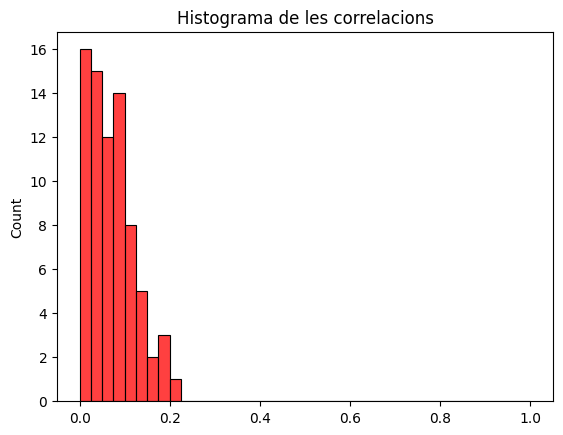

In [80]:
sns.histplot(x=rs_edss_correlations, color ='red', bins=40, binrange=(0,1)).set(title='Histograma de les correlacions')

In [81]:
pd.DataFrame(rs_edss_correlations).describe()

0
count  76.000000
mean    0.070840
std     0.050793
min     0.000171
25%     0.032322
50%     0.068418
75%     0.098476
max     0.204717

#### Comparació

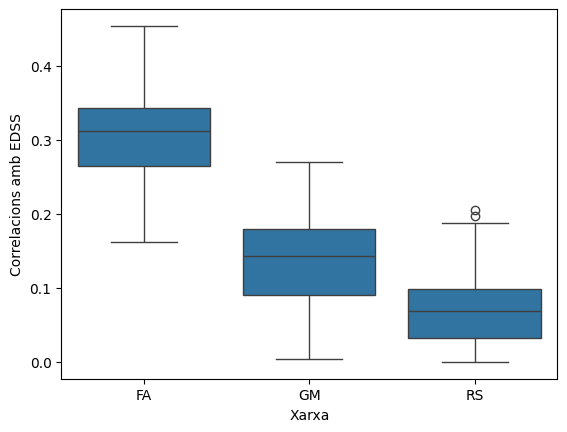

In [82]:
df = pd.DataFrame({'Xarxa': np.repeat(['FA', 'GM', 'RS'], NUM_NODES),'Value': np.concatenate([fa_edss_correlations, gm_edss_correlations, rs_edss_correlations])})

sns.boxplot(x='Xarxa', y='Value', data=df)
plt.xlabel('Xarxa')
plt.ylabel('Correlacions amb EDSS')
plt.show()

### Aplicació de thresholds a les xarxes

Degut a la poca quantitat de nodes que han passat el t-test a les xarxes GM i RS, en aquest apartat es provarà de modificar els valors d'aquestes xarxes mitjançant un threshold, per veure si d'aquesta forma es milloren els resultats.

Es provaran diversos valors com a thresholds, i per cada valor es provarà tant binaritzant, és a dir deixar els valors per sota del threshold a 0 i els valors per sobre del threshold a 1, com no binaritzant, és a dir mantenint igual els valors que es troben per sobre del threshold.

In [83]:
def apply_threshold(networks, thres, binarize):
    if binarize:
        new_networks = np.where(networks < thres, 0, 1)
    else:
        new_networks = np.where(networks < thres, 0, networks)
    return new_networks

#### A les xarxes GM

In [84]:
for thres in np.arange(0.0025, 0.041, 0.0025):
    for binarize in [True, False]:
        filtered_gm = apply_threshold(gm, thres, binarize)

        filtered_nodes_sum = get_nodes_sum(filtered_gm)
        HV_filtered = filtered_nodes_sum[HV_index, :]
        PwMS_filtered = filtered_nodes_sum[PwMS_index, :]
        p_values = get_p_values_nodes(HV_filtered, PwMS_filtered)
        small_p_values = np.where(p_values<0.05)

        print("Threshold: ", round(thres,4), "; Binarize: ", str(binarize), " - ", small_p_values[0].shape[0], " nodes passen el t-test")
    print("----------------------------------------------------------------------")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Threshold:  0.0025 ; Binarize:  True  -  2  nodes passen el t-test
Threshold:  0.0025 ; Binarize:  False  -  5  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.005 ; Binarize:  True  -  5  nodes passen el t-test
Threshold:  0.005 ; Binarize:  False  -  4  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.0075 ; Binarize:  True  -  5  nodes passen el t-test
Threshold:  0.0075 ; Binarize:  False  -  5  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.01 ; Binarize:  True  -  2  nodes passen el t-test
Threshold:  0.01 ; Binarize:  False  -  5  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.0125 ; Binarize:  True  -  3  nodes passen el t-test
Threshold:  0.0125 ; Binarize:  False  -  4  nodes passen el t-test
-----------------------------------------------

Visualització amb els valors òptims:

In [85]:
threshold_gm = 0.04
binarize_gm = False

print("Valors per sota del threshold: ", np.count_nonzero(gm<threshold_gm))
print("Valors per sobre del threshold: ", np.count_nonzero(gm>=threshold_gm))

Valors per sota del threshold:  414544
Valors per sobre del threshold:  411424


[Text(0.5, 1.0, 'Histograma de valors de les matrius GM amb el threshold aplicat')]

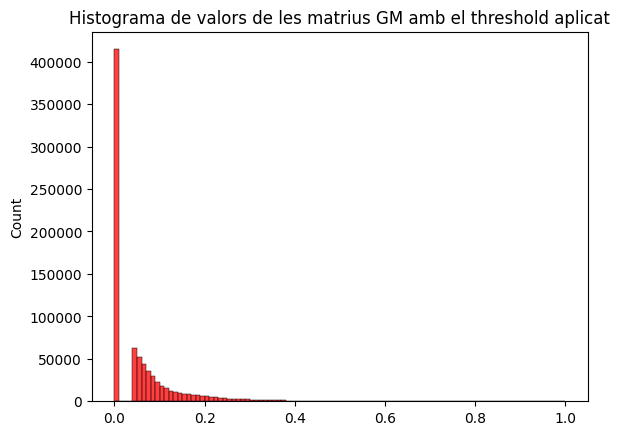

In [86]:
filtered_gm = apply_threshold(gm, threshold_gm, binarize_gm)
filtered_gm_values = filtered_gm.flatten()

sns.histplot(x=filtered_gm_values, color ='red', bins=100).set(title='Histograma de valors de les matrius GM amb el threshold aplicat')

In [87]:
filtered_gm_nodes_sum = get_nodes_sum(filtered_gm)
HV_filtered_gm = filtered_gm_nodes_sum[HV_index, :]
PwMS_filtered_gm = filtered_gm_nodes_sum[PwMS_index, :]
filtered_gm_p_values = get_p_values_nodes(HV_filtered_gm, PwMS_filtered_gm)

f_gm_nodes_t_test = np.where(filtered_gm_p_values<0.05)[0]
print("Número de nodes que passen el t-test: ", f_gm_nodes_t_test.shape[0], "\n")
node_indexs = np.argsort(filtered_gm_p_values)[:f_gm_nodes_t_test.shape[0]]
print(node_names['region_name'][node_indexs])

Número de nodes que passen el t-test:  8 

43                 right.amygdala
24    ctx.lh.rostralmiddlefrontal
17        ctx.lh.parstriangularis
36                  left.amygdala
35               left.hippocampus
48              ctx.rh.entorhinal
1      ctx.lh.caudalmiddlefrontal
9     ctx.lh.lateralorbitofrontal
Name: region_name, dtype: object


#### A les xarxes RS

In [88]:
for thres in np.arange(0.01, 0.251, 0.01):
    for binarize in [True, False]:
        filtered_rs = apply_threshold(rs, thres, binarize)

        filtered_nodes_sum = get_nodes_sum(filtered_rs)
        HV_filtered = filtered_nodes_sum[HV_index, :]
        PwMS_filtered = filtered_nodes_sum[PwMS_index, :]
        p_values = get_p_values_nodes(HV_filtered, PwMS_filtered)
        small_p_values = np.where(p_values<0.05)

        print("Threshold: ", round(thres,3), "; Binarize: ", str(binarize), " - ", small_p_values[0].shape[0], " nodes passen el t-test")
    print("----------------------------------------------------------------------")

Threshold:  0.01 ; Binarize:  True  -  5  nodes passen el t-test
Threshold:  0.01 ; Binarize:  False  -  5  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.02 ; Binarize:  True  -  2  nodes passen el t-test
Threshold:  0.02 ; Binarize:  False  -  5  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.03 ; Binarize:  True  -  4  nodes passen el t-test
Threshold:  0.03 ; Binarize:  False  -  5  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.04 ; Binarize:  True  -  4  nodes passen el t-test
Threshold:  0.04 ; Binarize:  False  -  5  nodes passen el t-test
----------------------------------------------------------------------
Threshold:  0.05 ; Binarize:  True  -  3  nodes passen el t-test
Threshold:  0.05 ; Binarize:  False  -  5  nodes passen el t-test
-------------------------------------------------------------

Visualització amb els valors òptims:

In [89]:
# Cap dels thresholds consegueix millorar els resultats, per tant ho mantenim igual
threshold_rs = 0
binarize_rs = False

print("Valors per sota del threshold: ", np.count_nonzero(rs<threshold_rs))
print("Valors per sobre del threshold: ", np.count_nonzero(rs>=threshold_rs))

Valors per sota del threshold:  0
Valors per sobre del threshold:  825968


[Text(0.5, 1.0, 'Histograma de valors de les matrius RS amb el threshold aplicat')]

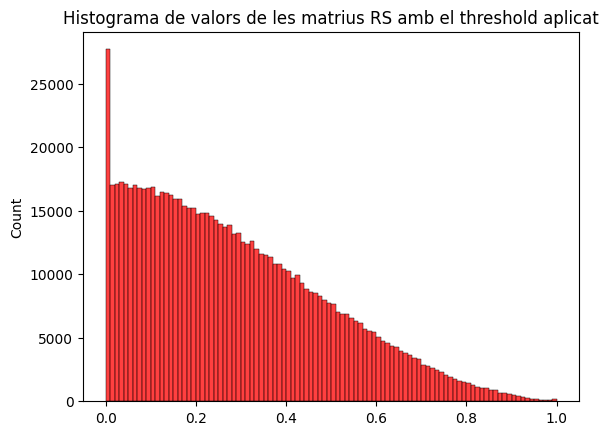

In [90]:
filtered_rs = apply_threshold(rs, threshold_rs, binarize_rs)
filtered_rs_values = filtered_rs.flatten()

sns.histplot(x=filtered_rs_values, color ='red', bins=100).set(title='Histograma de valors de les matrius RS amb el threshold aplicat')

In [91]:
filtered_rs_nodes_sum = get_nodes_sum(filtered_rs)
HV_filtered_rs = filtered_rs_nodes_sum[HV_index, :]
PwMS_filtered_rs = filtered_rs_nodes_sum[PwMS_index, :]
filtered_rs_p_values = get_p_values_nodes(HV_filtered_rs, PwMS_filtered_rs)

f_rs_nodes_t_test = np.where(filtered_rs_p_values<0.05)[0]
print("Número de nodes que passen el t-test: ", f_rs_nodes_t_test.shape[0], "\n")
node_indexs = np.argsort(filtered_rs_p_values)[:f_rs_nodes_t_test.shape[0]]
print(node_names['region_name'][node_indexs])

Número de nodes que passen el t-test:  5 

38      right.thalamus
44     right.accumbens
31       left.thalamus
35    left.hippocampus
39       right.caudate
Name: region_name, dtype: object


#### Comparació

A continuació, es mostra un diagrama de Venn per analitzar les interseccions i diferències entre els tres conjunts de nodes que han passat el t-test en cadascuna de les tres xarxes. En el cas de les xarxes GM i RS, s'utilitzen els valors processats amb el threshold.

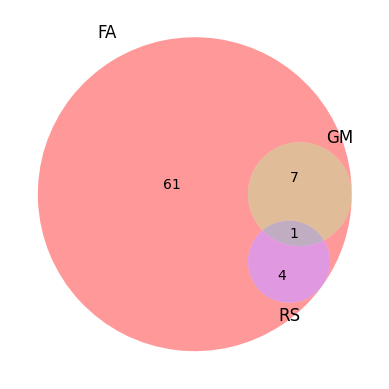

In [92]:
set1 = set(fa_nodes_t_test)
set2 = set(f_gm_nodes_t_test)
set3 = set(f_rs_nodes_t_test)

venn3([set1, set2, set3], ('FA', 'GM', 'RS'))
plt.show()

## CREACIÓ DE LES XARXES

En aquest apartat s'estableixen diferents estratègies de selecció de les xarxes i nodes que s'utilitzaran.

In [93]:
# Aquí es guardaran les xarxes creades
networks = []
# Aquí es guardarà si son single-layer o multi-layer
network_types = []
#Aquí es guardarà el nom de les xarxes per poder-les identificar
network_names = []

### Single-layer FA

En el primer dels casos s'utilitzarà una xarxa single-layer utilitzant simplement les matrius FA.

In [94]:
networks.append(fa.copy())
network_types.append('SL')
network_names.append("Single-layer FA")

print(networks[0].shape)

(143, 76, 76)


### Multi-layer

En el segon dels casos, es crearà una multi-layer network a partir de les tres xarxes disponibles, amb els valors originals i sense cap filtratge de nodes. S'estableix la xarxa FA com a interlayer.

In [95]:
# funció que crea una xarxa multilayer a partir de tres capes
def create_multilayer(layer1, layer2, inter):
    n_subjects = layer1.shape[0]
    n_nodes = layer1.shape[1]

    multilayer = np.empty((n_subjects, n_nodes*2, n_nodes*2))
    multilayer[:,:n_nodes,:n_nodes] = layer1
    multilayer[:,:n_nodes,n_nodes:] = inter
    multilayer[:,n_nodes:,:n_nodes] = inter
    multilayer[:,n_nodes:,n_nodes:] = layer2

    return multilayer

In [96]:
networks.append(create_multilayer(gm, rs, fa))
network_types.append('ML')
network_names.append("Multi-layer estàndar")

print(networks[1].shape)

(143, 152, 152)


### Multi-layer amb thresholds

En el tercer dels casos, es crearà també una multi-layer network amb les tres xarxes disponibles, però les xarxes GM i RS tindran els thresholds aplicats. S'estableix la xarxa FA com a interlayer.

In [97]:
networks.append(create_multilayer(filtered_gm, filtered_rs, fa))
network_types.append('ML')
network_names.append("Multi-layer amb thresholds")

print(networks[2].shape)

(143, 152, 152)


### Multi-layer amb selecció d'arestes rellevants

També es provarà d'implementar una xarxa multi-layer mantenint únicament les arestes rellevants a cada capa, segons el t-test que se'ls ha aplicat individualment a l'apartat anterior. Les que no l'hagin superat es posen a 0.

In [98]:
# Creem les 3 matrius amb les arestes no rellevants eliminades

fa_filtered_links = fa.copy()
fa_non_relevant_links = fa_links.drop(fa_relevant_links.index.tolist())
for index, link in fa_non_relevant_links.iterrows():
    fa_filtered_links[:,int(link['row']),int(link['column'])] = 0
    fa_filtered_links[:,int(link['column']),int(link['row'])] = 0

gm_filtered_links = gm.copy()
gm_non_relevant_links = gm_links.drop(gm_relevant_links.index.tolist())
for index, link in gm_non_relevant_links.iterrows():
    gm_filtered_links[:,int(link['row']),int(link['column'])] = 0
    gm_filtered_links[:,int(link['column']),int(link['row'])] = 0

rs_filtered_links = rs.copy()
rs_non_relevant_links = rs_links.drop(rs_relevant_links.index.tolist())
for index, link in rs_non_relevant_links.iterrows():
    rs_filtered_links[:,int(link['row']),int(link['column'])] = 0
    rs_filtered_links[:,int(link['column']),int(link['row'])] = 0

In [99]:
networks.append(create_multilayer(gm_filtered_links, rs_filtered_links, fa_filtered_links))
network_types.append('ML')
network_names.append("Multi-layer amb selecció d'arestes")

print(networks[3].shape)

(143, 152, 152)


### Single-layers amb selecció d'arestes rellevants

Per últim, es provarà d'aplicar també a les xarxes single-layer l'estratègia de mantenir únicament les arestes que han superat el t-test. Es provarà amb els tres tipus de xarxa (FA, GM i RS).

In [100]:
networks.append(fa_filtered_links.copy())
network_types.append('SL')
network_names.append("Single-layer FA amb selecció d'arestes")

print(networks[4].shape)

(143, 76, 76)


In [101]:
networks.append(gm_filtered_links.copy())
network_types.append('SL')
network_names.append("Single-layer GM amb selecció d'arestes")

print(networks[5].shape)

(143, 76, 76)


In [102]:
networks.append(rs_filtered_links.copy())
network_types.append('SL')
network_names.append("Single-layer RS amb selecció d'arestes")

print(networks[6].shape)

(143, 76, 76)


## OBTENCIÓ DE MÈTRIQUES

### Definició de funcions

In [ ]:
# Rep una matriu d'adjacència i retorna els valors invertits amb la fórmula 1/w
def get_inverse_weights(M):
    M_inv = np.zeros(M.shape, dtype=float)

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if not M[i,j] == 0:
                M_inv[i,j] = 1 / M[i,j]

    return M_inv

In [ ]:
# Crea la matriu de distàncies mínimes a partir d'una xarxa multilayer
def get_min_distance_matrix(M):
    n_nodes = int(M.shape[0]/2)
    min_M = np.zeros((n_nodes,n_nodes), dtype=float)

    for i in range(n_nodes):
        for j in range(n_nodes):
            distances = np.array([M[i,j], M[i,j+n_nodes], M[i+n_nodes,j], M[i+n_nodes,j+n_nodes]])
            if np.count_nonzero(distances):
                distances_nonzero = distances[np.nonzero(distances)]
                min_M[i,j] = np.min(distances_nonzero)
            else:
                min_M[i,j] = 0

    return min_M

In [ ]:
# Crea la matriu de pesos màxims a partir d'una xarxa multilayer
def get_max_weight_matrix(M):
    n_nodes = int(M.shape[0]/2)
    max_M = np.zeros((n_nodes,n_nodes), dtype=float)

    for i in range(n_nodes):
        for j in range(n_nodes):
            weights = np.array([M[i,j], M[i,j+n_nodes], M[i+n_nodes,j], M[i+n_nodes,j+n_nodes]])
            max_M[i,j] = np.max(weights)

    return max_M

A continuació es defineixen les funcions per calcular una mètrica concreta a partir de les xarxes de tots els subjectes.

In [ ]:
def get_strength_SL(SL):
    strength = np.empty((NUM_SUBJECTS, NUM_NODES))
    for i in range(NUM_SUBJECTS):
        SL_i = SL[i,:,:]
        strength[i,:] = np.sum(SL_i, axis=0)
    return strength

In [ ]:
def get_strength_ML(ML):
    n_nodes = int(ML.shape[1]/2)
    strength = np.empty((NUM_SUBJECTS, n_nodes))
    for i in range(NUM_SUBJECTS):
        ML_i = ML[i,:,:]
        strenght_aux = np.sum(ML_i, axis=0)
        strenght_aux = strenght_aux.reshape((n_nodes,2), order='F')
        strength[i,:] = np.sum(strenght_aux, axis=1)
    return strength

In [ ]:
def get_degree_SL(SL):
    degree = np.empty((NUM_SUBJECTS, NUM_NODES))
    for i in range(NUM_SUBJECTS):
        SL_i = SL[i,:,:]
        G = nx.from_numpy_array(A=SL_i)
        degree[i,:] = list(nx.degree_centrality(G).values())
    return degree

In [ ]:
def get_degree_ML(ML):
    n_nodes = int(ML.shape[1]/2)
    degree = np.empty((NUM_SUBJECTS, n_nodes))
    for i in range(NUM_SUBJECTS):
        ML_i = ML[i,:,:]
        degree_aux = np.count_nonzero(ML_i > 0, axis=0)
        degree_aux = degree_aux.reshape((n_nodes,2), order='F')
        degree_abs = np.sum(degree_aux, axis=1)
        degree_centrality = degree_abs / ((n_nodes-1)*4)
        degree[i,:] = degree_centrality
    return degree

In [ ]:
def get_betweenness_centrality_SL(SL):
    betweenness = np.empty((NUM_SUBJECTS, NUM_NODES))
    for i in range(NUM_SUBJECTS):
        SL_i = SL[i,:,:]
        inv_SL_i = get_inverse_weights(SL_i)
        G = nx.from_numpy_array(A=inv_SL_i)
        betweenness[i,:] = list(nx.betweenness_centrality(G, weight='weight').values())
        #print("Subject ", i)
    return betweenness

In [ ]:
def get_betweenness_centrality_ML(ML):
    n_nodes = int(ML.shape[1]/2)
    betweenness = np.empty((NUM_SUBJECTS, n_nodes))
    for i in range(NUM_SUBJECTS):
        ML_i = ML[i,:,:]
        inv_ML_i = get_inverse_weights(ML_i)
        min_d_ML_i = get_min_distance_matrix(inv_ML_i)
        G = nx.from_numpy_array(A=min_d_ML_i)
        betweenness[i,:] = list(nx.betweenness_centrality(G, weight='weight').values())
        #print("Subject ", i)
    return betweenness

In [ ]:
def get_closeness_centrality_SL(SL):
    closeness = np.empty((NUM_SUBJECTS, NUM_NODES))
    for i in range(NUM_SUBJECTS):
        SL_i = SL[i,:,:]
        inv_SL_i = get_inverse_weights(SL_i)
        G = nx.from_numpy_array(A=inv_SL_i)
        closeness[i,:] = list(nx.closeness_centrality(G, distance='weight').values())
        #print("Subject ", i)
    return closeness

In [ ]:
def get_closeness_centrality_ML(ML):
    n_nodes = int(ML.shape[1]/2)
    closeness = np.empty((NUM_SUBJECTS, n_nodes))
    for i in range(NUM_SUBJECTS):
        ML_i = ML[i,:,:]
        inv_ML_i = get_inverse_weights(ML_i)
        min_d_ML_i = get_min_distance_matrix(inv_ML_i)
        G = nx.from_numpy_array(A=min_d_ML_i)
        closeness[i,:] = list(nx.closeness_centrality(G, distance='weight').values())
        #print("Subject ", i)
    return closeness

In [ ]:
def get_clustering_coefficient_SL(SL):
    clustering = np.empty((NUM_SUBJECTS, NUM_NODES))
    for i in range(NUM_SUBJECTS):
        SL_i = SL[i,:,:]
        G = nx.from_numpy_array(A=SL_i)
        clustering[i,:] = list(nx.clustering(G, weight='weight').values())
        #print("Subject ", i)
    return clustering

In [ ]:
def get_clustering_coefficient_ML(ML):
    n_nodes = int(ML.shape[1]/2)
    clustering = np.empty((NUM_SUBJECTS, n_nodes))
    for i in range(NUM_SUBJECTS):
        ML_i = ML[i,:,:]
        max_w_ML_i = get_max_weight_matrix(ML_i)
        G = nx.from_numpy_array(A=max_w_ML_i)
        clustering[i,:] = list(nx.clustering(G, weight='weight').values())
        #print("Subject ", i)
    return clustering

In [ ]:
def get_page_rank_SL(SL):
    page_rank = np.empty((NUM_SUBJECTS, NUM_NODES))
    for i in range(NUM_SUBJECTS):
        SL_i = SL[i,:,:]
        G = nx.from_numpy_array(A=SL_i)
        page_rank[i,:] = list(nx.pagerank(G, weight='weight').values())
        #print("Subject ", i)
    return page_rank

In [ ]:
def get_page_rank_ML(ML):
    n_nodes = int(ML.shape[1]/2)
    page_rank = np.empty((NUM_SUBJECTS, n_nodes))
    for i in range(NUM_SUBJECTS):
        ML_i = ML[i,:,:]
        max_w_ML_i = get_max_weight_matrix(ML_i)
        G = nx.from_numpy_array(A=max_w_ML_i)
        page_rank[i,:] = list(nx.pagerank(G, weight='weight').values())
        #print("Subject ", i)
    return page_rank

In [ ]:
def get_local_efficiency_SL(SL):
    efficiency = np.empty((NUM_SUBJECTS, NUM_NODES))
    for i in range(NUM_SUBJECTS):
        SL_i = SL[i,:,:]
        inv_SL_i = get_inverse_weights(SL_i)
        G = nx.from_numpy_array(A=inv_SL_i)

        for node in list(G.nodes):
            # get the ego network
            subG = nx.ego_graph(G, n=node, radius=1, center=False, undirected=True)
            # node efficiency
            eff_node = 0
            # check if subgraph is not null
            if subG.number_of_nodes() > 1:
                # check if it is connected
                if not nx.is_connected(subG):
                    subG = subG.subgraph(max(nx.connected_components(subG), key=len))
                # compute SP for all nodes in ego network
                sp = dict(nx.all_pairs_dijkstra_path_length(subG, weight='weight'))
                subnodes = list(subG.nodes())
                num_subnodes = subG.number_of_nodes()
                for node_source in subnodes:
                    for node_target in subnodes:
                        if(node_source != node_target):
                            eff_node = eff_node + (1 / sp[node_source][node_target])
                if subG.number_of_nodes() > 1:
                    eff_node = eff_node / (num_subnodes * (num_subnodes - 1))
            # store node efficiency
            efficiency[i,node] = eff_node

    return efficiency

In [ ]:
def get_local_efficiency_ML(ML):
    n_nodes = int(ML.shape[1]/2)
    efficiency = np.empty((NUM_SUBJECTS, n_nodes))
    for i in range(NUM_SUBJECTS):
        ML_i = ML[i,:,:]
        inv_ML_i = get_inverse_weights(ML_i)
        min_d_ML_i = get_min_distance_matrix(inv_ML_i)
        G = nx.from_numpy_array(A=min_d_ML_i)

        for node in list(G.nodes):
            # get the ego network
            subG = nx.ego_graph(G, n=node, radius=1, center=False, undirected=True)
            # node efficiency
            eff_node = 0
            # check if subgraph is not null
            if subG.number_of_nodes() > 1:
                # check if it is connected
                if not nx.is_connected(subG):
                    subG = subG.subgraph(max(nx.connected_components(subG), key=len))
                # compute SP for all nodes in ego network
                sp = dict(nx.all_pairs_dijkstra_path_length(subG, weight='weight'))
                subnodes = list(subG.nodes())
                num_subnodes = subG.number_of_nodes()
                for node_source in subnodes:
                    for node_target in subnodes:
                        if(node_source != node_target):
                            eff_node = eff_node + (1 / sp[node_source][node_target])
                eff_node = eff_node / (num_subnodes * (num_subnodes - 1))
                if subG.number_of_nodes() > 1:
                    eff_node = eff_node / (num_subnodes * (num_subnodes - 1))
            # store node efficiency
            efficiency[i,node] = eff_node

    return efficiency

In [ ]:
# Funció per calcular el valor de totes les mètriques definides passant-li les xarxes de tots els subjectes
def get_all_metrics_values(M, type, metrics):
    if type == 'SL':
        if 'Strength' in metrics:
            strength = get_strength_SL(M)
            print("Strength completed")
        if 'Degree centrality' in metrics:
            degree = get_degree_SL(M)
            print("Degree completed")
        if 'Betweenness centrality' in metrics:
            betweenness = get_betweenness_centrality_SL(M)
            print("Betweenness completed")
        if 'Closeness centrality' in metrics:
            closeness = get_closeness_centrality_SL(M)
            print("Closeness completed")
        if 'Clustering coefficient' in metrics:
            clustering = get_clustering_coefficient_SL(M)
            print("Clustering completed")
        if 'PageRank' in metrics:
            pagerank = get_page_rank_SL(M)
            print("Pagerank completed")
    else:
        if 'Strength' in metrics:
            strength = get_strength_ML(M)
            print("Strength completed")
        if 'Degree centrality' in metrics:
            degree = get_degree_ML(M)
            print("Degree completed")
        if 'Betweenness centrality' in metrics:
            betweenness = get_betweenness_centrality_ML(M)
            print("Betweenness completed")
        if 'Closeness centrality' in metrics:
            closeness = get_closeness_centrality_ML(M)
            print("Closeness completed")
        if 'Clustering coefficient' in metrics:
            clustering = get_clustering_coefficient_ML(M)
            print("Clustering completed")
        if 'PageRank' in metrics:
            pagerank = get_page_rank_ML(M)
            print("Pagerank completed")

    results = {}
    if 'Strength' in metrics:
        results['Strength'] = strength
    if 'Degree centrality' in metrics:
        results['Degree centrality'] = degree
    if 'Betweenness centrality' in metrics:
        results['Betweenness centrality'] = betweenness
    if 'Closeness centrality' in metrics:
        results['Closeness centrality'] = closeness
    if 'Clustering coefficient' in metrics:
        results['Clustering coefficient'] = clustering
    if 'PageRank' in metrics:
        results['PageRank'] = pagerank

    return results

In [ ]:
# Funció per obtenir el p-value del t-test a partir dels valors obtinguts per una mètrica concreta
def get_p_values_graph_metrics(metric_values):
    p_values = np.array([])
    for i in range(metric_values.shape[1]):
        HV_values = metric_values[HV_index,i]
        PwMS_values = metric_values[PwMS_index,i]
        _ , p_value = ttest_ind(HV_values, PwMS_values, equal_var=False)
        p_values = np.append(p_values, p_value)
    return p_values

In [ ]:
# Funció per obtenir les correlacions entre els valors obtinguts per una mètrica concreta i l'EDSS
def get_edss_correlations(metric_values):
    correlations = np.array([])
    for i in range(metric_values.shape[1]):
        node_i = metric_values[:,i]
        df_node_i = pd.Series(node_i)
        correlation = clinical_data['edss'].corr(df_node_i)
        if np.isnan(correlation):
            correlation = 0
        correlations = np.append(correlations, correlation)
    correlations = np.absolute(correlations)
    return correlations

### Càlcul de mètriques per cada xarxa

Aquí es defineixen quines mètriques es volen executar. Si es vol provar només algunes, es poden deixar comentades les altres.

In [ ]:
metrics_to_compute = [
    'Strength',
    'Degree centrality',
    'Betweenness centrality',
    'Closeness centrality',
    'Clustering coefficient',
    'PageRank'
]

Executar la següent casella per calcular els valors de totes les mètriques especificades per cada un dels tipus de xarxes. Si no es vol tornar a fer el càlcul, es pot ignorar la següent casella i llegir els valors de les mètriques dels fitxers csv a l'apartat següent.

In [ ]:
metrics = []
for i in range(len(networks)):
    print("Xarxa: ",network_names[i])
    metrics_aux = get_all_metrics_values(networks[i], network_types[i], metrics_to_compute)
    print("\n")
    metrics.append(metrics_aux)

Xarxa:  Single-layer FA
Clustering completed
Pagerank completed


Xarxa:  Multi-layer estàndar
Clustering completed
Pagerank completed


Xarxa:  Multi-layer amb thresholds
Clustering completed
Pagerank completed


Xarxa:  Multi-layer amb selecció d'arestes
Clustering completed
Pagerank completed


Xarxa:  Single-layer FA amb selecció d'arestes
Clustering completed
Pagerank completed


Xarxa:  Single-layer GM amb selecció d'arestes
Clustering completed
Pagerank completed


Xarxa:  Single-layer RS amb selecció d'arestes
Clustering completed
Pagerank completed




Executar la següent casella per guardar els valors obtinguts de les mètriques en fitxers csv.

In [ ]:
for i in range(len(metrics)):
    path = data_directory+"metrics_values/networks_"+str(i)
    if not os.path.exists(path):
        os.makedirs(path)

    if 'Strength' in metrics_to_compute:
        np.savetxt(path+"/strength.csv", metrics[i]['Strength'], delimiter=',')
    if 'Degree centrality' in metrics_to_compute:
        np.savetxt(path+"/degree.csv", metrics[i]['Degree centrality'], delimiter=',')
    if 'Betweenness centrality' in metrics_to_compute:
        np.savetxt(path+"/betweenness.csv", metrics[i]['Betweenness centrality'], delimiter=',')
    if 'Closeness centrality' in metrics_to_compute:
        np.savetxt(path+"/closeness.csv", metrics[i]['Closeness centrality'], delimiter=',')
    if 'Clustering coefficient' in metrics_to_compute:
        np.savetxt(path+"/clustering.csv", metrics[i]['Clustering coefficient'], delimiter=',')
    if 'PageRank' in metrics_to_compute:
        np.savetxt(path+"/pagerank.csv", metrics[i]['PageRank'], delimiter=',')

Càlcul de la mètrica local efficiency: (fet a part perquè tarda bastant més que la resta)

In [ ]:
local_efficiency = []
print("Inici")
for i in range(len(networks)):
    if network_types[i] == 'SL':
        local_ef_aux = get_local_efficiency_SL(networks[i])
    else:
        local_ef_aux = get_local_efficiency_ML(networks[i])
    print("Xarxa ",network_names[i]," completada")
    local_efficiency.append(local_ef_aux)

Inici
Xarxa  Single-layer FA  completada
Xarxa  Multi-layer estàndar  completada
Xarxa  Multi-layer amb thresholds  completada
Xarxa  Multi-layer amb selecció d'arestes  completada
Xarxa  Single-layer FA amb selecció d'arestes  completada
Xarxa  Single-layer GM amb selecció d'arestes  completada
Xarxa  Single-layer RS amb selecció d'arestes  completada


Executar per juntar local efficiency amb la resta de mètriques i poder analitzar els valors

In [ ]:
for i in range(len(networks)):
    metrics[i]['Local efficiency'] = local_efficiency[i]

Executar la següent casella per guardar els valors de local efficiency en fitxers csv.

In [ ]:
for i in range(len(networks)):
    path = data_directory+"metrics_values/networks_"+str(i)
    if not os.path.exists(path):
        os.makedirs(path)

    np.savetxt(path+"/local_efficiency.csv", local_efficiency[i], delimiter=',')

### Anàlisi de les mètriques

Executar la següent casella per llegir directament dels fitxers csv els valors de les mètriques de graf

In [ ]:
metrics = []
for i in range(len(networks)):
    path = data_directory+"metrics_values/networks_"+str(i)

    metrics_aux = {}
    metrics_aux['Strength'] = np.loadtxt(path+"/strength.csv", delimiter=',')
    metrics_aux['Degree centrality'] = np.loadtxt(path+"/degree.csv", delimiter=',')
    metrics_aux['Betweenness centrality'] = np.loadtxt(path+"/betweenness.csv", delimiter=',')
    metrics_aux['Closeness centrality'] = np.loadtxt(path+"/closeness.csv", delimiter=',')
    metrics_aux['Clustering coefficient'] = np.loadtxt(path+"/clustering.csv", delimiter=',')
    metrics_aux['PageRank'] = np.loadtxt(path+"/pagerank.csv", delimiter=',')
    metrics_aux['Local efficiency'] = np.loadtxt(path+"/local_efficiency.csv", delimiter=',')

    metrics.append(metrics_aux)

#### Relació entre les mètriques i els grups (HV i PwMS)

In [ ]:
print("Número de nodes que superen el t-test per cada mètrica:", "\n")
for i in range(len(networks)):
    print("Xarxa: ",network_names[i])
    for metric in metrics[i].keys():
        p_values = get_p_values_graph_metrics(metrics[i][metric])
        nodes_t_test = np.where(p_values<0.05)[0].shape[0]
        print(metric,": ",nodes_t_test,"/",p_values.shape[0])
    print("\n")

Número de nodes que superen el t-test per cada mètrica: 

Xarxa:  Single-layer FA
Strength :  73 / 76
Degree centrality :  47 / 76
Betweenness centrality :  21 / 76
Closeness centrality :  76 / 76
Clustering coefficient :  0 / 76
PageRank :  26 / 76
Local efficiency :  76 / 76


Xarxa:  Multi-layer estàndar
Strength :  28 / 76
Degree centrality :  47 / 76
Betweenness centrality :  8 / 76
Closeness centrality :  35 / 76
Clustering coefficient :  21 / 76
PageRank :  7 / 76
Local efficiency :  76 / 76


Xarxa:  Multi-layer amb thresholds
Strength :  28 / 76
Degree centrality :  21 / 76
Betweenness centrality :  8 / 76
Closeness centrality :  35 / 76
Clustering coefficient :  21 / 76
PageRank :  7 / 76
Local efficiency :  76 / 76


Xarxa:  Multi-layer amb selecció d'arestes
Strength :  75 / 76
Degree centrality :  75 / 76
Betweenness centrality :  17 / 76
Closeness centrality :  74 / 76
Clustering coefficient :  74 / 76


C:\Users\marti\AppData\Local\Temp\ipykernel_28448\3166678364.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _ , p_value = ttest_ind(HV_values, PwMS_values, equal_var=False)


PageRank :  46 / 76
Local efficiency :  54 / 76


Xarxa:  Single-layer FA amb selecció d'arestes
Strength :  76 / 76
Degree centrality :  75 / 76
Betweenness centrality :  23 / 76
Closeness centrality :  76 / 76
Clustering coefficient :  14 / 76
PageRank :  39 / 76
Local efficiency :  74 / 76


Xarxa:  Single-layer GM amb selecció d'arestes
Strength :  57 / 76
Degree centrality :  47 / 76
Betweenness centrality :  5 / 76
Closeness centrality :  18 / 76
Clustering coefficient :  45 / 76
PageRank :  27 / 76
Local efficiency :  45 / 76


Xarxa:  Single-layer RS amb selecció d'arestes
Strength :  47 / 76
Degree centrality :  70 / 76
Betweenness centrality :  23 / 76
Closeness centrality :  60 / 76
Clustering coefficient :  18 / 76
PageRank :  33 / 76
Local efficiency :  27 / 76




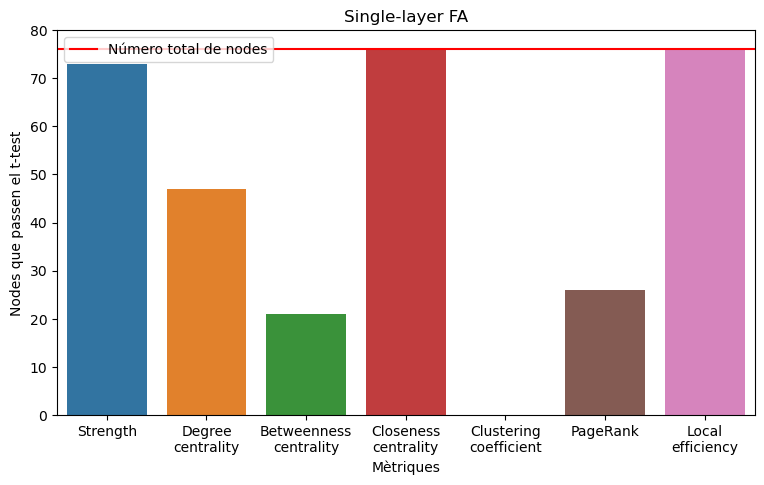

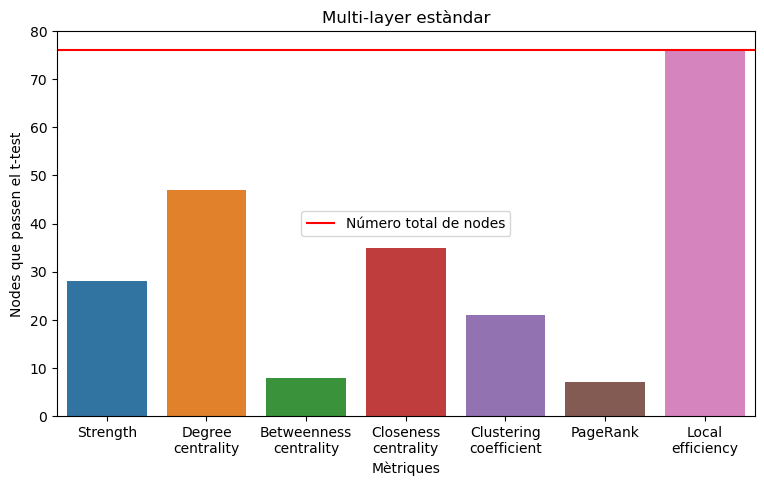

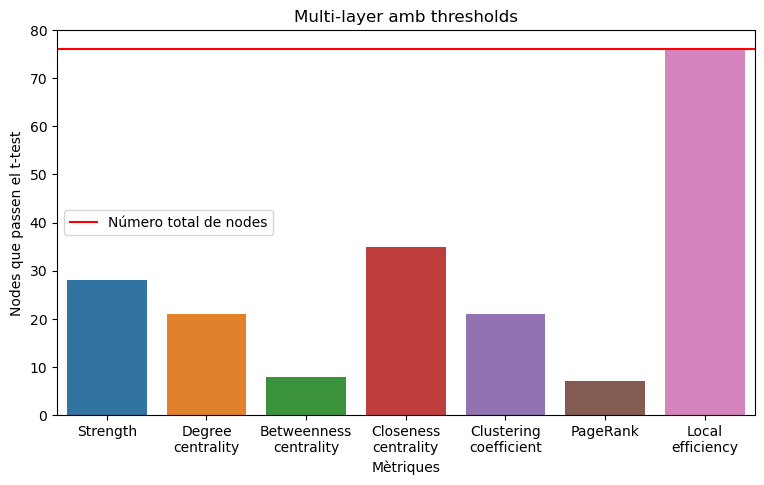

C:\Users\marti\AppData\Local\Temp\ipykernel_28448\3166678364.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _ , p_value = ttest_ind(HV_values, PwMS_values, equal_var=False)


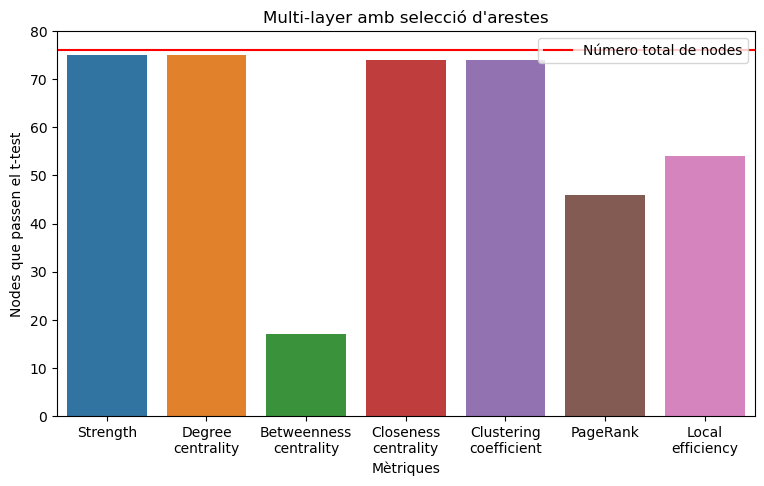

C:\Users\marti\AppData\Local\Temp\ipykernel_28448\3166678364.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _ , p_value = ttest_ind(HV_values, PwMS_values, equal_var=False)


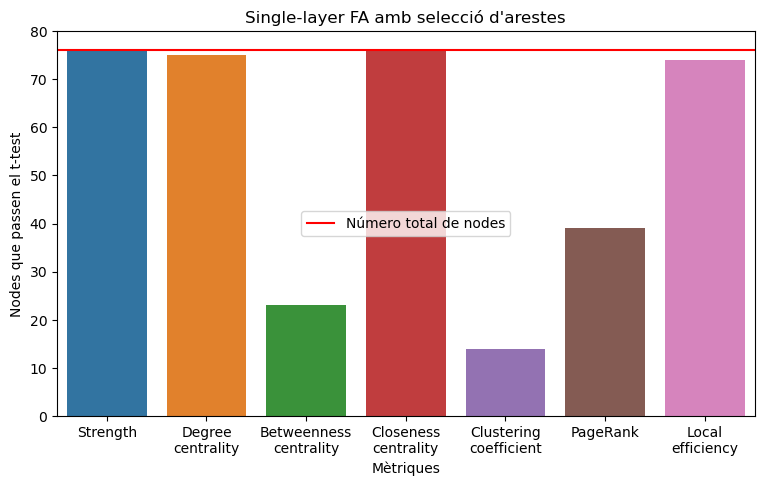

C:\Users\marti\AppData\Local\Temp\ipykernel_28448\3166678364.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _ , p_value = ttest_ind(HV_values, PwMS_values, equal_var=False)


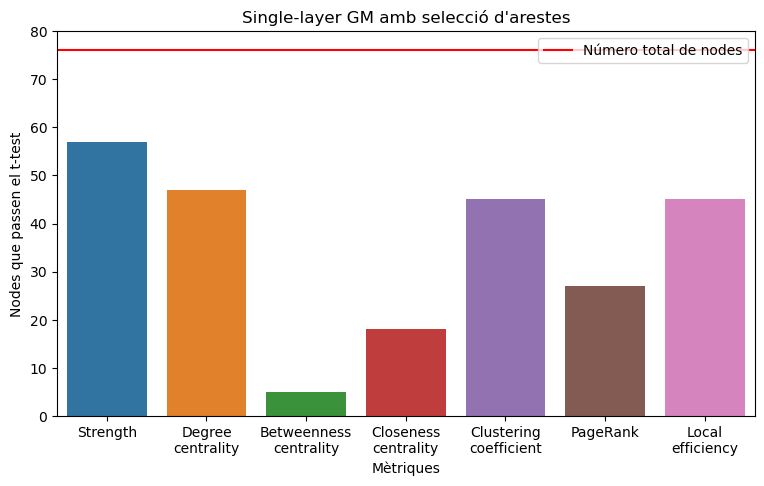

C:\Users\marti\AppData\Local\Temp\ipykernel_28448\3166678364.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _ , p_value = ttest_ind(HV_values, PwMS_values, equal_var=False)


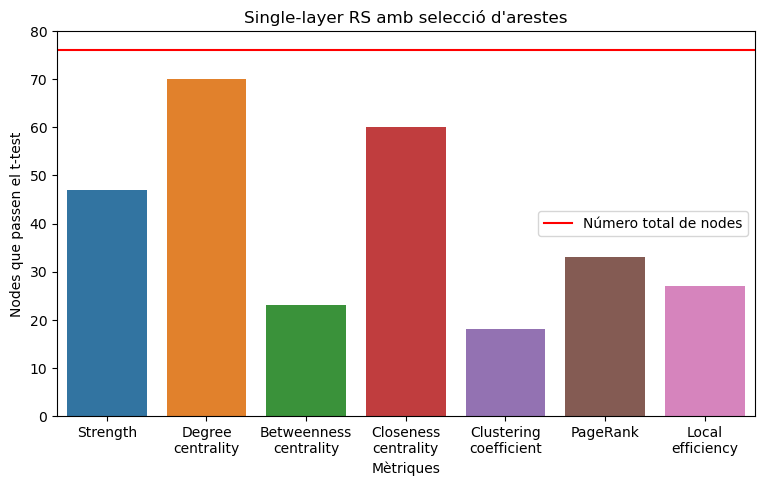

In [ ]:
for i in range(len(networks)):
    n_nodes = []
    for metric in metrics[i].keys():
        p_values = get_p_values_graph_metrics(metrics[i][metric])
        nodes_t_test = np.where(p_values<0.05)[0].shape[0]
        n_nodes.append(nodes_t_test)
    df = pd.DataFrame({'NumNodesTtest': n_nodes, 'Mètriques': metrics[i].keys()})
    df['Mètriques'] = df['Mètriques'].str.replace(' ', '\n')

    plt.figure(figsize=(9, 5))
    ax = sns.barplot(x='Mètriques', y='NumNodesTtest', data=df)
    plt.axhline(NUM_NODES, color='red', linestyle='-', label='Número total de nodes')
    ax.set_ylim(0, 80)
    plt.xlabel('Mètriques')
    plt.ylabel('Nodes que passen el t-test')
    plt.title(network_names[i])
    plt.legend()
    plt.show()

#### Relació entre les mètriques i l'EDSS

In [ ]:
print("Mitjana i desviació estàndar de les correlacions entre cada mètrica i l'EDSS:", "\n")
for i in range(len(networks)):
    print("Xarxa: ",network_names[i])
    for metric in metrics[i].keys():
        correlations = get_edss_correlations(metrics[i][metric])
        print(metric,":")
        print(" - Mitjana: ",round(np.mean(correlations), 3))
        print(" - Desv est: ",round(np.std(correlations), 3))
    print("\n")

Mitjana i desviació estàndar de les correlacions entre cada mètrica i l'EDSS: 

Xarxa:  Single-layer FA
Strength :
 - Mitjana:  0.303
 - Desv est:  0.057
Degree centrality :
 - Mitjana:  0.199
 - Desv est:  0.1
Betweenness centrality :
 - Mitjana:  0.105
 - Desv est:  0.077
Closeness centrality :
 - Mitjana:  0.284
 - Desv est:  0.042
Clustering coefficient :
 - Mitjana:  0.141
 - Desv est:  0.056
PageRank :
 - Mitjana:  0.131
 - Desv est:  0.078
Local efficiency :
 - Mitjana:  0.288
 - Desv est:  0.023


Xarxa:  Multi-layer estàndar
Strength :
 - Mitjana:  0.191
 - Desv est:  0.069
Degree centrality :
 - Mitjana:  0.198
 - Desv est:  0.101
Betweenness centrality :
 - Mitjana:  0.088
 - Desv est:  0.066
Closeness centrality :
 - Mitjana:  0.17
 - Desv est:  0.065
Clustering coefficient :
 - Mitjana:  0.152
 - Desv est:  0.064
PageRank :
 - Mitjana:  0.07
 - Desv est:  0.056
Local efficiency :
 - Mitjana:  0.227
 - Desv est:  0.003


Xarxa:  Multi-layer amb thresholds
Strength :
 - Mitj

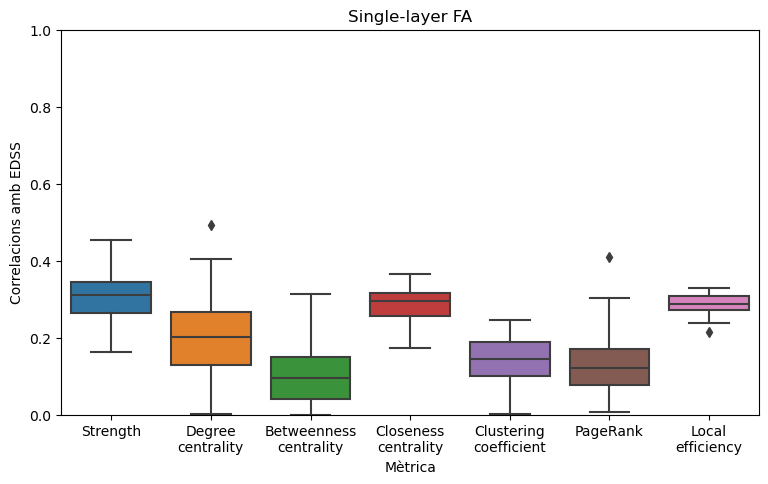

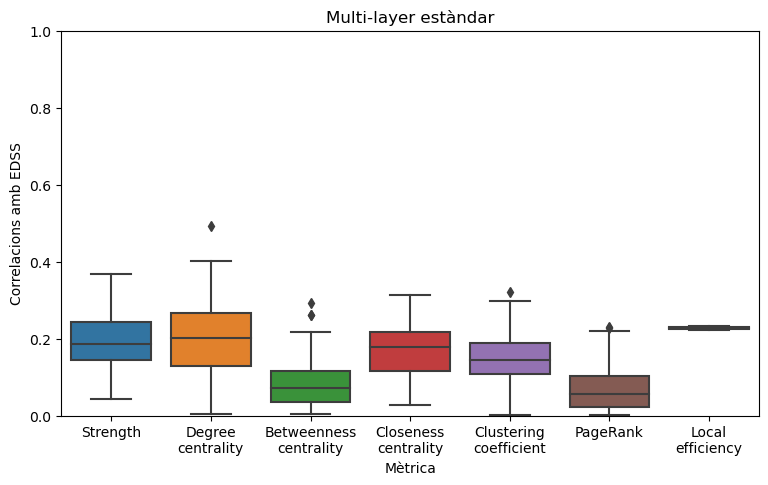

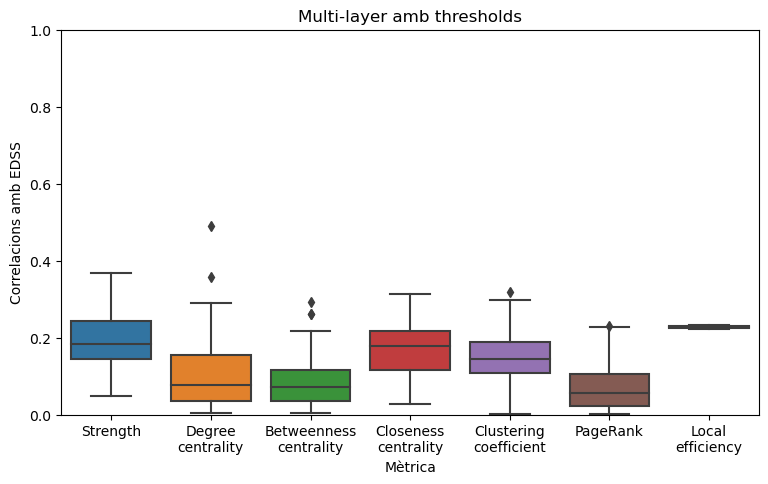

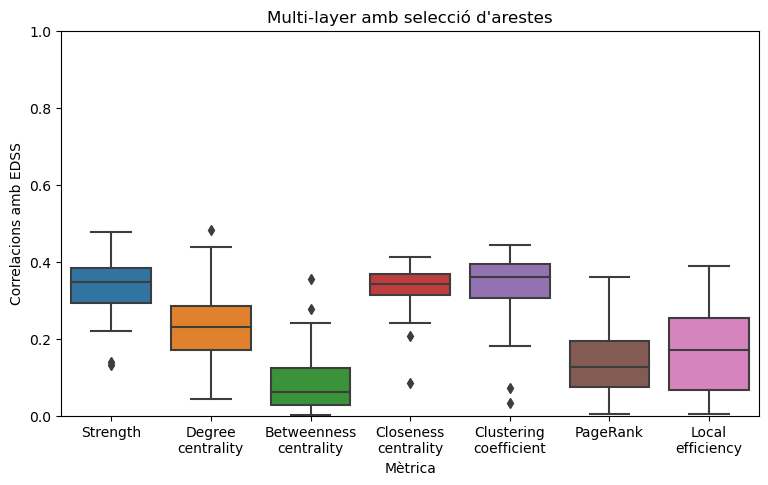

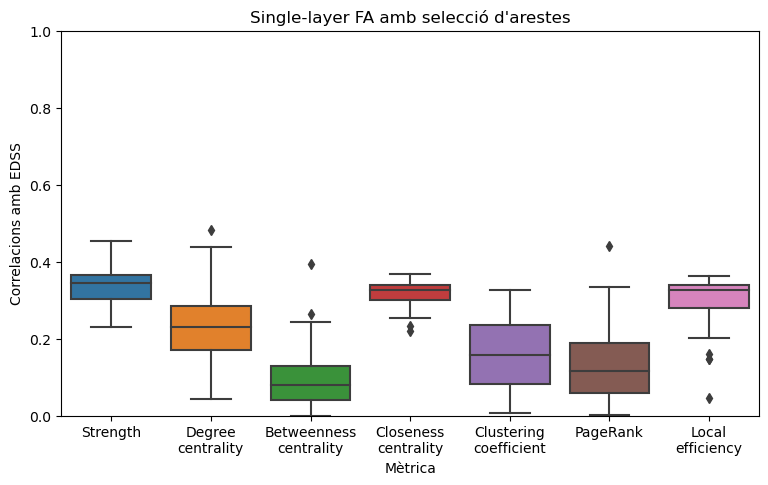

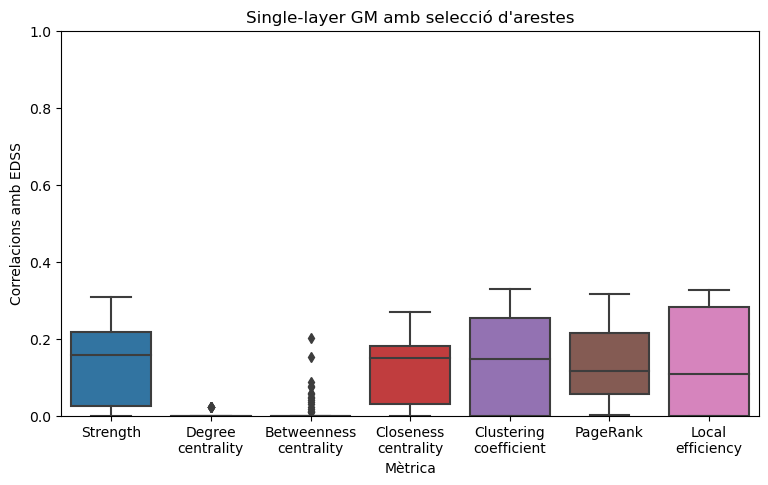

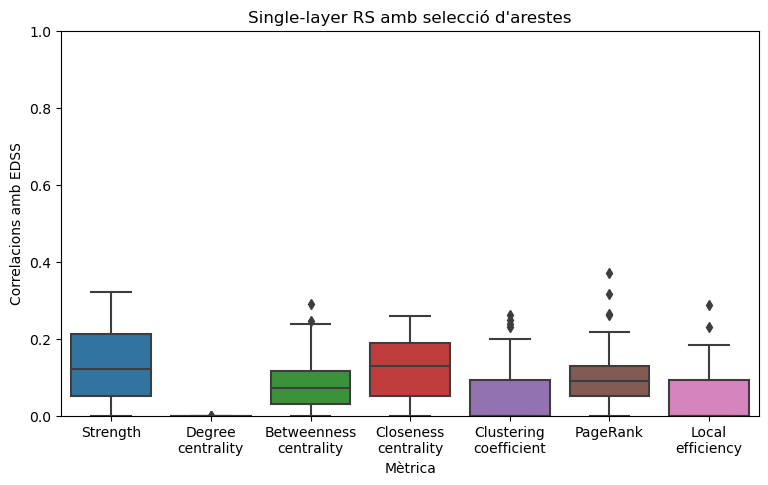

In [ ]:
for i in range(len(networks)):
    metrics_correlations = []
    for metric in metrics[i].keys():
        correlations = get_edss_correlations(metrics[i][metric])
        metrics_correlations.append(correlations)
    df = pd.DataFrame({'Mètrica': np.repeat(list(metrics[i].keys()), NUM_NODES),'Value': np.concatenate(metrics_correlations)})
    df['Mètrica'] = df['Mètrica'].str.replace(' ', '\n')

    plt.figure(figsize=(9, 5))
    sns.boxplot(x='Mètrica', y='Value', data=df)
    plt.xlabel('Mètrica')
    plt.ylabel('Correlacions amb EDSS')
    plt.ylim(0, 1)
    plt.title(network_names[i])
    plt.show()

## CREACIÓ DE MODELS

Executar la següent casella per llegir directament dels fitxers csv els valors de les mètriques de graf

In [103]:
metrics = []
for i in range(len(networks)):
    path = data_directory+"metrics_values/networks_"+str(i)

    metrics_aux = {}
    metrics_aux['Strength'] = np.loadtxt(path+"/strength.csv", delimiter=',')
    metrics_aux['Degree centrality'] = np.loadtxt(path+"/degree.csv", delimiter=',')
    metrics_aux['Betweenness centrality'] = np.loadtxt(path+"/betweenness.csv", delimiter=',')
    metrics_aux['Closeness centrality'] = np.loadtxt(path+"/closeness.csv", delimiter=',')
    metrics_aux['Clustering coefficient'] = np.loadtxt(path+"/clustering.csv", delimiter=',')
    metrics_aux['PageRank'] = np.loadtxt(path+"/pagerank.csv", delimiter=',')
    metrics_aux['Local efficiency'] = np.loadtxt(path+"/local_efficiency.csv", delimiter=',')

    metrics.append(metrics_aux)

### Definició de funcions

Funció per crear els dataframes de les xarxes

In [104]:
def create_dataframe(xarxa):
    # agafar les mètriques
    strength = xarxa['Strength'].copy()
    degree = xarxa['Degree centrality'].copy()
    betweenness = xarxa['Betweenness centrality'].copy()
    closeness = xarxa['Closeness centrality'].copy()
    clustering = xarxa['Clustering coefficient'].copy()
    pagerank = xarxa['PageRank'].copy()
    local_ef = xarxa['Local efficiency'].copy()

    # printejar histogrames de cada mètrica
    sns.histplot(x=strength.flatten(), color ='red', bins=100)
    plt.title('Strength')
    plt.show()

    sns.histplot(x=degree.flatten(), color ='red', bins=100)
    plt.title('Degree centrality')
    plt.show()

    sns.histplot(x=betweenness.flatten(), color ='red', bins=100)
    plt.title('Betweenness centrality')
    plt.show()

    sns.histplot(x=closeness.flatten(), color ='red', bins=100)
    plt.title('Closeness centrality')
    plt.show()

    sns.histplot(x=clustering.flatten(), color ='red', bins=100)
    plt.title('Clustering coefficient')
    plt.show()

    sns.histplot(x=pagerank.flatten(), color ='red', bins=100)
    plt.title('PageRank')
    plt.show()

    sns.histplot(x=local_ef.flatten(), color ='red', bins=100)
    plt.title('Local efficiency')
    plt.show()

    # crear el dataframe
    df = clinical_data.copy()

    strength_cols = []
    degree_cols = []
    betweenness_cols = []
    closeness_cols = []
    clustering_cols = []
    pagerank_cols = []
    local_ef_cols = []

    for i in range(NUM_NODES):
        strength_aux = strength[:,i]
        degree_aux = degree[:,i]
        betweenness_aux = betweenness[:,i]
        closeness_aux = closeness[:,i]
        clustering_aux = clustering[:,i]
        pagerank_aux = pagerank[:,i]
        local_ef_aux = local_ef[:,i]

        strength_nom = "Strength_" + str(i)
        degree_nom = "Degree_" + str(i)
        betweenness_nom = "Betweenness_" + str(i)
        closeness_nom = "Closeness_" + str(i)
        clustering_nom = "Clustering_" + str(i)
        pagerank_nom = "PageRank_" + str(i)
        local_ef_nom = "Local_ef_" + str(i)

        strength_cols.append(pd.Series(strength_aux, name=strength_nom))
        degree_cols.append(pd.Series(degree_aux, name=degree_nom))
        betweenness_cols.append(pd.Series(betweenness_aux, name=betweenness_nom))
        closeness_cols.append(pd.Series(closeness_aux, name=closeness_nom))
        clustering_cols.append(pd.Series(clustering_aux, name=clustering_nom))
        pagerank_cols.append(pd.Series(pagerank_aux, name=pagerank_nom))
        local_ef_cols.append(pd.Series(local_ef_aux, name=local_ef_nom))

    df = pd.concat([df] + strength_cols + degree_cols + betweenness_cols + closeness_cols
                + clustering_cols + pagerank_cols + local_ef_cols, axis=1)

    # Canviem la classe PwMS com a 1 i la classe HV com a 0 per evitar problemes a l'entrenar models
    df['mstype'] = df['mstype'].replace({0: 1, -1: 0})

    return df

Definició de constants amb els noms de les columnes pertanyents a cada mètrica

In [105]:
STRENGTH_COLS = []
for i in range(NUM_NODES):
    STRENGTH_COLS.append("Strength_" + str(i))

DEGREE_COLS = []
for i in range(NUM_NODES):
    DEGREE_COLS.append("Degree_" + str(i))

BETWEENNESS_COLS = []
for i in range(NUM_NODES):
    BETWEENNESS_COLS.append("Betweenness_" + str(i))

CLOSENESS_COLS = []
for i in range(NUM_NODES):
    CLOSENESS_COLS.append("Closeness_" + str(i))

CLUSTERING_COLS = []
for i in range(NUM_NODES):
    CLUSTERING_COLS.append("Clustering_" + str(i))

PAGERANK_COLS = []
for i in range(NUM_NODES):
    PAGERANK_COLS.append("PageRank_" + str(i))

LOCAL_EF_COLS = []
for i in range(NUM_NODES):
    LOCAL_EF_COLS.append("Local_ef_" + str(i))

Funció per avaluar un model a través de diverses mètriques i gràfiques

In [128]:
def evaluate_model(model, x, y, folds):
    scores = cross_val_score(model, x, y, cv=folds, scoring="accuracy")
    print("Accuracy: ", scores.mean())
    scores = cross_val_score(model, x, y, cv=folds, scoring="precision")
    print("Precision: ", scores.mean())
    scores = cross_val_score(model, x, y, cv=folds, scoring="recall")
    print("Recall: ", scores.mean())
    scores = cross_val_score(model, x, y, cv=folds, scoring="f1")
    print("F1-score: ", scores.mean())
    print("\n")

    preds = cross_val_predict(model, x, y, cv=folds)
    print(classification_report(y, preds, zero_division=0))
    print("\n")

    cf_m = confusion_matrix(y, preds)
    plt.figure()
    sns.heatmap(cf_m,annot=True,fmt='g')
    plt.xlabel('Classe predita')
    plt.ylabel('Classe real')
    plt.title('Matriu de confusió')
    plt.show()

    proba = cross_val_predict(model, x, y, cv=folds, method='predict_proba')
    precision = {}
    recall = {}
    average_precision = {}
    plt.figure()
    plt.title('Corba Precision-Recall')
    for i in range(2):
        precision[i], recall[i], _ = precision_recall_curve(y == i, proba[:, i])
        average_precision[i] = average_precision_score(y == i, proba[:, i])
        plt.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                            ''.format(i, average_precision[i]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower left")
    print("\n")

    proba = cross_val_predict(model, x, y, cv=folds, method='predict_proba')
    fpr, tpr, _ = roc_curve(y, proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC AUC = '+str(round(roc_auc,2)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Corba ROC')
    plt.legend(loc="lower right")
    plt.show()

### Creació dels dataframes

In [107]:
print("Xarxes:")
for i, xarxa in enumerate(network_names):
    print(i,": ",xarxa)

Xarxes:
0 :  Single-layer FA
1 :  Multi-layer estàndar
2 :  Multi-layer amb thresholds
3 :  Multi-layer amb selecció d'arestes
4 :  Single-layer FA amb selecció d'arestes
5 :  Single-layer GM amb selecció d'arestes
6 :  Single-layer RS amb selecció d'arestes


#### 0: Single-layer FA

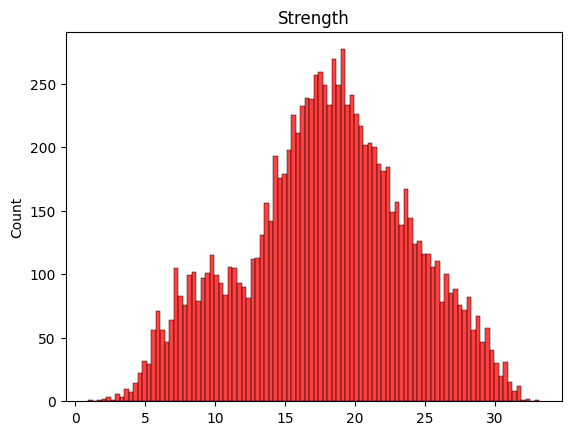

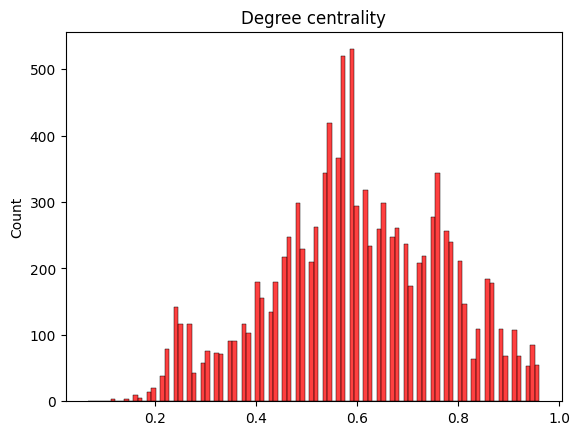

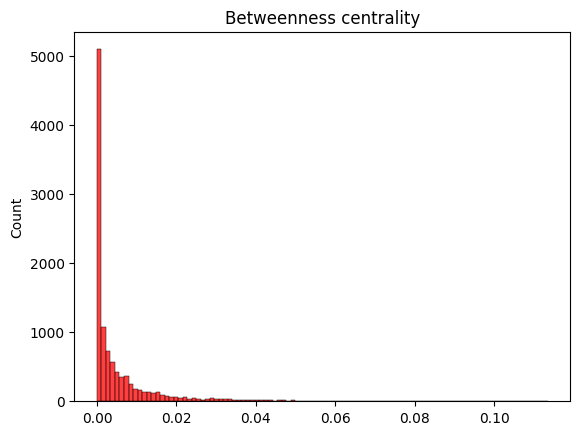

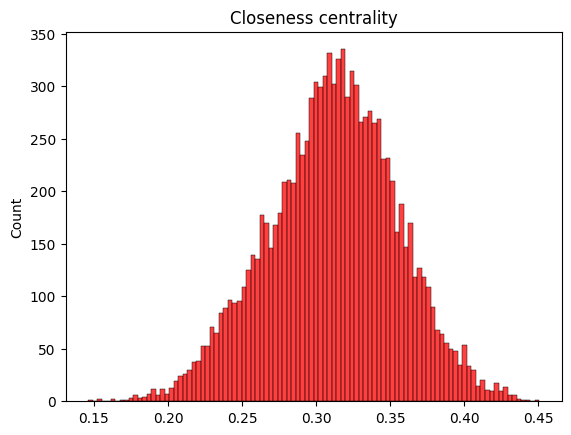

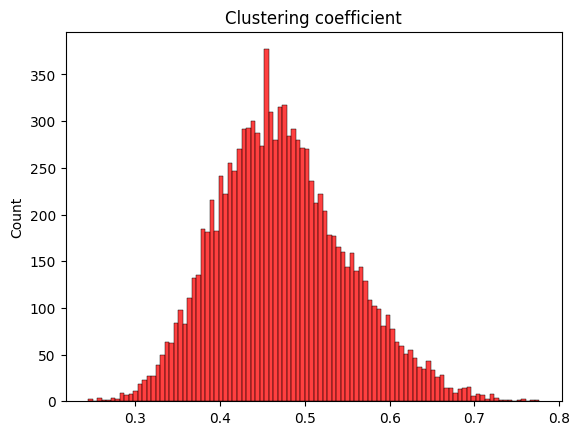

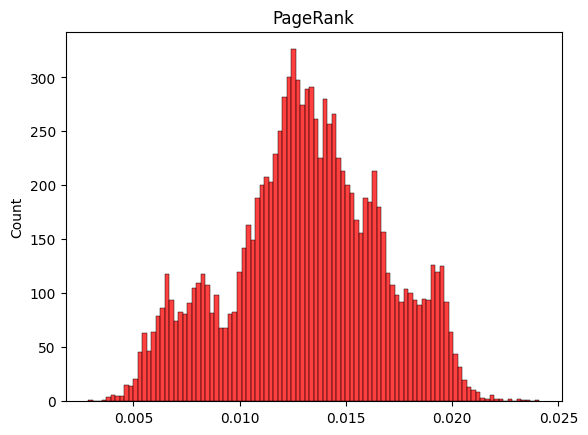

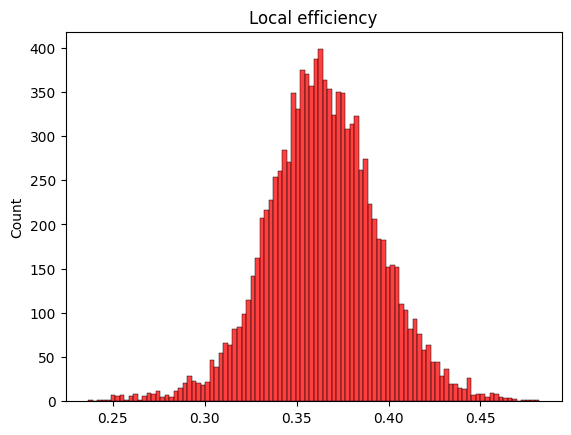

In [108]:
df0 = create_dataframe(metrics[0].copy())

In [109]:
df0

mstype  edss  Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  \
0         1   3.0   16.404345   19.934244   16.880274    6.925231   14.868683   
1         1   1.5   14.564263   17.414928   15.134213    5.905397   12.780386   
2         1   2.0   14.640516   16.196333   15.413794    6.149666   12.940156   
3         1   3.0   14.117944   17.741166   17.888479    6.445422   17.751425   
4         1   2.0   13.724987   16.343087   14.283896    6.545274   12.585314   
..      ...   ...         ...         ...         ...         ...         ...   
138       0   0.0   16.655485   19.146539   16.700146    7.617889   15.122495   
139       0   0.0   15.134368   18.966089   17.424447    7.922187   15.291565   
140       0   0.0   16.325812   19.457503   17.617547    6.979297   16.901045   
141       0   0.0   14.223149   19.131217   14.883435    6.763010   12.154140   
142       0   0.0   17.473569   20.529582   17.007257    6.597956   17.569032   

     Strength_5  Strength_6  Strength_7  ...  Local_ef_66  Local_ef_67  \
0     27.237312   18.612786   23.729318  ...     0.404505     0.368982   
1     25.289463   17.176270   23.635124  ...     0.390676     0.350216   
2     24.447312   15.987123   21.234674  ...     0.362479     0.321137   
3     26.187135   18.658421   24.892061  ...     0.394411     0.362457   
4     22.759765   15.292995   20.699393  ...     0.363037     0.324367   
..          ...         ...         ...  ...          ...          ...   
138   25.956406   16.590008   23.546366  ...     0.399674     0.374968   
139   30.148821   19.847248   22.669545  ...     0.411943     0.374835   
140   28.585863   19.822967   25.647492  ...     0.425353     0.391793   
141   26.442900   15.966015   21.184424  ...     0.395527     0.353635   
142   27.068842   19.064165   26.884717  ...     0.425194     0.381919   

     Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  \
0       0.361477     0.370647     0.372325     0.368709     0.376409   
1       0.346396     0.361291     0.357996     0.347928     0.357892   
2       0.323869     0.336609     0.335159     0.321751     0.331129   
3       0.366912     0.369140     0.364528     0.365627     0.365138   
4       0.328578     0.336544     0.335277     0.327869     0.324115   
..           ...          ...          ...          ...          ...   
138     0.366035     0.369722     0.374695     0.371155     0.375221   
139     0.369715     0.386245     0.384630     0.378543     0.378105   
140     0.381743     0.395079     0.393692     0.389168     0.392857   
141     0.360722     0.365122     0.365420     0.356498     0.359573   
142     0.381989     0.395951     0.394887     0.384462     0.386017   

     Local_ef_73  Local_ef_74  Local_ef_75  
0       0.394584     0.444697     0.375068  
1       0.380326     0.444446     0.358053  
2       0.353703     0.396242     0.331454  
3       0.386367     0.439351     0.366825  
4       0.350394     0.407564     0.332249  
..           ...          ...          ...  
138     0.392292     0.451109     0.377678  
139     0.405994     0.462343     0.380065  
140     0.423258     0.477610     0.394553  
141     0.382538     0.440241     0.366621  
142     0.410103     0.459256     0.390308  

[143 rows x 534 columns]

#### 1: Multi-layer estàndar

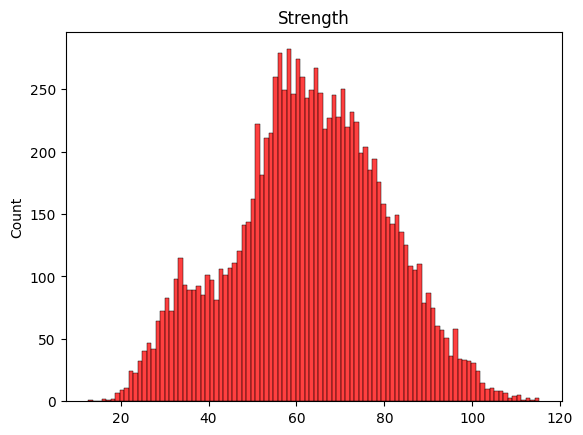

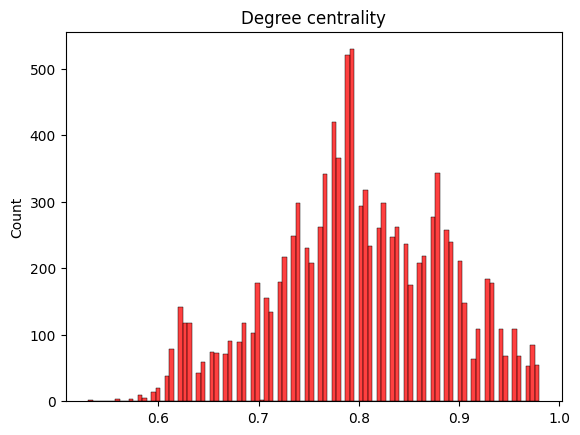

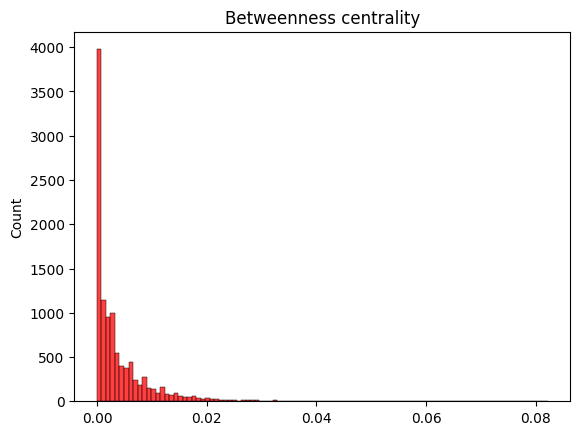

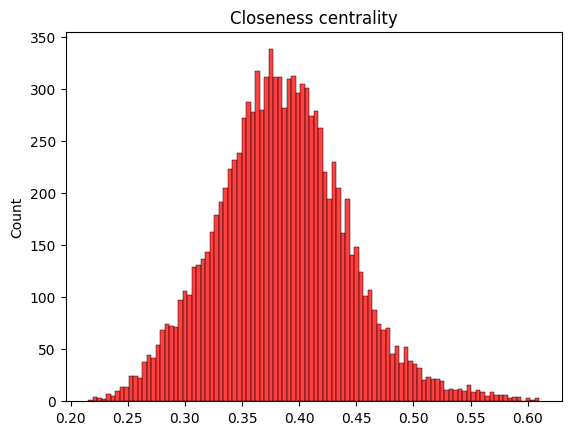

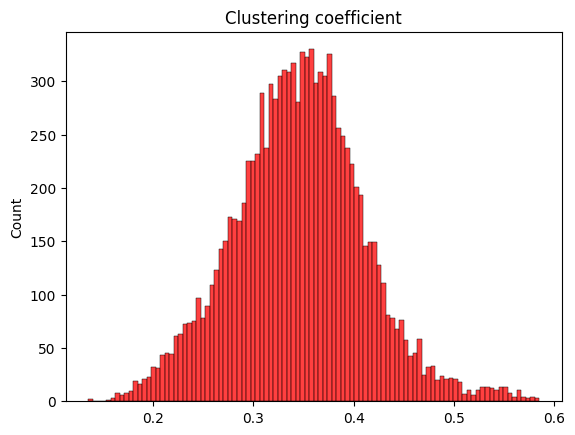

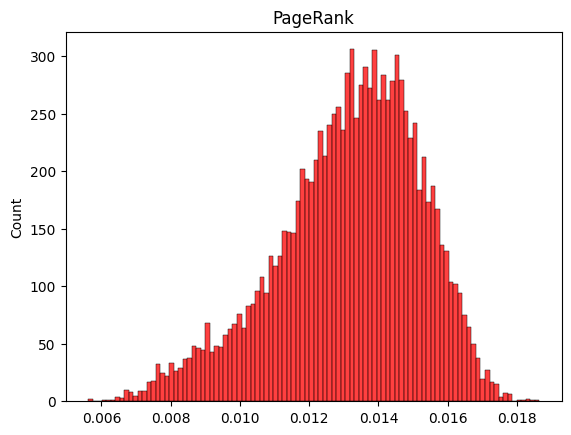

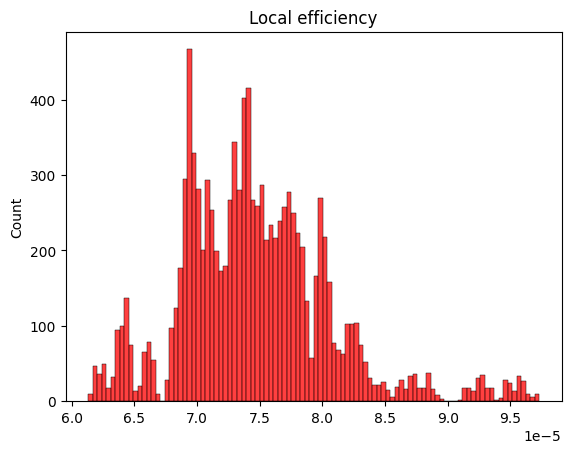

In [110]:
df1 = create_dataframe(metrics[1].copy())

In [111]:
df1

mstype  edss  Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  \
0         1   3.0   60.529405   69.378024   53.034299   37.775491   55.286493   
1         1   1.5   60.377519   70.035300   47.401603   29.757332   41.984186   
2         1   2.0   45.492595   57.800087   48.847820   37.088257   39.745758   
3         1   3.0   48.016134   60.627154   56.706096   29.853317   62.177411   
4         1   2.0   55.826084   66.073892   48.352602   36.703653   57.397551   
..      ...   ...         ...         ...         ...         ...         ...   
138       0   0.0   49.106890   56.347892   54.122550   31.622556   55.863777   
139       0   0.0   46.453662   61.994366   51.950492   40.058479   56.371708   
140       0   0.0   62.282425   71.640226   58.903008   36.322777   50.753535   
141       0   0.0   59.343661   70.267884   56.277826   33.731075   63.004345   
142       0   0.0   54.015524   71.268138   60.506873   38.234905   59.307604   

     Strength_5  Strength_6  Strength_7  ...  Local_ef_66  Local_ef_67  \
0     80.007689   63.214293   69.931481  ...     0.000073     0.000073   
1     85.500512   68.040950   71.353002  ...     0.000075     0.000075   
2     75.855531   50.843964   61.741032  ...     0.000065     0.000065   
3     74.583873   62.011536   70.183489  ...     0.000071     0.000071   
4     78.772301   65.785631   58.429581  ...     0.000078     0.000078   
..          ...         ...         ...  ...          ...          ...   
138   73.401377   59.107137   68.994738  ...     0.000071     0.000071   
139   82.817353   66.312657   68.390095  ...     0.000075     0.000075   
140   93.443879   59.548881   73.294128  ...     0.000078     0.000078   
141   87.291414   68.824512   56.039196  ...     0.000077     0.000077   
142   85.930816   63.636849   70.460936  ...     0.000074     0.000074   

     Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  \
0       0.000074     0.000073     0.000073     0.000073     0.000073   
1       0.000076     0.000075     0.000075     0.000075     0.000075   
2       0.000066     0.000066     0.000065     0.000066     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000079     0.000079     0.000078     0.000078     0.000078   
141     0.000078     0.000077     0.000077     0.000077     0.000077   
142     0.000075     0.000075     0.000074     0.000074     0.000075   

     Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000073     0.000073     0.000073  
1       0.000075     0.000076     0.000075  
2       0.000066     0.000066     0.000066  
3       0.000071     0.000071     0.000071  
4       0.000078     0.000078     0.000078  
..           ...          ...          ...  
138     0.000071     0.000072     0.000071  
139     0.000075     0.000075     0.000075  
140     0.000079     0.000079     0.000078  
141     0.000077     0.000078     0.000078  
142     0.000075     0.000075     0.000075  

[143 rows x 534 columns]

#### 2: Multi-layer amb thresholds

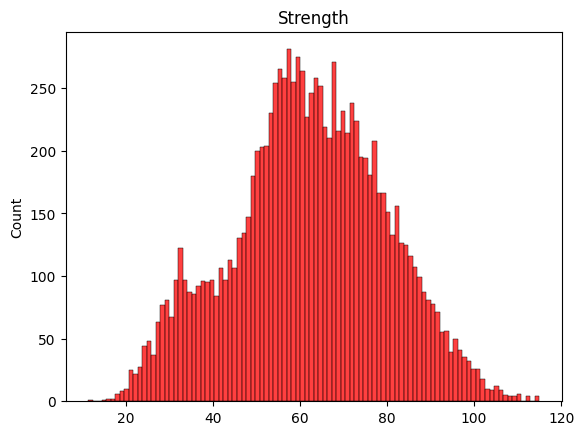

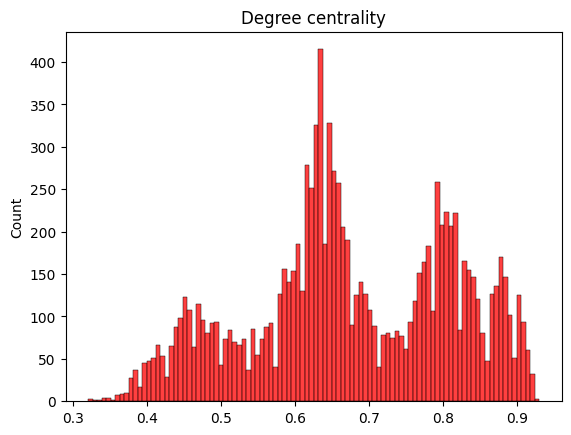

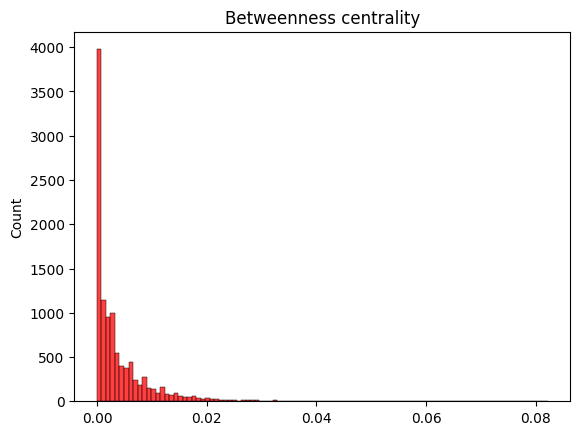

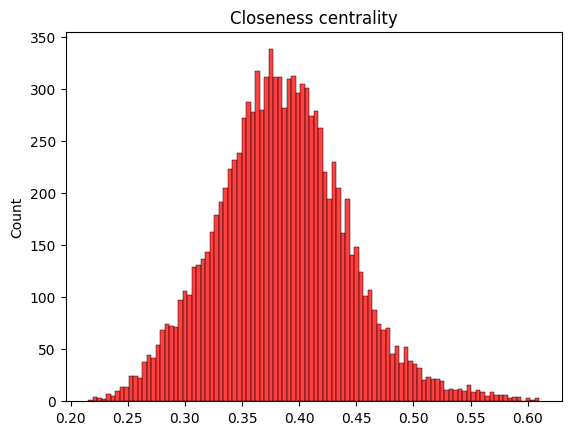

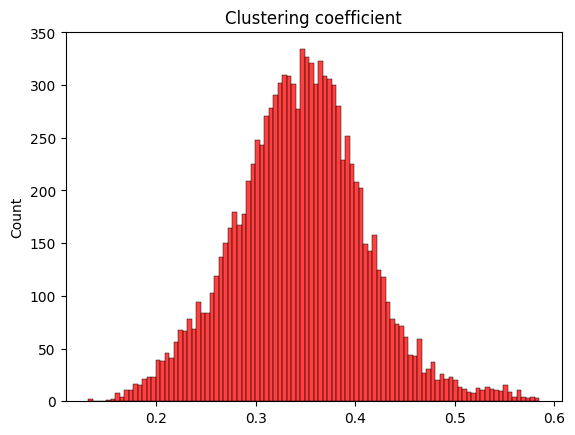

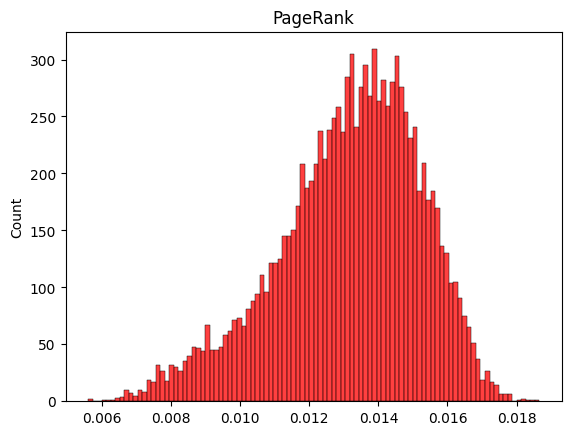

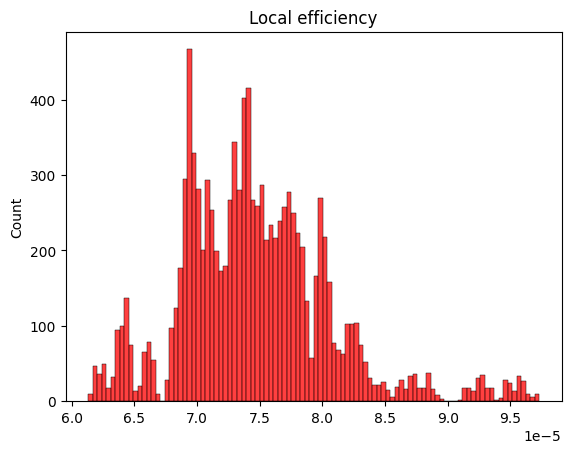

In [112]:
df2 = create_dataframe(metrics[2].copy())

In [113]:
df2

mstype  edss  Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  \
0         1   3.0   59.546602   68.333008   52.062053   36.739089   54.399312   
1         1   1.5   59.342370   69.089420   46.414456   28.759438   41.218641   
2         1   2.0   44.482329   56.744913   47.792154   36.080874   38.740484   
3         1   3.0   46.960781   59.721461   55.798446   28.772582   61.328655   
4         1   2.0   54.790684   65.087871   47.325377   35.609662   56.441072   
..      ...   ...         ...         ...         ...         ...         ...   
138       0   0.0   48.050861   55.402142   53.238721   30.622538   55.201940   
139       0   0.0   45.391052   61.082332   51.016888   39.196244   55.434633   
140       0   0.0   61.280921   70.667780   57.908244   35.386812   49.842565   
141       0   0.0   58.335901   69.351670   55.355230   32.585370   62.220438   
142       0   0.0   52.966774   70.356110   59.456978   37.312291   58.239141   

     Strength_5  Strength_6  Strength_7  ...  Local_ef_66  Local_ef_67  \
0     79.505457   62.886745   68.902278  ...     0.000073     0.000073   
1     85.061355   67.663033   70.354827  ...     0.000075     0.000075   
2     75.261471   50.185999   60.596573  ...     0.000065     0.000065   
3     74.071169   61.505285   69.114256  ...     0.000071     0.000071   
4     78.020789   65.359995   57.327700  ...     0.000078     0.000078   
..          ...         ...         ...  ...          ...          ...   
138   72.899173   58.730404   67.882382  ...     0.000071     0.000071   
139   82.234660   65.822946   67.285455  ...     0.000075     0.000075   
140   92.770859   58.987973   72.287588  ...     0.000078     0.000078   
141   86.858121   68.393011   55.036246  ...     0.000077     0.000077   
142   85.348509   63.064644   69.417201  ...     0.000074     0.000074   

     Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  \
0       0.000074     0.000073     0.000073     0.000073     0.000073   
1       0.000076     0.000075     0.000075     0.000075     0.000075   
2       0.000066     0.000066     0.000065     0.000066     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000079     0.000079     0.000078     0.000078     0.000078   
141     0.000078     0.000077     0.000077     0.000077     0.000077   
142     0.000075     0.000075     0.000074     0.000074     0.000075   

     Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000073     0.000073     0.000073  
1       0.000075     0.000076     0.000075  
2       0.000066     0.000066     0.000066  
3       0.000071     0.000071     0.000071  
4       0.000078     0.000078     0.000078  
..           ...          ...          ...  
138     0.000071     0.000072     0.000071  
139     0.000075     0.000075     0.000075  
140     0.000079     0.000079     0.000078  
141     0.000077     0.000078     0.000078  
142     0.000075     0.000075     0.000075  

[143 rows x 534 columns]

#### 3: Multi-layer amb selecció d'arestes

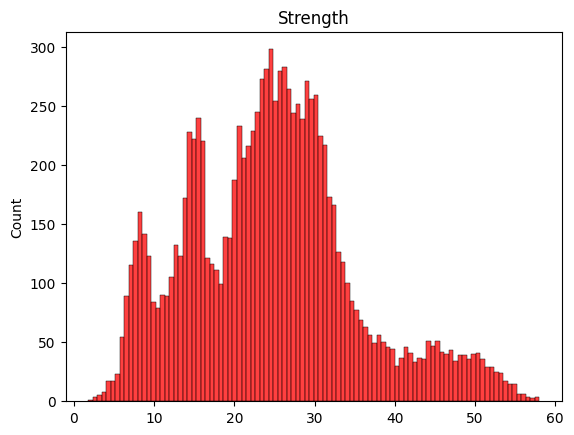

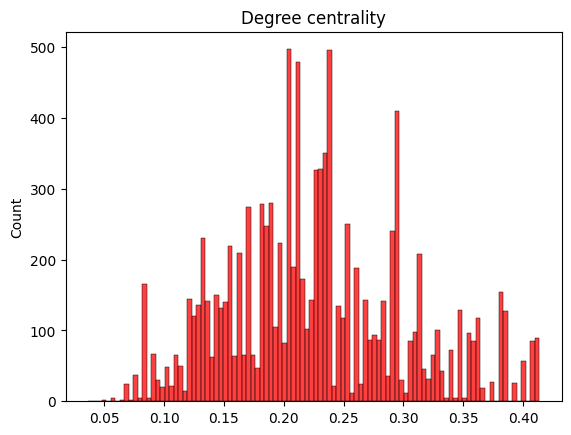

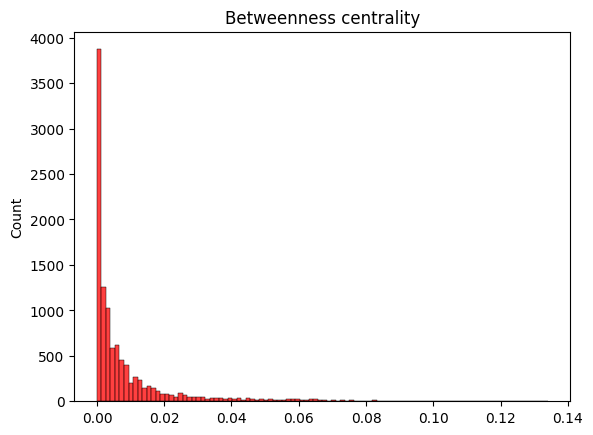

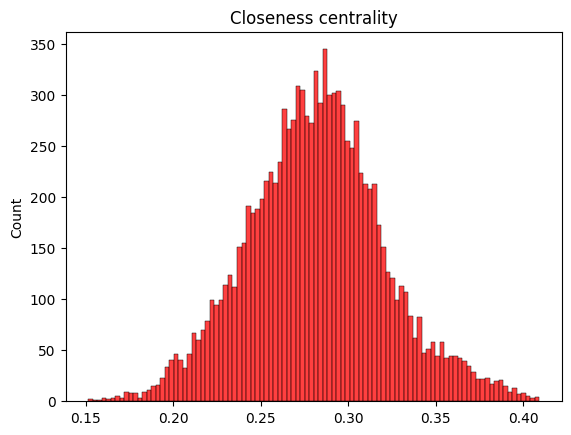

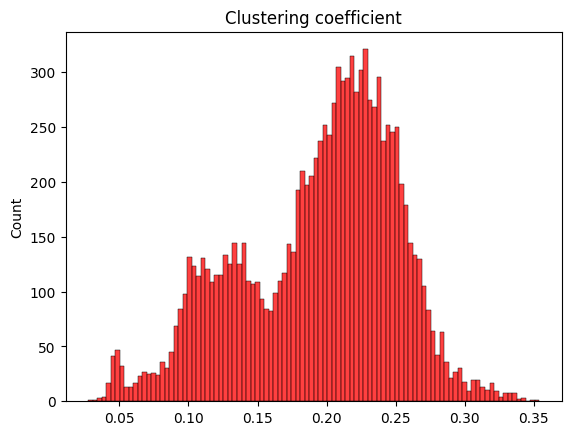

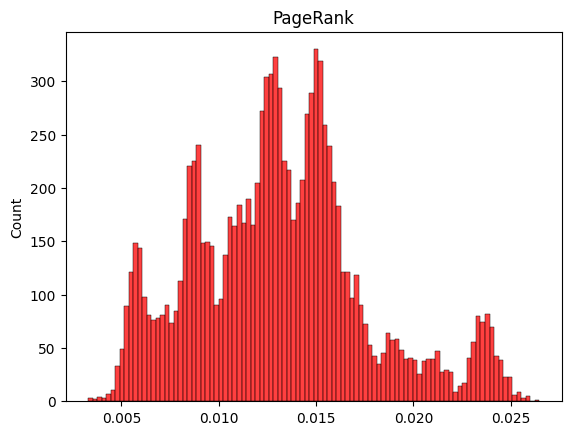

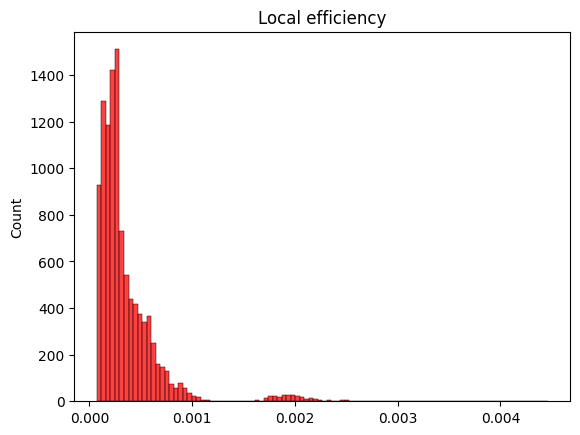

In [114]:
df3 = create_dataframe(metrics[3].copy())

In [115]:
df3

mstype  edss  Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  \
0         1   3.0   20.994261   30.925471   24.331761    8.739466   15.426781   
1         1   1.5   18.270499   28.252429   22.606156    7.017927   14.494215   
2         1   2.0   19.185853   26.076601   23.106392    7.604893   13.965619   
3         1   3.0   17.555392   27.724236   25.222265    8.141513   15.087189   
4         1   2.0   18.061197   26.082460   21.388118    7.251541   14.419552   
..      ...   ...         ...         ...         ...         ...         ...   
138       0   0.0   20.626668   29.667578   25.452363    8.424795   16.317481   
139       0   0.0   20.497556   29.607237   26.984561    8.808661   16.040173   
140       0   0.0   21.848286   30.719663   26.697613    8.892110   16.544635   
141       0   0.0   21.749789   30.565550   25.656699    7.596144   15.226042   
142       0   0.0   21.957683   30.847532   27.245140    7.531913   16.383752   

     Strength_5  Strength_6  Strength_7  ...  Local_ef_66  Local_ef_67  \
0     37.435479   24.132352   34.258167  ...     0.000257     0.000113   
1     37.187900   23.561520   34.653134  ...     0.000267     0.000109   
2     35.914693   22.675379   29.258655  ...     0.000245     0.000100   
3     36.136272   24.221430   34.364947  ...     0.000260     0.000109   
4     35.168434   22.926240   30.256283  ...     0.000231     0.000102   
..          ...         ...         ...  ...          ...          ...   
138   39.603689   25.071249   33.661879  ...     0.000256     0.000115   
139   40.387879   26.671820   35.782592  ...     0.000260     0.000116   
140   41.333551   26.495133   37.485694  ...     0.000272     0.000120   
141   38.552321   26.637520   33.415602  ...     0.000274     0.000113   
142   40.530886   26.713970   36.072178  ...     0.000288     0.000118   

     Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  \
0       0.000547     0.000166     0.000135     0.000114     0.000259   
1       0.000542     0.000160     0.000138     0.000109     0.000252   
2       0.000499     0.000157     0.000130     0.000101     0.000230   
3       0.000589     0.000166     0.000129     0.000109     0.000251   
4       0.000561     0.000163     0.000132     0.000103     0.000235   
..           ...          ...          ...          ...          ...   
138     0.000560     0.000167     0.000138     0.000116     0.000265   
139     0.000564     0.000179     0.000140     0.000116     0.000270   
140     0.000589     0.000177     0.000143     0.000122     0.000280   
141     0.000570     0.000167     0.000136     0.000115     0.000263   
142     0.000594     0.000184     0.000152     0.000118     0.000273   

     Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000160     0.001817     0.000238  
1       0.000156     0.002324     0.000232  
2       0.000143     0.001624     0.000210  
3       0.000155     0.001778     0.000228  
4       0.000145     0.002570     0.000217  
..           ...          ...          ...  
138     0.000162     0.001826     0.000239  
139     0.000165     0.001870     0.000242  
140     0.000171     0.001939     0.000252  
141     0.000163     0.001799     0.000239  
142     0.000168     0.001921     0.000248  

[143 rows x 534 columns]

#### 4: Single-layer FA amb selecció d'arestes

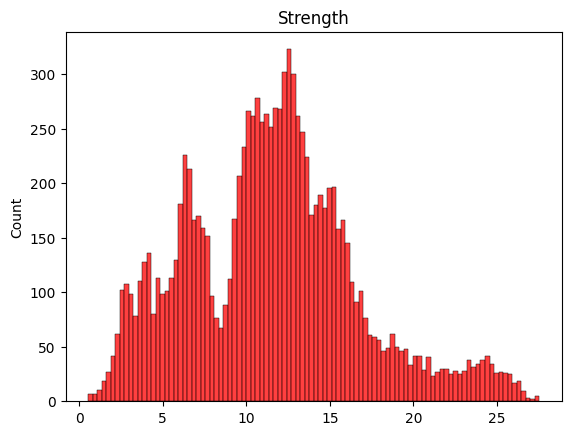

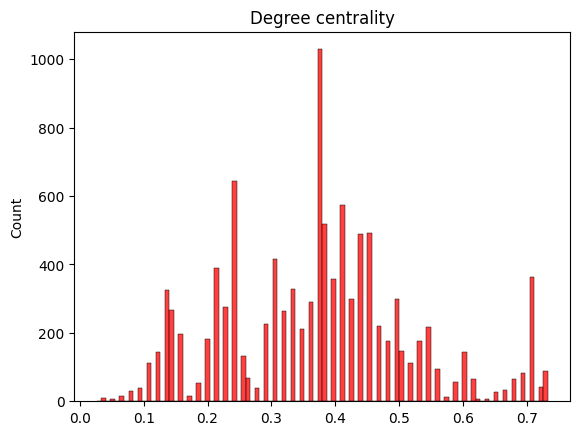

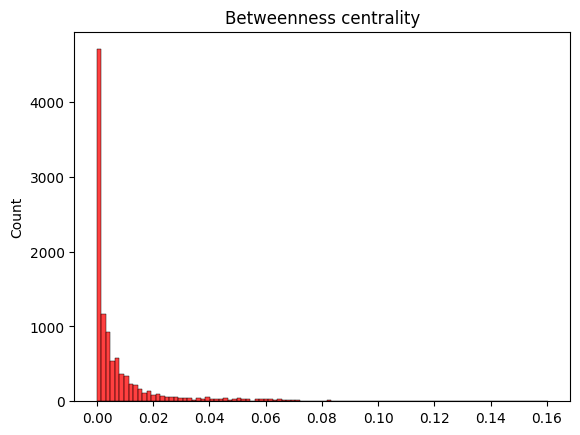

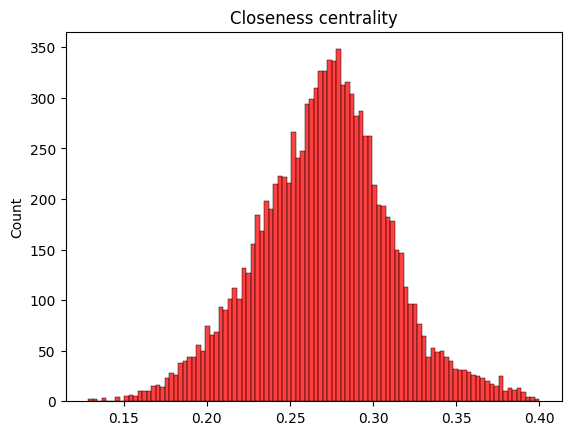

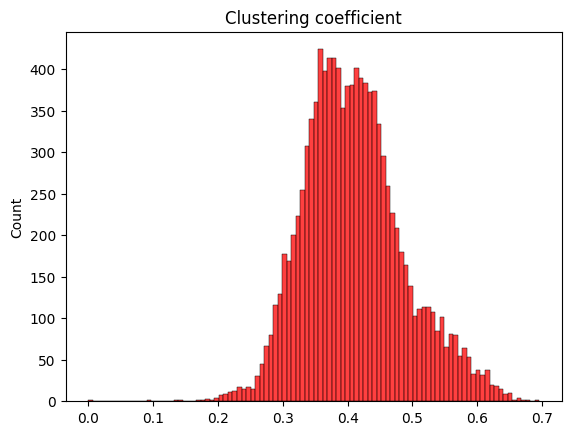

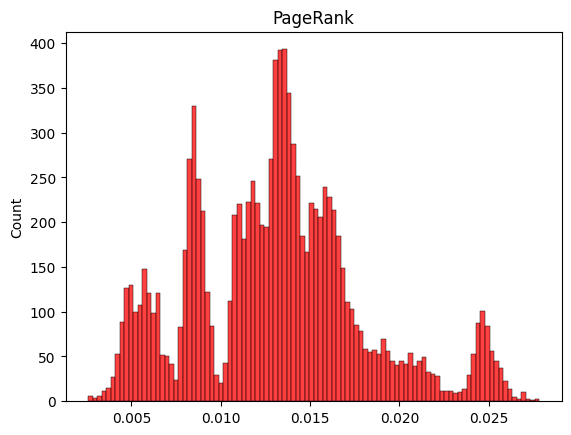

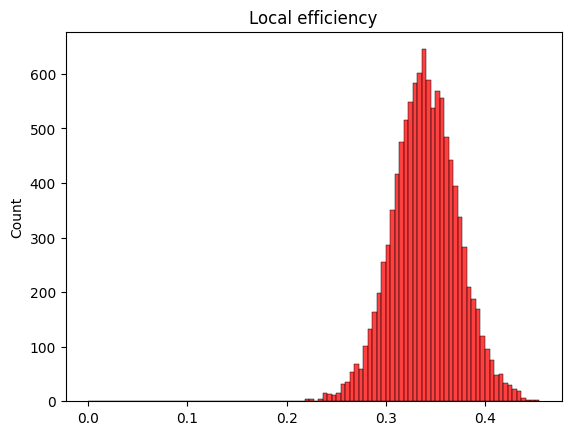

In [116]:
df4 = create_dataframe(metrics[4].copy())

In [117]:
df4

mstype  edss  Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  \
0         1   3.0   10.480743   13.752801   11.985441    3.904961    7.319794   
1         1   1.5    9.125421   12.224827   11.237358    3.135864    6.928494   
2         1   2.0    9.485210   11.516828   11.480320    3.268007    6.716047   
3         1   3.0    8.653527   12.395658   12.526438    3.878158    7.311625   
4         1   2.0    8.975146   11.711132   10.632412    3.428517    6.764899   
..      ...   ...         ...         ...         ...         ...         ...   
138       0   0.0   10.210400   13.607235   12.625968    3.847231    7.684441   
139       0   0.0   10.224815   13.303207   13.329064    3.720480    7.579796   
140       0   0.0   10.683068   13.607567   13.262706    3.932663    7.957666   
141       0   0.0   10.646996   13.581947   12.437514    3.654525    7.073533   
142       0   0.0   10.902477   13.853444   13.395842    3.559879    7.694182   

     Strength_5  Strength_6  Strength_7  ...  Local_ef_66  Local_ef_67  \
0     18.231549   11.152640   16.120626  ...     0.366174     0.347571   
1     17.358168   10.467688   16.112620  ...     0.357558     0.332547   
2     16.971244   10.307904   13.695429  ...     0.331607     0.305925   
3     17.678257   10.845597   16.008630  ...     0.351730     0.338291   
4     16.547216    9.980599   14.377907  ...     0.329242     0.310620   
..          ...         ...         ...  ...          ...          ...   
138   19.197031   10.971642   15.416932  ...     0.369414     0.355628   
139   19.590702   11.606020   16.257541  ...     0.369844     0.354110   
140   19.842491   11.961815   17.120877  ...     0.386842     0.366502   
141   18.396108   11.355159   15.741295  ...     0.370444     0.341450   
142   19.687285   11.936675   17.012043  ...     0.391857     0.361646   

     Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  \
0       0.351386     0.313295     0.329664     0.349992     0.350801   
1       0.329169     0.299250     0.318856     0.334491     0.334007   
2       0.313836     0.282130     0.300120     0.308587     0.305261   
3       0.340875     0.304576     0.314246     0.340844     0.339021   
4       0.313607     0.285811     0.304329     0.313900     0.313439   
..           ...          ...          ...          ...          ...   
138     0.353957     0.313542     0.333481     0.357247     0.358730   
139     0.361299     0.322057     0.333878     0.356393     0.356464   
140     0.374723     0.330124     0.347692     0.369005     0.368466   
141     0.361039     0.314365     0.330653     0.345169     0.345252   
142     0.379568     0.336064     0.356525     0.365260     0.364548   

     Local_ef_73  Local_ef_74  Local_ef_75  
0       0.368719     0.407565     0.350977  
1       0.353251     0.406351     0.337033  
2       0.326794     0.369318     0.307262  
3       0.357157     0.397584     0.338548  
4       0.328739     0.386930     0.311634  
..           ...          ...          ...  
138     0.373808     0.404694     0.356552  
139     0.374923     0.416272     0.353249  
140     0.394220     0.436364     0.368807  
141     0.365292     0.403384     0.348461  
142     0.387621     0.436751     0.367066  

[143 rows x 534 columns]

#### 5: Single-layer GM amb selecció d'arestes

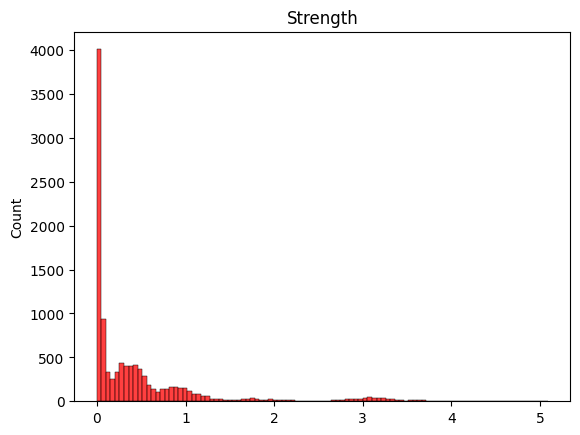

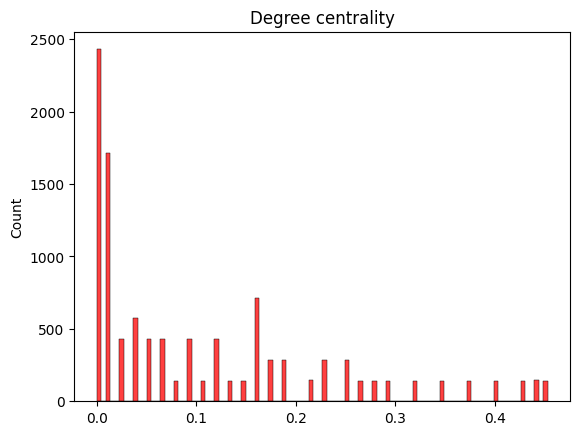

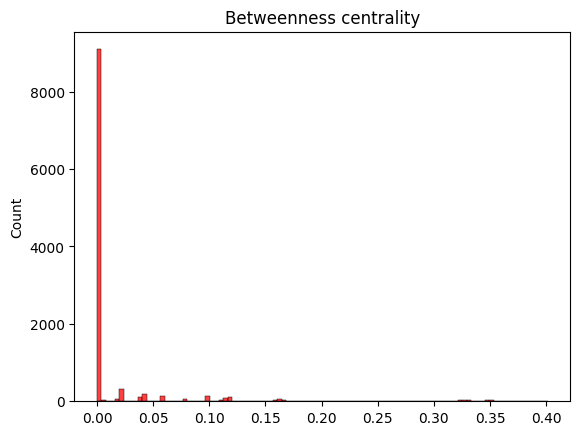

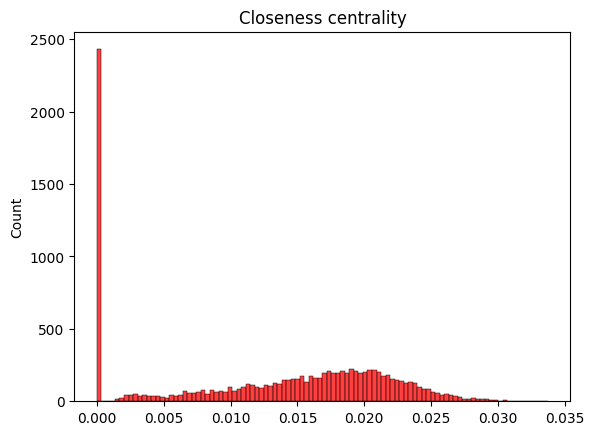

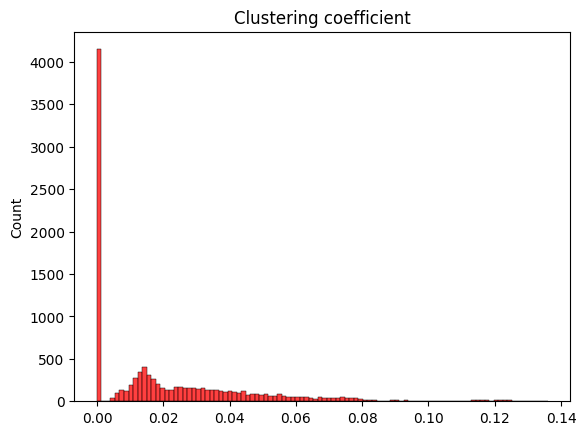

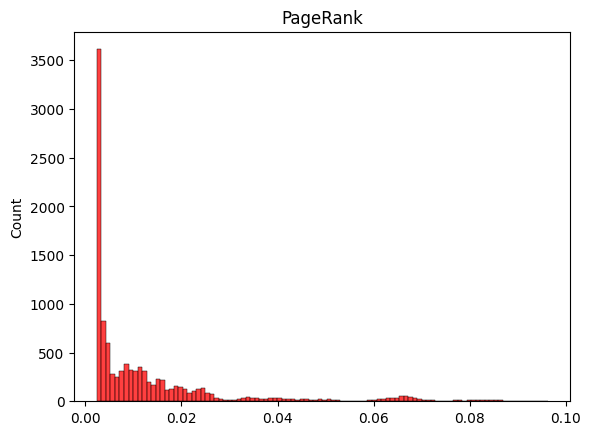

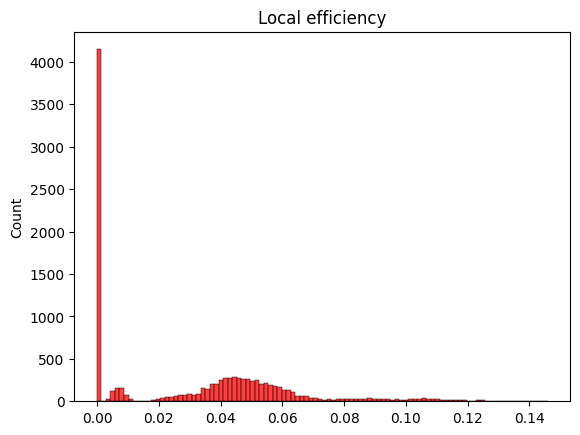

In [118]:
df5 = create_dataframe(metrics[5].copy())

In [119]:
df5

mstype  edss  Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  \
0         1   3.0    0.019841    1.071230         0.0    0.043774    0.393293   
1         1   1.5    0.015682    1.076074         0.0    0.031175    0.422697   
2         1   2.0    0.015422    1.028716         0.0    0.028904    0.333530   
3         1   3.0    0.007920    0.906835         0.0    0.032805    0.353425   
4         1   2.0    0.011251    1.006105         0.0    0.034587    0.316551   
..      ...   ...         ...         ...         ...         ...         ...   
138       0   0.0    0.017122    0.984011         0.0    0.030689    0.398288   
139       0   0.0    0.010652    0.973974         0.0    0.028148    0.350019   
140       0   0.0    0.017408    0.697690         0.0    0.029155    0.342529   
141       0   0.0    0.013695    0.864393         0.0    0.039029    0.406192   
142       0   0.0    0.015928    0.820201         0.0    0.026055    0.298889   

     Strength_5  Strength_6  Strength_7  ...  Local_ef_66  Local_ef_67  \
0           0.0    0.976328         0.0  ...     0.053616     0.029447   
1           0.0    0.898748         0.0  ...     0.042610     0.022855   
2           0.0    0.739178         0.0  ...     0.043119     0.021756   
3           0.0    0.660863         0.0  ...     0.036749     0.018812   
4           0.0    0.788985         0.0  ...     0.037583     0.020567   
..          ...         ...         ...  ...          ...          ...   
138         0.0    0.755185         0.0  ...     0.044078     0.024908   
139         0.0    0.754866         0.0  ...     0.040176     0.022320   
140         0.0    0.706787         0.0  ...     0.042352     0.022598   
141         0.0    0.836240         0.0  ...     0.042278     0.021248   
142         0.0    0.698201         0.0  ...     0.040608     0.021907   

     Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  \
0            0.0     0.048761     0.122305     0.062666          0.0   
1            0.0     0.045030     0.108926     0.058505          0.0   
2            0.0     0.037138     0.105784     0.047611          0.0   
3            0.0     0.034628     0.093252     0.044173          0.0   
4            0.0     0.036909     0.101007     0.047629          0.0   
..           ...          ...          ...          ...          ...   
138          0.0     0.037907     0.103998     0.048492          0.0   
139          0.0     0.038711     0.107093     0.051292          0.0   
140          0.0     0.036792     0.108316     0.048832          0.0   
141          0.0     0.040721     0.112127     0.052049          0.0   
142          0.0     0.036940     0.101944     0.048015          0.0   

     Local_ef_73  Local_ef_74  Local_ef_75  
0       0.051184          0.0          0.0  
1       0.047240          0.0          0.0  
2       0.040166          0.0          0.0  
3       0.035551          0.0          0.0  
4       0.037390          0.0          0.0  
..           ...          ...          ...  
138     0.038634          0.0          0.0  
139     0.042021          0.0          0.0  
140     0.040443          0.0          0.0  
141     0.041713          0.0          0.0  
142     0.039865          0.0          0.0  

[143 rows x 534 columns]

#### 6: Single-layer RS amb selecció d'arestes

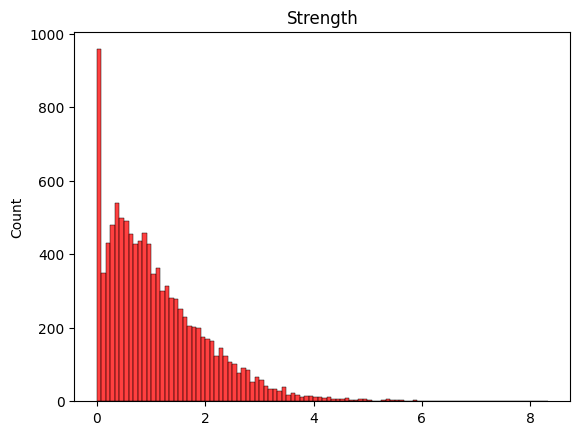

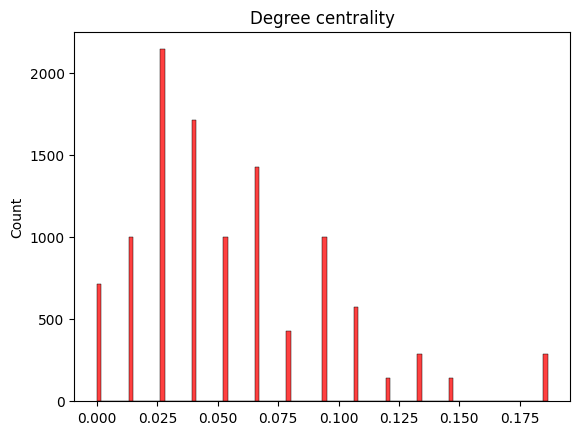

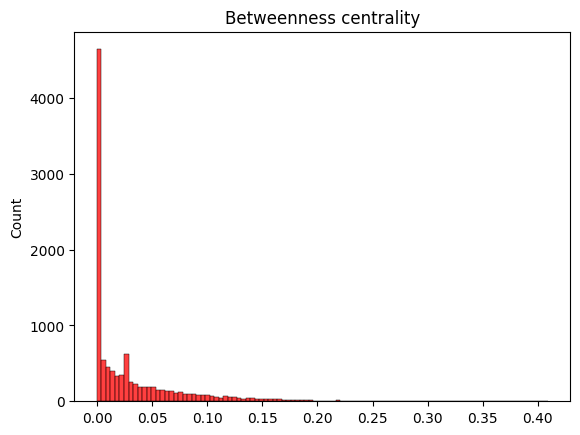

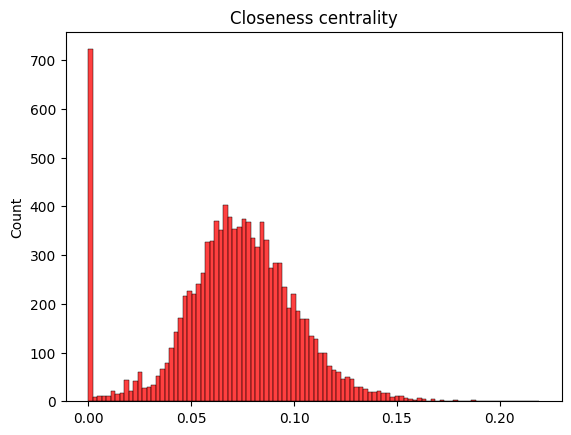

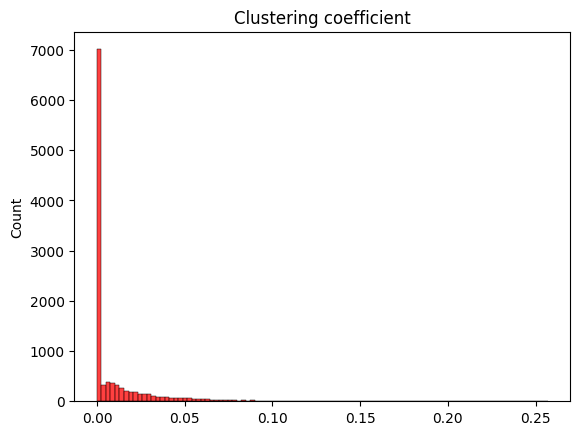

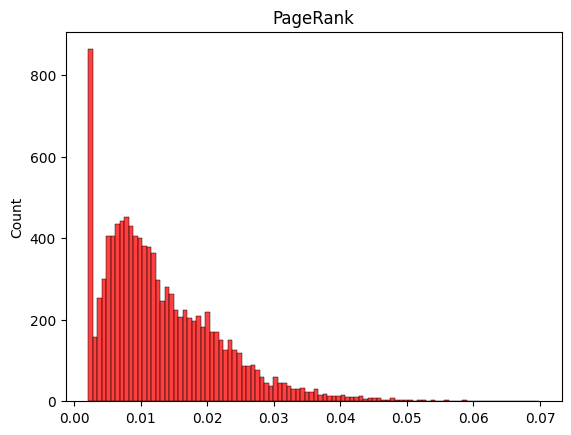

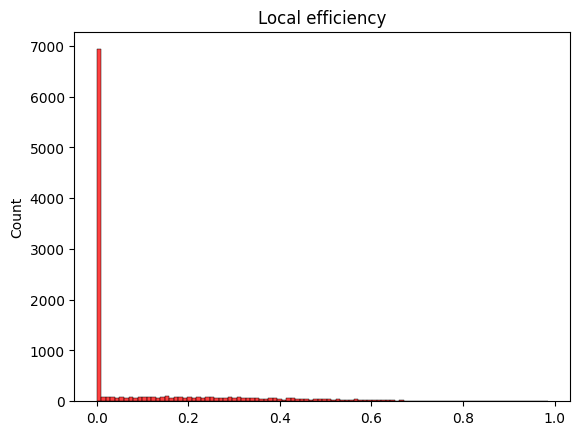

In [120]:
df6 = create_dataframe(metrics[6].copy())

In [121]:
df6

mstype  edss  Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  \
0         1   3.0    0.012933    2.348639    0.360878    0.885770    0.393900   
1         1   1.5    0.003975    2.726700    0.131439    0.715023    0.214531   
2         1   2.0    0.200010    2.014228    0.145752    1.039974    0.199996   
3         1   3.0    0.240419    2.026085    0.169388    0.352393    0.110515   
4         1   2.0    0.099655    1.654091    0.123295    0.359920    0.573203   
..      ...   ...         ...         ...         ...         ...         ...   
138       0   0.0    0.188746    1.469097    0.200427    0.699645    0.550311   
139       0   0.0    0.037275    2.026848    0.326434    1.339552    0.530562   
140       0   0.0    0.464743    2.806839    0.172201    0.997629    0.286775   
141       0   0.0    0.442102    2.537264    0.781671    0.248065    0.672784   
142       0   0.0    0.136801    2.320443    0.453455    0.386100    0.696499   

     Strength_5  Strength_6  Strength_7  ...  Local_ef_66  Local_ef_67  \
0      0.972382    0.850745    2.016915  ...          0.0          0.0   
1      2.471565    1.727396    2.427895  ...          0.0          0.0   
2      1.972205    1.320393    1.867797  ...          0.0          0.0   
3      0.779757    1.869373    2.347688  ...          0.0          0.0   
4      2.074003    2.176057    1.500469  ...          0.0          0.0   
..          ...         ...         ...  ...          ...          ...   
138    1.209628    2.372779    2.828015  ...          0.0          0.0   
139    1.206475    2.704915    3.267510  ...          0.0          0.0   
140    1.648569    1.864716    3.243940  ...          0.0          0.0   
141    1.760105    3.090962    1.933011  ...          0.0          0.0   
142    1.156316    2.142419    2.048093  ...          0.0          0.0   

     Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  \
0       0.191171          0.0     0.304576          0.0     0.127571   
1       0.101559          0.0     0.632105          0.0     0.208064   
2       0.133511          0.0     0.344024          0.0     0.590326   
3       0.067712          0.0     0.187639          0.0     0.219961   
4       0.185508          0.0     0.564253          0.0     0.521462   
..           ...          ...          ...          ...          ...   
138     0.157319          0.0     0.373271          0.0     0.090832   
139     0.128900          0.0     0.377827          0.0     0.054550   
140     0.182931          0.0     0.102637          0.0     0.112217   
141     0.283946          0.0     0.390570          0.0     0.356040   
142     0.243248          0.0     0.361584          0.0     0.279698   

     Local_ef_73  Local_ef_74  Local_ef_75  
0       0.572259     0.226857          0.0  
1       0.258089     0.074513          0.0  
2       0.176663     0.046212          0.0  
3       0.001706     0.103580          0.0  
4       0.016896     0.028809          0.0  
..           ...          ...          ...  
138     0.233727     0.053973          0.0  
139     0.224653     0.378576          0.0  
140     0.582532     0.082120          0.0  
141     0.344461     0.036156          0.0  
142     0.308148     0.260958          0.0  

[143 rows x 534 columns]

### SVM

#### Single-layer FA

In [129]:
x = df0.drop(columns=["mstype", "edss"])
y = df0["mstype"]

In [130]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     16.404345   19.934244   16.880274    6.925231   14.868683   27.237312   
1     14.564263   17.414928   15.134213    5.905397   12.780386   25.289463   
2     14.640516   16.196333   15.413794    6.149666   12.940156   24.447312   
3     14.117944   17.741166   17.888479    6.445422   17.751425   26.187135   
4     13.724987   16.343087   14.283896    6.545274   12.585314   22.759765   
..          ...         ...         ...         ...         ...         ...   
138   16.655485   19.146539   16.700146    7.617889   15.122495   25.956406   
139   15.134368   18.966089   17.424447    7.922187   15.291565   30.148821   
140   16.325812   19.457503   17.617547    6.979297   16.901045   28.585863   
141   14.223149   19.131217   14.883435    6.763010   12.154140   26.442900   
142   17.473569   20.529582   17.007257    6.597956   17.569032   27.068842   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     18.612786   23.729318   21.594440   17.103820  ...     0.404505   
1     17.176270   23.635124   20.064056   15.310251  ...     0.390676   
2     15.987123   21.234674   18.726902   14.535856  ...     0.362479   
3     18.658421   24.892061   21.659486   18.235656  ...     0.394411   
4     15.292995   20.699393   18.216965   14.939408  ...     0.363037   
..          ...         ...         ...         ...  ...          ...   
138   16.590008   23.546366   20.671853   19.548557  ...     0.399674   
139   19.847248   22.669545   24.042802   16.325941  ...     0.411943   
140   19.822967   25.647492   23.739913   18.541144  ...     0.425353   
141   15.966015   21.184424   19.354855   18.554706  ...     0.395527   
142   19.064165   26.884717   22.827824   18.531157  ...     0.425194   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.368982     0.361477     0.370647     0.372325     0.368709   
1       0.350216     0.346396     0.361291     0.357996     0.347928   
2       0.321137     0.323869     0.336609     0.335159     0.321751   
3       0.362457     0.366912     0.369140     0.364528     0.365627   
4       0.324367     0.328578     0.336544     0.335277     0.327869   
..           ...          ...          ...          ...          ...   
138     0.374968     0.366035     0.369722     0.374695     0.371155   
139     0.374835     0.369715     0.386245     0.384630     0.378543   
140     0.391793     0.381743     0.395079     0.393692     0.389168   
141     0.353635     0.360722     0.365122     0.365420     0.356498   
142     0.381919     0.381989     0.395951     0.394887     0.384462   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.376409     0.394584     0.444697     0.375068  
1       0.357892     0.380326     0.444446     0.358053  
2       0.331129     0.353703     0.396242     0.331454  
3       0.365138     0.386367     0.439351     0.366825  
4       0.324115     0.350394     0.407564     0.332249  
..           ...          ...          ...          ...  
138     0.375221     0.392292     0.451109     0.377678  
139     0.378105     0.405994     0.462343     0.380065  
140     0.392857     0.423258     0.477610     0.394553  
141     0.359573     0.382538     0.440241     0.366621  
142     0.386017     0.410103     0.459256     0.390308  

[143 rows x 228 columns]

In [131]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [132]:
model = svm.SVC(class_weight='balanced', probability=True, random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [133]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.8146666666666667
Best Hyperparameters: {'C': 100, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}


Accuracy:  0.6926108374384237
Precision:  0.9638888888888889
Recall:  0.6799999999999999
F1-score:  0.7856656672879021


              precision    recall  f1-score   support

           0       0.26      0.78      0.39        18
           1       0.96      0.68      0.79       125

    accuracy                           0.69       143
   macro avg       0.61      0.73      0.59       143
weighted avg       0.87      0.69      0.74       143





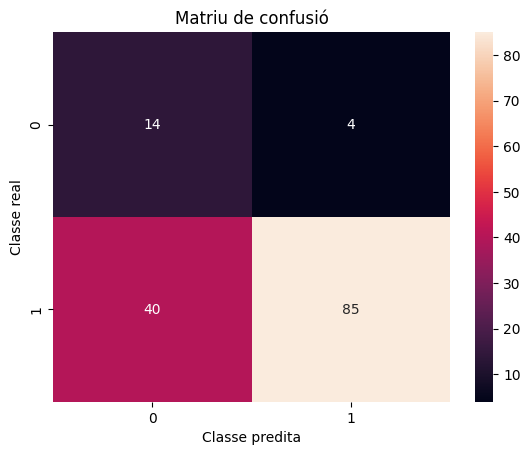

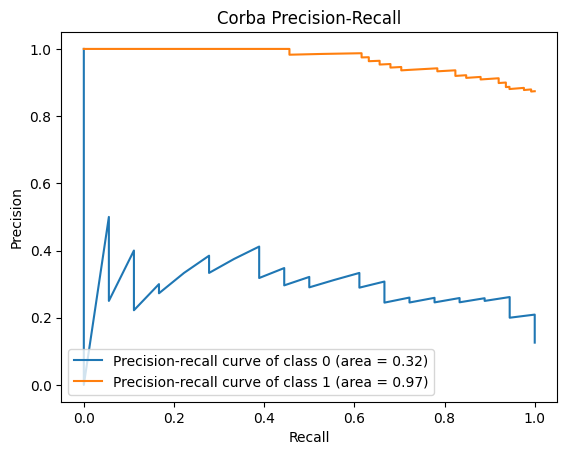

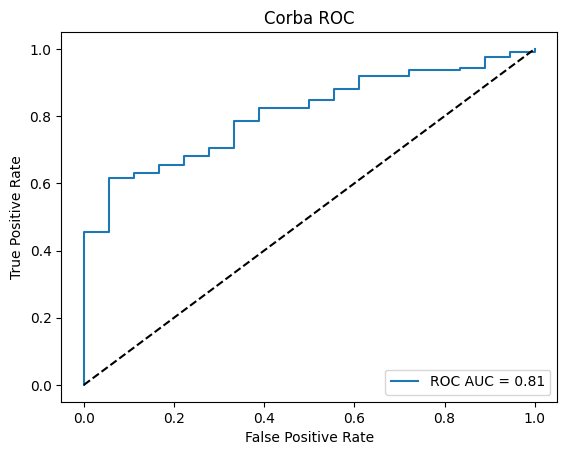

In [134]:
evaluate_model(best_model, x_scaled, y, folds)

#### Multi-layer estàndar

In [135]:
x = df1.drop(columns=["mstype", "edss"])
y = df1["mstype"]

In [136]:
x_aux = x[DEGREE_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Degree_0  Degree_1  Degree_2  Degree_3  Degree_4  Degree_5  Degree_6  \
0    0.760000  0.793333  0.746667  0.640000  0.733333  0.906667  0.786667   
1    0.746667  0.780000  0.740000  0.640000  0.726667  0.906667  0.793333   
2    0.753333  0.780000  0.753333  0.646667  0.740000  0.900000  0.780000   
3    0.746667  0.793333  0.753333  0.626667  0.773333  0.906667  0.793333   
4    0.733333  0.780000  0.740000  0.640000  0.733333  0.886667  0.773333   
..        ...       ...       ...       ...       ...       ...       ...   
138  0.766667  0.786667  0.746667  0.653333  0.746667  0.893333  0.786667   
139  0.740000  0.780000  0.753333  0.660000  0.740000  0.906667  0.793333   
140  0.753333  0.786667  0.746667  0.640000  0.760000  0.900000  0.793333   
141  0.720000  0.786667  0.746667  0.633333  0.740000  0.906667  0.773333   
142  0.753333  0.793333  0.753333  0.633333  0.766667  0.893333  0.793333   

     Degree_7  Degree_8  Degree_9  ...  Local_ef_66  Local_ef_67  Local_ef_68  \
0    0.846667  0.813333  0.793333  ...     0.000073     0.000073     0.000074   
1    0.846667  0.826667  0.800000  ...     0.000075     0.000075     0.000076   
2    0.860000  0.813333  0.793333  ...     0.000065     0.000065     0.000066   
3    0.866667  0.820000  0.800000  ...     0.000071     0.000071     0.000071   
4    0.826667  0.813333  0.800000  ...     0.000078     0.000078     0.000078   
..        ...       ...       ...  ...          ...          ...          ...   
138  0.840000  0.820000  0.820000  ...     0.000071     0.000071     0.000071   
139  0.820000  0.826667  0.780000  ...     0.000075     0.000075     0.000075   
140  0.846667  0.826667  0.820000  ...     0.000078     0.000078     0.000079   
141  0.806667  0.820000  0.800000  ...     0.000077     0.000077     0.000078   
142  0.860000  0.826667  0.813333  ...     0.000074     0.000074     0.000075   

     Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  Local_ef_73  \
0       0.000073     0.000073     0.000073     0.000073     0.000073   
1       0.000075     0.000075     0.000075     0.000075     0.000075   
2       0.000066     0.000065     0.000066     0.000066     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000079     0.000078     0.000078     0.000078     0.000079   
141     0.000077     0.000077     0.000077     0.000077     0.000077   
142     0.000075     0.000074     0.000074     0.000075     0.000075   

     Local_ef_74  Local_ef_75  
0       0.000073     0.000073  
1       0.000076     0.000075  
2       0.000066     0.000066  
3       0.000071     0.000071  
4       0.000078     0.000078  
..           ...          ...  
138     0.000072     0.000071  
139     0.000075     0.000075  
140     0.000079     0.000078  
141     0.000078     0.000078  
142     0.000075     0.000075  

[143 rows x 228 columns]

In [137]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [138]:
model = svm.SVC(class_weight='balanced', probability=True, random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [139]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.898
Best Hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


Accuracy:  0.8876847290640395
Precision:  0.9373095503530287
Recall:  0.9359999999999999
F1-score:  0.9355957767722473


              precision    recall  f1-score   support

           0       0.56      0.56      0.56        18
           1       0.94      0.94      0.94       125

    accuracy                           0.89       143
   macro avg       0.75      0.75      0.75       143
weighted avg       0.89      0.89      0.89       143





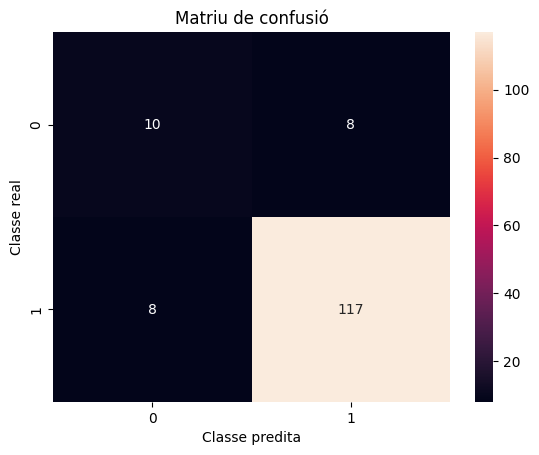

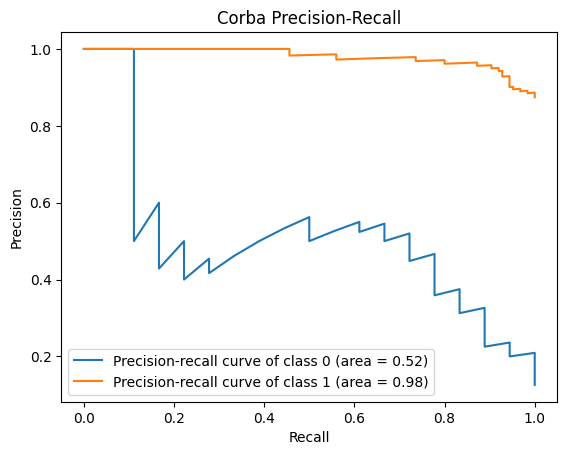

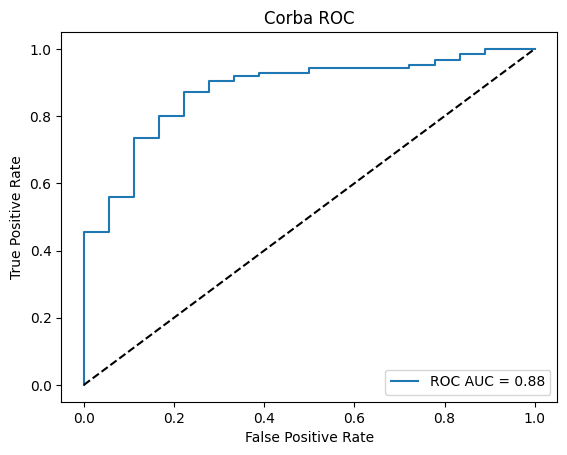

In [140]:
evaluate_model(best_model, x_scaled, y, folds)

#### Multi-layer amb thresholds

In [141]:
x = df2.drop(columns=["mstype", "edss"])
y = df2["mstype"]

In [142]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     59.546602   68.333008   52.062053   36.739089   54.399312   79.505457   
1     59.342370   69.089420   46.414456   28.759438   41.218641   85.061355   
2     44.482329   56.744913   47.792154   36.080874   38.740484   75.261471   
3     46.960781   59.721461   55.798446   28.772582   61.328655   74.071169   
4     54.790684   65.087871   47.325377   35.609662   56.441072   78.020789   
..          ...         ...         ...         ...         ...         ...   
138   48.050861   55.402142   53.238721   30.622538   55.201940   72.899173   
139   45.391052   61.082332   51.016888   39.196244   55.434633   82.234660   
140   61.280921   70.667780   57.908244   35.386812   49.842565   92.770859   
141   58.335901   69.351670   55.355230   32.585370   62.220438   86.858121   
142   52.966774   70.356110   59.456978   37.312291   58.239141   85.348509   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     62.886745   68.902278   73.267825   54.372685  ...     0.000073   
1     67.663033   70.354827   67.883736   59.382047  ...     0.000075   
2     50.185999   60.596573   64.768141   51.507843  ...     0.000065   
3     61.505285   69.114256   70.977930   55.426774  ...     0.000071   
4     65.359995   57.327700   73.273259   59.177871  ...     0.000078   
..          ...         ...         ...         ...  ...          ...   
138   58.730404   67.882382   64.668107   55.426587  ...     0.000071   
139   65.822946   67.285455   75.975785   52.644798  ...     0.000075   
140   58.987973   72.287588   71.549908   63.019200  ...     0.000078   
141   68.393011   55.036246   77.030050   54.511331  ...     0.000077   
142   63.064644   69.417201   76.548589   60.935065  ...     0.000074   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.000073     0.000074     0.000073     0.000073     0.000073   
1       0.000075     0.000076     0.000075     0.000075     0.000075   
2       0.000065     0.000066     0.000066     0.000065     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000078     0.000079     0.000079     0.000078     0.000078   
141     0.000077     0.000078     0.000077     0.000077     0.000077   
142     0.000074     0.000075     0.000075     0.000074     0.000074   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000073     0.000073     0.000073     0.000073  
1       0.000075     0.000075     0.000076     0.000075  
2       0.000066     0.000066     0.000066     0.000066  
3       0.000071     0.000071     0.000071     0.000071  
4       0.000078     0.000078     0.000078     0.000078  
..           ...          ...          ...          ...  
138     0.000071     0.000071     0.000072     0.000071  
139     0.000075     0.000075     0.000075     0.000075  
140     0.000078     0.000079     0.000079     0.000078  
141     0.000077     0.000077     0.000078     0.000078  
142     0.000075     0.000075     0.000075     0.000075  

[143 rows x 228 columns]

In [143]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [144]:
model = svm.SVC(class_weight='balanced', probability=True, random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [145]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.8493333333333333
Best Hyperparameters: {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}


Accuracy:  0.8386699507389164
Precision:  0.908
Recall:  0.9119999999999999
F1-score:  0.9067002096436058


              precision    recall  f1-score   support

           0       0.35      0.33      0.34        18
           1       0.90      0.91      0.91       125

    accuracy                           0.84       143
   macro avg       0.63      0.62      0.63       143
weighted avg       0.84      0.84      0.84       143





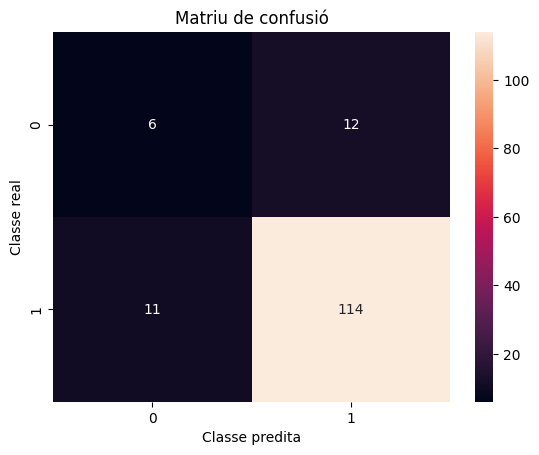

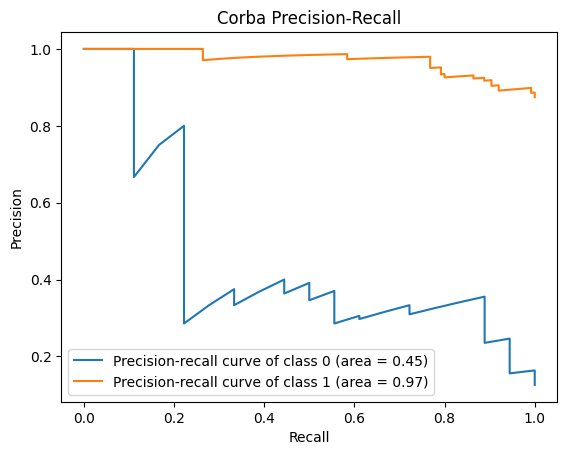

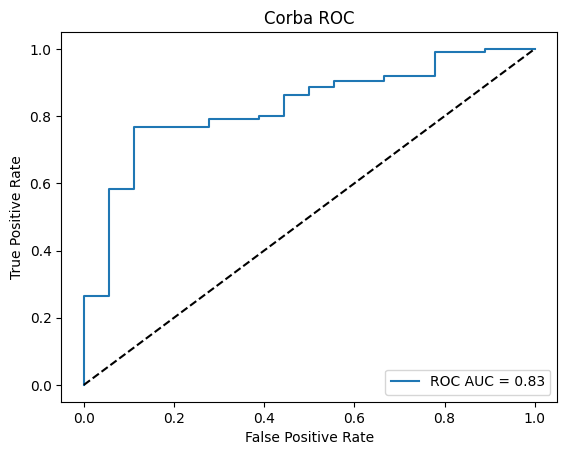

In [146]:
evaluate_model(best_model, x_scaled, y, folds)

#### Multilayer amb selecció d'arestes

In [147]:
x = df3.drop(columns=["mstype", "edss"])
y = df3["mstype"]

In [148]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS+CLUSTERING_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     20.994261   30.925471   24.331761    8.739466   15.426781   37.435479   
1     18.270499   28.252429   22.606156    7.017927   14.494215   37.187900   
2     19.185853   26.076601   23.106392    7.604893   13.965619   35.914693   
3     17.555392   27.724236   25.222265    8.141513   15.087189   36.136272   
4     18.061197   26.082460   21.388118    7.251541   14.419552   35.168434   
..          ...         ...         ...         ...         ...         ...   
138   20.626668   29.667578   25.452363    8.424795   16.317481   39.603689   
139   20.497556   29.607237   26.984561    8.808661   16.040173   40.387879   
140   21.848286   30.719663   26.697613    8.892110   16.544635   41.333551   
141   21.749789   30.565550   25.656699    7.596144   15.226042   38.552321   
142   21.957683   30.847532   27.245140    7.531913   16.383752   40.530886   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Clustering_66  \
0     24.132352   34.258167   31.690560   17.391322  ...       0.262686   
1     23.561520   34.653134   29.398500   15.727913  ...       0.259152   
2     22.675379   29.258655   27.461576   14.902771  ...       0.231151   
3     24.221430   34.364947   30.330865   17.211736  ...       0.246136   
4     22.926240   30.256283   28.163724   15.991734  ...       0.233838   
..          ...         ...         ...         ...  ...            ...   
138   25.071249   33.661879   33.760792   16.843842  ...       0.257027   
139   26.671820   35.782592   33.584656   17.321250  ...       0.260511   
140   26.495133   37.485694   34.310312   17.655675  ...       0.273885   
141   26.637520   33.415602   31.809572   17.170038  ...       0.258600   
142   26.713970   36.072178   33.610254   17.960635  ...       0.274906   

     Clustering_67  Clustering_68  Clustering_69  Clustering_70  \
0         0.228612       0.180449       0.184191       0.225981   
1         0.217801       0.172728       0.172225       0.225102   
2         0.204306       0.177683       0.164646       0.207126   
3         0.218830       0.166751       0.170944       0.208105   
4         0.206379       0.175266       0.167263       0.212348   
..             ...            ...            ...            ...   
138       0.235204       0.199069       0.172068       0.216878   
139       0.241631       0.191053       0.188079       0.220715   
140       0.240977       0.196357       0.185042       0.239115   
141       0.230021       0.200203       0.180050       0.226098   
142       0.246114       0.193993       0.190883       0.243752   

     Clustering_71  Clustering_72  Clustering_73  Clustering_74  Clustering_75  
0         0.235822       0.225125       0.229932       0.283444       0.244066  
1         0.225663       0.223304       0.219951       0.276597       0.230390  
2         0.207851       0.198928       0.199322       0.270727       0.216008  
3         0.225049       0.220563       0.206981       0.269224       0.232298  
4         0.208362       0.206946       0.196351       0.254061       0.217717  
..             ...            ...            ...            ...            ...  
138       0.238301       0.214904       0.222357       0.270879       0.231433  
139       0.245768       0.226934       0.229259       0.301581       0.251032  
140       0.250848       0.240701       0.234888       0.299663       0.257560  
141       0.237616       0.215016       0.223589       0.276849       0.235403  
142       0.249174       0.237190       0.236223       0.299742       0.254543  

[143 rows x 304 columns]

In [149]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [150]:
model = svm.SVC(class_weight='balanced', probability=True, random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [151]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.9973333333333333
Best Hyperparameters: {'C': 0.001, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}


Accuracy:  0.9650246305418719
Precision:  0.992
Recall:  0.968
F1-score:  0.9795850340136054


              precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.99      0.97      0.98       125

    accuracy                           0.97       143
   macro avg       0.90      0.96      0.93       143
weighted avg       0.97      0.97      0.97       143





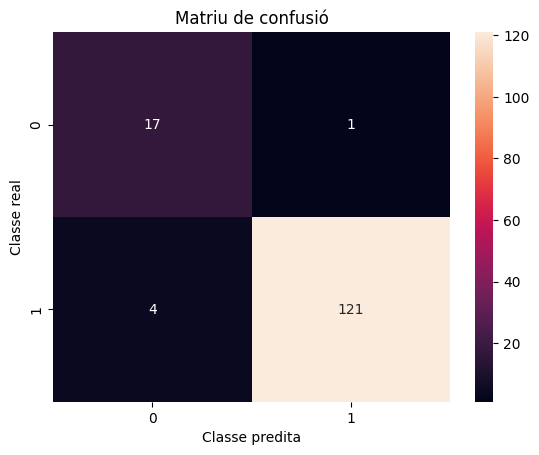

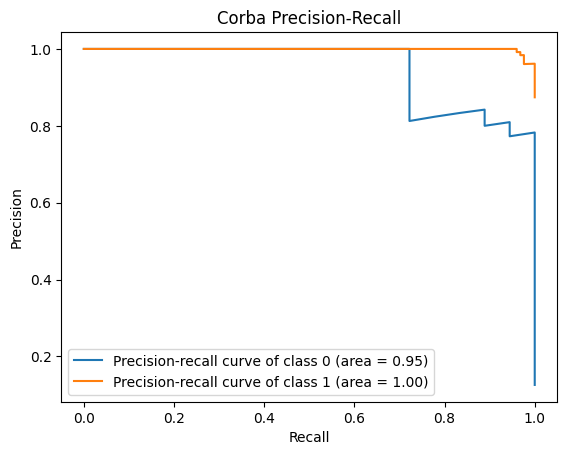

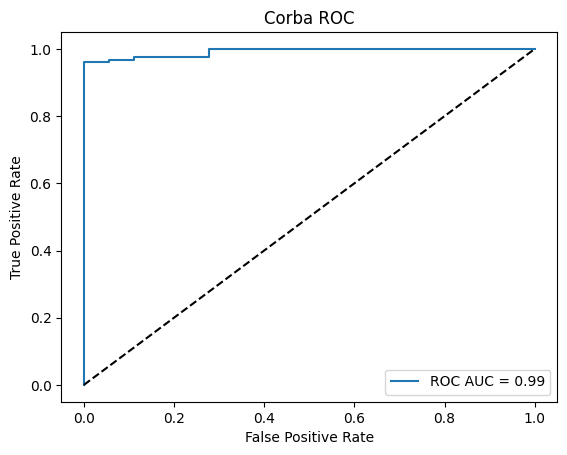

In [152]:
evaluate_model(best_model, x_scaled, y, folds)

#### Single-layer FA amb selecció d'arestes

In [153]:
x = df4.drop(columns=["mstype", "edss"])
y = df4["mstype"]

In [154]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     10.480743   13.752801   11.985441    3.904961    7.319794   18.231549   
1      9.125421   12.224827   11.237358    3.135864    6.928494   17.358168   
2      9.485210   11.516828   11.480320    3.268007    6.716047   16.971244   
3      8.653527   12.395658   12.526438    3.878158    7.311625   17.678257   
4      8.975146   11.711132   10.632412    3.428517    6.764899   16.547216   
..          ...         ...         ...         ...         ...         ...   
138   10.210400   13.607235   12.625968    3.847231    7.684441   19.197031   
139   10.224815   13.303207   13.329064    3.720480    7.579796   19.590702   
140   10.683068   13.607567   13.262706    3.932663    7.957666   19.842491   
141   10.646996   13.581947   12.437514    3.654525    7.073533   18.396108   
142   10.902477   13.853444   13.395842    3.559879    7.694182   19.687285   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     11.152640   16.120626   15.554824    7.492134  ...     0.366174   
1     10.467688   16.112620   14.499703    6.747417  ...     0.357558   
2     10.307904   13.695429   13.569751    6.450834  ...     0.331607   
3     10.845597   16.008630   14.798309    7.716483  ...     0.351730   
4      9.980599   14.377907   13.730734    6.752295  ...     0.329242   
..          ...         ...         ...         ...  ...          ...   
138   10.971642   15.416932   16.285140    7.730024  ...     0.369414   
139   11.606020   16.257541   16.286737    7.869841  ...     0.369844   
140   11.961815   17.120877   16.688269    7.955804  ...     0.386842   
141   11.355159   15.741295   15.360904    7.712926  ...     0.370444   
142   11.936675   17.012043   16.103322    8.184430  ...     0.391857   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.347571     0.351386     0.313295     0.329664     0.349992   
1       0.332547     0.329169     0.299250     0.318856     0.334491   
2       0.305925     0.313836     0.282130     0.300120     0.308587   
3       0.338291     0.340875     0.304576     0.314246     0.340844   
4       0.310620     0.313607     0.285811     0.304329     0.313900   
..           ...          ...          ...          ...          ...   
138     0.355628     0.353957     0.313542     0.333481     0.357247   
139     0.354110     0.361299     0.322057     0.333878     0.356393   
140     0.366502     0.374723     0.330124     0.347692     0.369005   
141     0.341450     0.361039     0.314365     0.330653     0.345169   
142     0.361646     0.379568     0.336064     0.356525     0.365260   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.350801     0.368719     0.407565     0.350977  
1       0.334007     0.353251     0.406351     0.337033  
2       0.305261     0.326794     0.369318     0.307262  
3       0.339021     0.357157     0.397584     0.338548  
4       0.313439     0.328739     0.386930     0.311634  
..           ...          ...          ...          ...  
138     0.358730     0.373808     0.404694     0.356552  
139     0.356464     0.374923     0.416272     0.353249  
140     0.368466     0.394220     0.436364     0.368807  
141     0.345252     0.365292     0.403384     0.348461  
142     0.364548     0.387621     0.436751     0.367066  

[143 rows x 304 columns]

In [155]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [156]:
model = svm.SVC(class_weight='balanced', probability=True, random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [157]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.9666666666666666
Best Hyperparameters: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


Accuracy:  0.9229064039408866
Precision:  0.9843076923076923
Recall:  0.9279999999999999
F1-score:  0.9538395369248533


              precision    recall  f1-score   support

           0       0.64      0.89      0.74        18
           1       0.98      0.93      0.95       125

    accuracy                           0.92       143
   macro avg       0.81      0.91      0.85       143
weighted avg       0.94      0.92      0.93       143





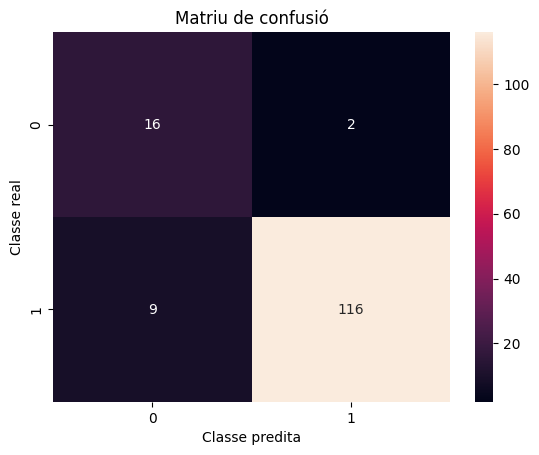

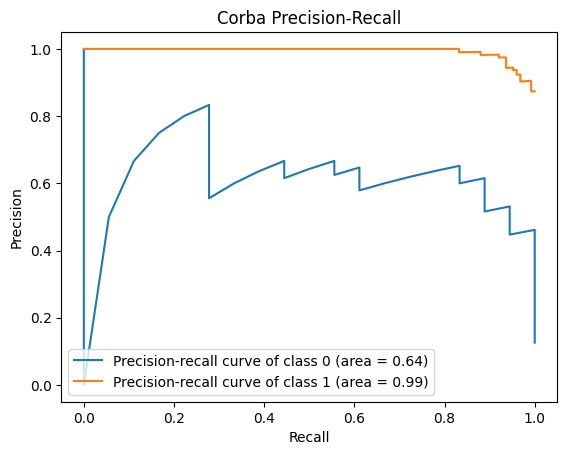

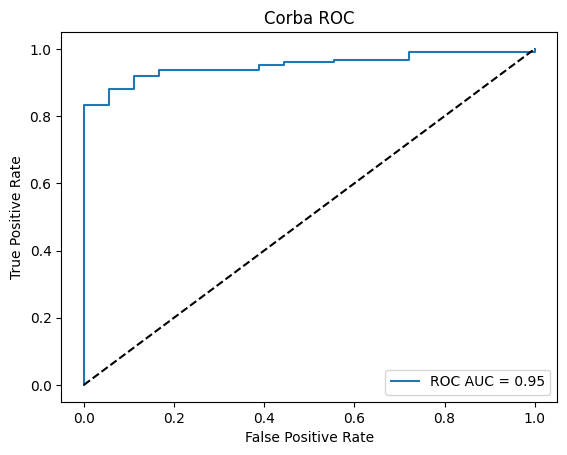

In [158]:
evaluate_model(best_model, x_scaled, y, folds)

#### Single-layer GM amb selecció d'arestes

In [159]:
x = df5.drop(columns=["mstype", "edss"])
y = df5["mstype"]

In [160]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLUSTERING_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.019841    1.071230         0.0    0.043774    0.393293         0.0   
1      0.015682    1.076074         0.0    0.031175    0.422697         0.0   
2      0.015422    1.028716         0.0    0.028904    0.333530         0.0   
3      0.007920    0.906835         0.0    0.032805    0.353425         0.0   
4      0.011251    1.006105         0.0    0.034587    0.316551         0.0   
..          ...         ...         ...         ...         ...         ...   
138    0.017122    0.984011         0.0    0.030689    0.398288         0.0   
139    0.010652    0.973974         0.0    0.028148    0.350019         0.0   
140    0.017408    0.697690         0.0    0.029155    0.342529         0.0   
141    0.013695    0.864393         0.0    0.039029    0.406192         0.0   
142    0.015928    0.820201         0.0    0.026055    0.298889         0.0   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0      0.976328         0.0         0.0    1.239833  ...     0.053616   
1      0.898748         0.0         0.0    1.109160  ...     0.042610   
2      0.739178         0.0         0.0    0.945089  ...     0.043119   
3      0.660863         0.0         0.0    0.908107  ...     0.036749   
4      0.788985         0.0         0.0    0.919306  ...     0.037583   
..          ...         ...         ...         ...  ...          ...   
138    0.755185         0.0         0.0    1.013880  ...     0.044078   
139    0.754866         0.0         0.0    1.102764  ...     0.040176   
140    0.706787         0.0         0.0    1.038116  ...     0.042352   
141    0.836240         0.0         0.0    0.977471  ...     0.042278   
142    0.698201         0.0         0.0    0.944805  ...     0.040608   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.029447          0.0     0.048761     0.122305     0.062666   
1       0.022855          0.0     0.045030     0.108926     0.058505   
2       0.021756          0.0     0.037138     0.105784     0.047611   
3       0.018812          0.0     0.034628     0.093252     0.044173   
4       0.020567          0.0     0.036909     0.101007     0.047629   
..           ...          ...          ...          ...          ...   
138     0.024908          0.0     0.037907     0.103998     0.048492   
139     0.022320          0.0     0.038711     0.107093     0.051292   
140     0.022598          0.0     0.036792     0.108316     0.048832   
141     0.021248          0.0     0.040721     0.112127     0.052049   
142     0.021907          0.0     0.036940     0.101944     0.048015   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0            0.0     0.051184          0.0          0.0  
1            0.0     0.047240          0.0          0.0  
2            0.0     0.040166          0.0          0.0  
3            0.0     0.035551          0.0          0.0  
4            0.0     0.037390          0.0          0.0  
..           ...          ...          ...          ...  
138          0.0     0.038634          0.0          0.0  
139          0.0     0.042021          0.0          0.0  
140          0.0     0.040443          0.0          0.0  
141          0.0     0.041713          0.0          0.0  
142          0.0     0.039865          0.0          0.0  

[143 rows x 304 columns]

In [161]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [162]:
model = svm.SVC(class_weight='balanced', probability=True, random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [163]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.8946666666666667
Best Hyperparameters: {'C': 0.001, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


Accuracy:  0.5600985221674877
Precision:  0.5172413793103449


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall:  0.6
F1-score:  0.5555555555555556


              precision    recall  f1-score   support

           0       0.11      0.33      0.16        18
           1       0.86      0.60      0.71       125

    accuracy                           0.57       143
   macro avg       0.48      0.47      0.43       143
weighted avg       0.77      0.57      0.64       143





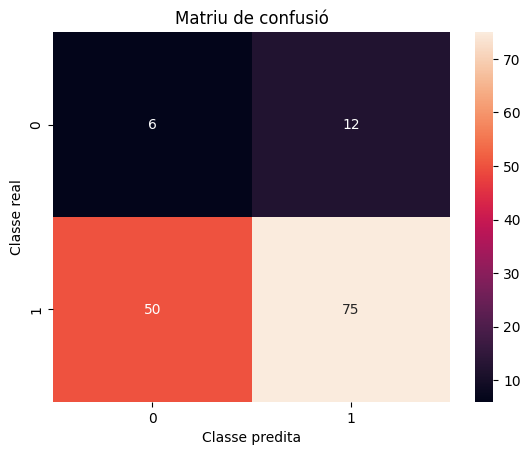

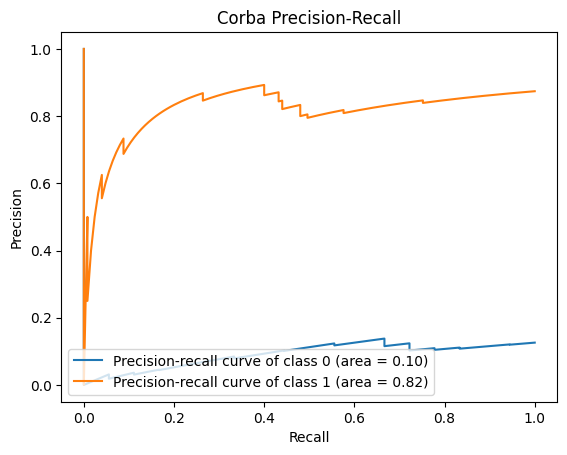

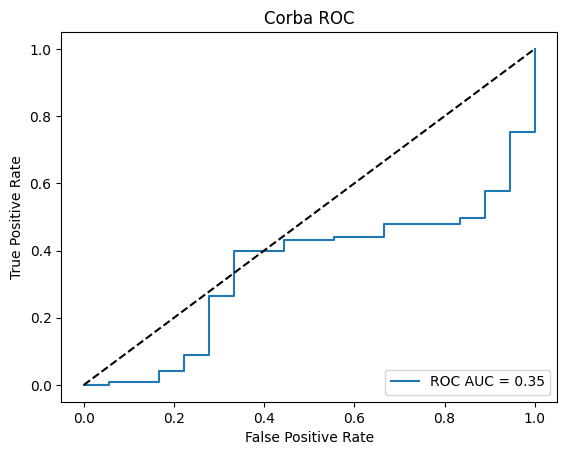

In [164]:
evaluate_model(best_model, x_scaled, y, folds)

#### Single-layer RS amb selecció d'arestes

In [165]:
x = df6.drop(columns=["mstype", "edss"])
y = df6["mstype"]

In [166]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.012933    2.348639    0.360878    0.885770    0.393900    0.972382   
1      0.003975    2.726700    0.131439    0.715023    0.214531    2.471565   
2      0.200010    2.014228    0.145752    1.039974    0.199996    1.972205   
3      0.240419    2.026085    0.169388    0.352393    0.110515    0.779757   
4      0.099655    1.654091    0.123295    0.359920    0.573203    2.074003   
..          ...         ...         ...         ...         ...         ...   
138    0.188746    1.469097    0.200427    0.699645    0.550311    1.209628   
139    0.037275    2.026848    0.326434    1.339552    0.530562    1.206475   
140    0.464743    2.806839    0.172201    0.997629    0.286775    1.648569   
141    0.442102    2.537264    0.781671    0.248065    0.672784    1.760105   
142    0.136801    2.320443    0.453455    0.386100    0.696499    1.156316   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Closeness_66  \
0      0.850745    2.016915    0.580912    1.167222  ...      0.083292   
1      1.727396    2.427895    0.399093    1.123919  ...      0.041296   
2      1.320393    1.867797    0.322074    1.056015  ...      0.055046   
3      1.869373    2.347688    0.734247    0.870663  ...      0.048250   
4      2.176057    1.500469    0.702256    1.567838  ...      0.076433   
..          ...         ...         ...         ...  ...           ...   
138    2.372779    2.828015    1.190513    0.369914  ...      0.074611   
139    2.704915    3.267510    1.011183    0.478804  ...      0.084785   
140    1.864716    3.243940    0.933774    0.705951  ...      0.092559   
141    3.090962    1.933011    1.087764    0.766715  ...      0.074004   
142    2.142419    2.048093    1.403611    0.646971  ...      0.081006   

     Closeness_67  Closeness_68  Closeness_69  Closeness_70  Closeness_71  \
0        0.072190      0.087037      0.069026      0.084071      0.076569   
1        0.064091      0.063129      0.052690      0.064843      0.062258   
2        0.082964      0.082376      0.057546      0.073840      0.074692   
3        0.058720      0.061321      0.051648      0.050016      0.058505   
4        0.090418      0.086879      0.077219      0.108275      0.105883   
..            ...           ...           ...           ...           ...   
138      0.077402      0.119901      0.060655      0.072363      0.092725   
139      0.094141      0.103530      0.071243      0.088394      0.117761   
140      0.077154      0.117794      0.063638      0.101060      0.099169   
141      0.088640      0.135949      0.065186      0.085139      0.141878   
142      0.098732      0.100545      0.059204      0.078331      0.101467   

     Closeness_72  Closeness_73  Closeness_74  Closeness_75  
0        0.097971      0.102868      0.076970      0.098043  
1        0.062854      0.070566      0.053445      0.047637  
2        0.086000      0.090734      0.081605      0.075461  
3        0.063299      0.065723      0.047770      0.045452  
4        0.108323      0.113074      0.073160      0.074640  
..            ...           ...           ...           ...  
138      0.091099      0.106720      0.078426      0.091700  
139      0.093489      0.135388      0.108168      0.110939  
140      0.104966      0.128786      0.102709      0.117524  
141      0.087730      0.140445      0.088402      0.046514  
142      0.090594      0.131361      0.077406      0.099463  

[143 rows x 228 columns]

In [167]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [168]:
model = svm.SVC(class_weight='balanced', probability=True, random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [169]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.944
Best Hyperparameters: {'C': 0.1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}


Accuracy:  0.9507389162561577
Precision:  0.9685897435897436
Recall:  0.976
F1-score:  0.971908763505402


              precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.97      0.98      0.97       125

    accuracy                           0.95       143
   macro avg       0.90      0.88      0.89       143
weighted avg       0.95      0.95      0.95       143





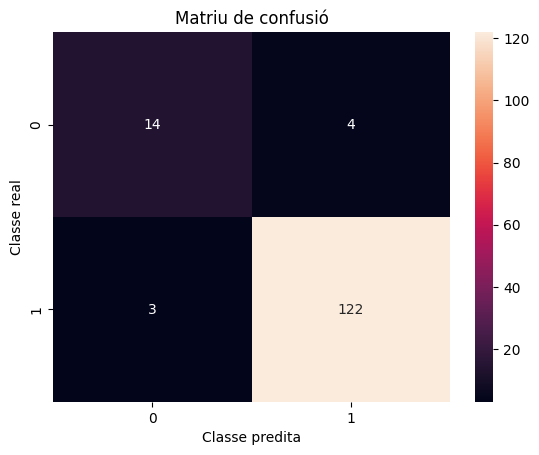

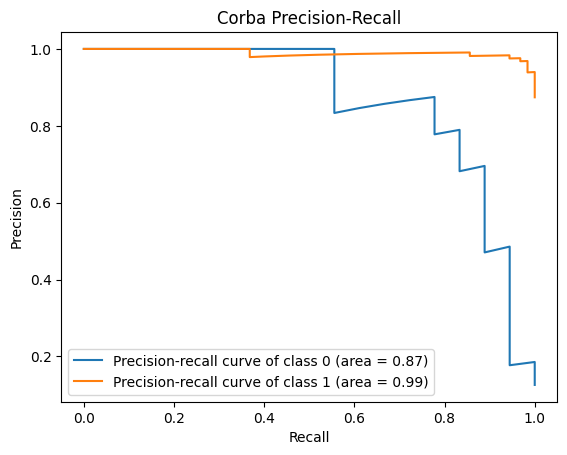

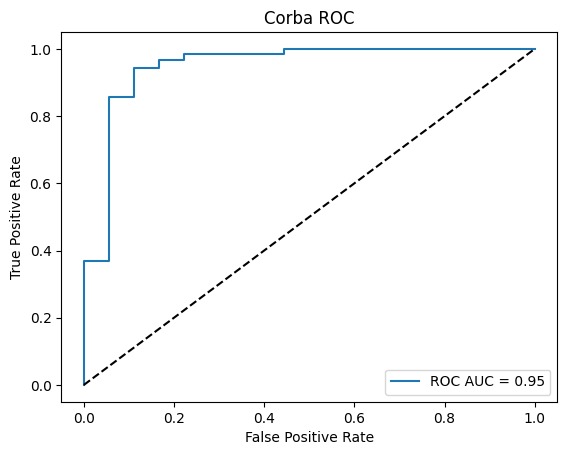

In [170]:
evaluate_model(best_model, x_scaled, y, folds)

### Random Forest

#### Single-layer FA

In [171]:
x = df0.drop(columns=["mstype", "edss"])
y = df0["mstype"]

In [172]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     16.404345   19.934244   16.880274    6.925231   14.868683   27.237312   
1     14.564263   17.414928   15.134213    5.905397   12.780386   25.289463   
2     14.640516   16.196333   15.413794    6.149666   12.940156   24.447312   
3     14.117944   17.741166   17.888479    6.445422   17.751425   26.187135   
4     13.724987   16.343087   14.283896    6.545274   12.585314   22.759765   
..          ...         ...         ...         ...         ...         ...   
138   16.655485   19.146539   16.700146    7.617889   15.122495   25.956406   
139   15.134368   18.966089   17.424447    7.922187   15.291565   30.148821   
140   16.325812   19.457503   17.617547    6.979297   16.901045   28.585863   
141   14.223149   19.131217   14.883435    6.763010   12.154140   26.442900   
142   17.473569   20.529582   17.007257    6.597956   17.569032   27.068842   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     18.612786   23.729318   21.594440   17.103820  ...     0.404505   
1     17.176270   23.635124   20.064056   15.310251  ...     0.390676   
2     15.987123   21.234674   18.726902   14.535856  ...     0.362479   
3     18.658421   24.892061   21.659486   18.235656  ...     0.394411   
4     15.292995   20.699393   18.216965   14.939408  ...     0.363037   
..          ...         ...         ...         ...  ...          ...   
138   16.590008   23.546366   20.671853   19.548557  ...     0.399674   
139   19.847248   22.669545   24.042802   16.325941  ...     0.411943   
140   19.822967   25.647492   23.739913   18.541144  ...     0.425353   
141   15.966015   21.184424   19.354855   18.554706  ...     0.395527   
142   19.064165   26.884717   22.827824   18.531157  ...     0.425194   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.368982     0.361477     0.370647     0.372325     0.368709   
1       0.350216     0.346396     0.361291     0.357996     0.347928   
2       0.321137     0.323869     0.336609     0.335159     0.321751   
3       0.362457     0.366912     0.369140     0.364528     0.365627   
4       0.324367     0.328578     0.336544     0.335277     0.327869   
..           ...          ...          ...          ...          ...   
138     0.374968     0.366035     0.369722     0.374695     0.371155   
139     0.374835     0.369715     0.386245     0.384630     0.378543   
140     0.391793     0.381743     0.395079     0.393692     0.389168   
141     0.353635     0.360722     0.365122     0.365420     0.356498   
142     0.381919     0.381989     0.395951     0.394887     0.384462   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.376409     0.394584     0.444697     0.375068  
1       0.357892     0.380326     0.444446     0.358053  
2       0.331129     0.353703     0.396242     0.331454  
3       0.365138     0.386367     0.439351     0.366825  
4       0.324115     0.350394     0.407564     0.332249  
..           ...          ...          ...          ...  
138     0.375221     0.392292     0.451109     0.377678  
139     0.378105     0.405994     0.462343     0.380065  
140     0.392857     0.423258     0.477610     0.394553  
141     0.359573     0.382538     0.440241     0.366621  
142     0.386017     0.410103     0.459256     0.390308  

[143 rows x 228 columns]

In [173]:
model = RandomForestClassifier(class_weight='balanced', random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [174]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_aux,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.7346666666666668
Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


Accuracy:  0.825615763546798
Precision:  0.867336870026525
Recall:  0.944
F1-score:  0.9033886628026473


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.87      0.94      0.90       125

    accuracy                           0.83       143
   macro avg       0.43      0.47      0.45       143
weighted avg       0.76      0.83      0.79       143





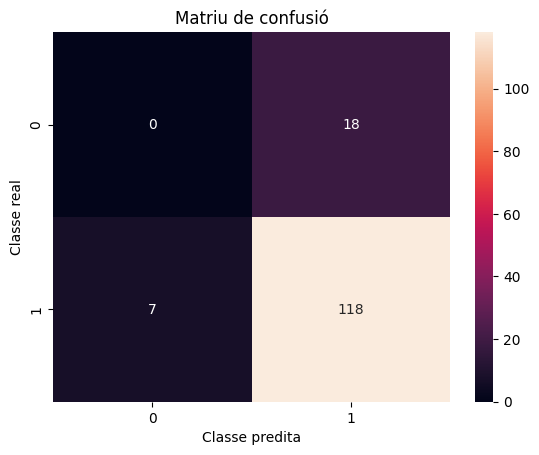

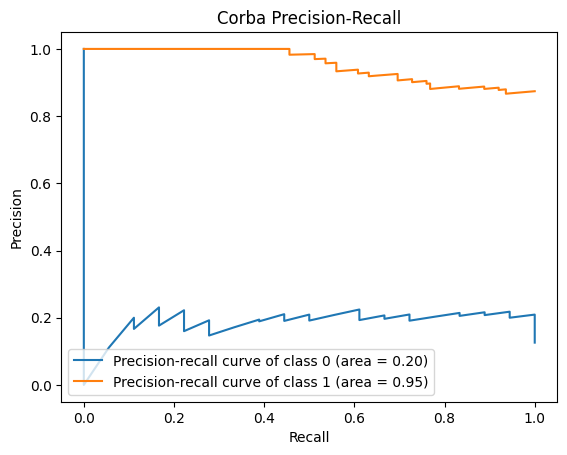

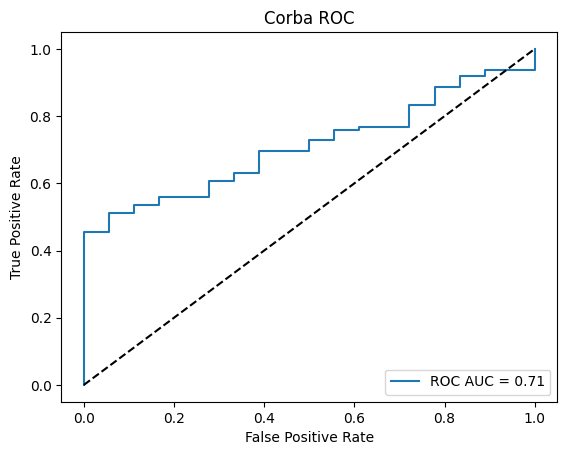

In [175]:
evaluate_model(best_model, x_aux, y, folds)

#### Multi-layer estàndar

In [176]:
x = df1.drop(columns=["mstype", "edss"])
y = df1["mstype"]

In [177]:
x_aux = x[DEGREE_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Degree_0  Degree_1  Degree_2  Degree_3  Degree_4  Degree_5  Degree_6  \
0    0.760000  0.793333  0.746667  0.640000  0.733333  0.906667  0.786667   
1    0.746667  0.780000  0.740000  0.640000  0.726667  0.906667  0.793333   
2    0.753333  0.780000  0.753333  0.646667  0.740000  0.900000  0.780000   
3    0.746667  0.793333  0.753333  0.626667  0.773333  0.906667  0.793333   
4    0.733333  0.780000  0.740000  0.640000  0.733333  0.886667  0.773333   
..        ...       ...       ...       ...       ...       ...       ...   
138  0.766667  0.786667  0.746667  0.653333  0.746667  0.893333  0.786667   
139  0.740000  0.780000  0.753333  0.660000  0.740000  0.906667  0.793333   
140  0.753333  0.786667  0.746667  0.640000  0.760000  0.900000  0.793333   
141  0.720000  0.786667  0.746667  0.633333  0.740000  0.906667  0.773333   
142  0.753333  0.793333  0.753333  0.633333  0.766667  0.893333  0.793333   

     Degree_7  Degree_8  Degree_9  ...  Local_ef_66  Local_ef_67  Local_ef_68  \
0    0.846667  0.813333  0.793333  ...     0.000073     0.000073     0.000074   
1    0.846667  0.826667  0.800000  ...     0.000075     0.000075     0.000076   
2    0.860000  0.813333  0.793333  ...     0.000065     0.000065     0.000066   
3    0.866667  0.820000  0.800000  ...     0.000071     0.000071     0.000071   
4    0.826667  0.813333  0.800000  ...     0.000078     0.000078     0.000078   
..        ...       ...       ...  ...          ...          ...          ...   
138  0.840000  0.820000  0.820000  ...     0.000071     0.000071     0.000071   
139  0.820000  0.826667  0.780000  ...     0.000075     0.000075     0.000075   
140  0.846667  0.826667  0.820000  ...     0.000078     0.000078     0.000079   
141  0.806667  0.820000  0.800000  ...     0.000077     0.000077     0.000078   
142  0.860000  0.826667  0.813333  ...     0.000074     0.000074     0.000075   

     Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  Local_ef_73  \
0       0.000073     0.000073     0.000073     0.000073     0.000073   
1       0.000075     0.000075     0.000075     0.000075     0.000075   
2       0.000066     0.000065     0.000066     0.000066     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000079     0.000078     0.000078     0.000078     0.000079   
141     0.000077     0.000077     0.000077     0.000077     0.000077   
142     0.000075     0.000074     0.000074     0.000075     0.000075   

     Local_ef_74  Local_ef_75  
0       0.000073     0.000073  
1       0.000076     0.000075  
2       0.000066     0.000066  
3       0.000071     0.000071  
4       0.000078     0.000078  
..           ...          ...  
138     0.000072     0.000071  
139     0.000075     0.000075  
140     0.000079     0.000078  
141     0.000078     0.000078  
142     0.000075     0.000075  

[143 rows x 228 columns]

In [178]:
model = RandomForestClassifier(class_weight='balanced', random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [179]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_aux,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.8506666666666666
Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Accuracy:  0.874384236453202
Precision:  0.874384236453202
Recall:  1.0
F1-score:  0.9329140461215933


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.87      1.00      0.93       125

    accuracy                           0.87       143
   macro avg       0.44      0.50      0.47       143
weighted avg       0.76      0.87      0.82       143





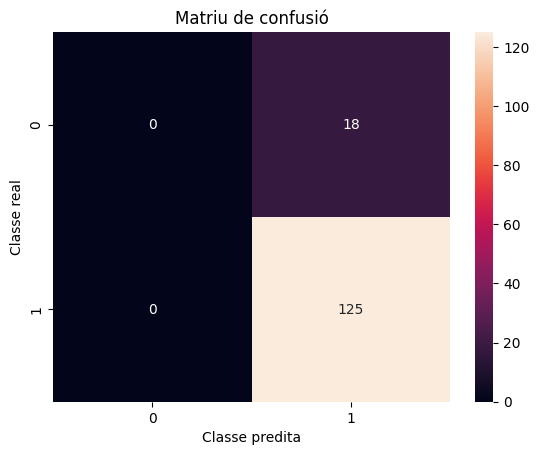

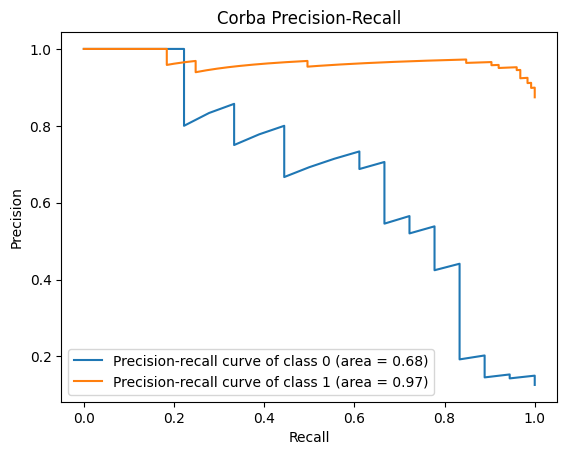

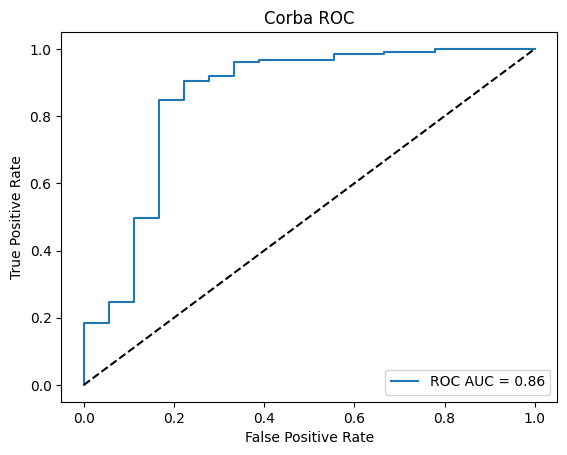

In [180]:
evaluate_model(best_model, x_aux, y, folds)

#### Multi-layer amb thresholds

In [181]:
x = df2.drop(columns=["mstype", "edss"])
y = df2["mstype"]

In [182]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     59.546602   68.333008   52.062053   36.739089   54.399312   79.505457   
1     59.342370   69.089420   46.414456   28.759438   41.218641   85.061355   
2     44.482329   56.744913   47.792154   36.080874   38.740484   75.261471   
3     46.960781   59.721461   55.798446   28.772582   61.328655   74.071169   
4     54.790684   65.087871   47.325377   35.609662   56.441072   78.020789   
..          ...         ...         ...         ...         ...         ...   
138   48.050861   55.402142   53.238721   30.622538   55.201940   72.899173   
139   45.391052   61.082332   51.016888   39.196244   55.434633   82.234660   
140   61.280921   70.667780   57.908244   35.386812   49.842565   92.770859   
141   58.335901   69.351670   55.355230   32.585370   62.220438   86.858121   
142   52.966774   70.356110   59.456978   37.312291   58.239141   85.348509   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     62.886745   68.902278   73.267825   54.372685  ...     0.000073   
1     67.663033   70.354827   67.883736   59.382047  ...     0.000075   
2     50.185999   60.596573   64.768141   51.507843  ...     0.000065   
3     61.505285   69.114256   70.977930   55.426774  ...     0.000071   
4     65.359995   57.327700   73.273259   59.177871  ...     0.000078   
..          ...         ...         ...         ...  ...          ...   
138   58.730404   67.882382   64.668107   55.426587  ...     0.000071   
139   65.822946   67.285455   75.975785   52.644798  ...     0.000075   
140   58.987973   72.287588   71.549908   63.019200  ...     0.000078   
141   68.393011   55.036246   77.030050   54.511331  ...     0.000077   
142   63.064644   69.417201   76.548589   60.935065  ...     0.000074   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.000073     0.000074     0.000073     0.000073     0.000073   
1       0.000075     0.000076     0.000075     0.000075     0.000075   
2       0.000065     0.000066     0.000066     0.000065     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000078     0.000079     0.000079     0.000078     0.000078   
141     0.000077     0.000078     0.000077     0.000077     0.000077   
142     0.000074     0.000075     0.000075     0.000074     0.000074   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000073     0.000073     0.000073     0.000073  
1       0.000075     0.000075     0.000076     0.000075  
2       0.000066     0.000066     0.000066     0.000066  
3       0.000071     0.000071     0.000071     0.000071  
4       0.000078     0.000078     0.000078     0.000078  
..           ...          ...          ...          ...  
138     0.000071     0.000071     0.000072     0.000071  
139     0.000075     0.000075     0.000075     0.000075  
140     0.000078     0.000079     0.000079     0.000078  
141     0.000077     0.000077     0.000078     0.000078  
142     0.000075     0.000075     0.000075     0.000075  

[143 rows x 228 columns]

In [183]:
model = RandomForestClassifier(class_weight='balanced', random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [184]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_aux,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.8003333333333333
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Accuracy:  0.874384236453202
Precision:  0.874384236453202
Recall:  1.0
F1-score:  0.9329140461215933


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.87      1.00      0.93       125

    accuracy                           0.87       143
   macro avg       0.44      0.50      0.47       143
weighted avg       0.76      0.87      0.82       143





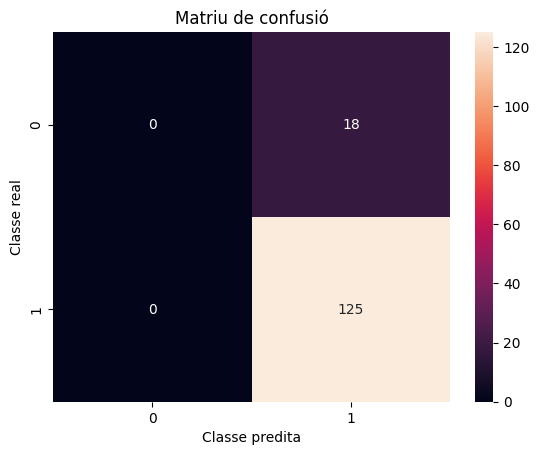

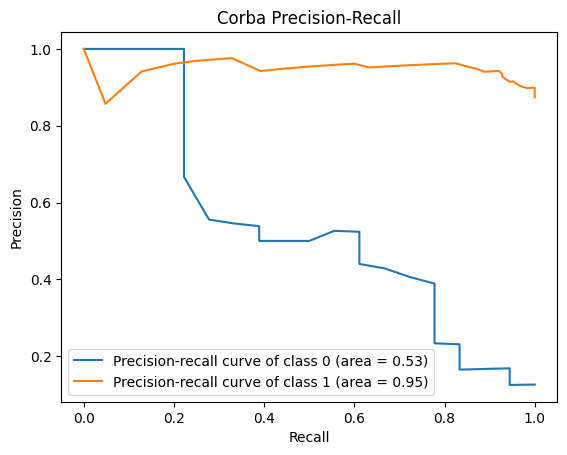

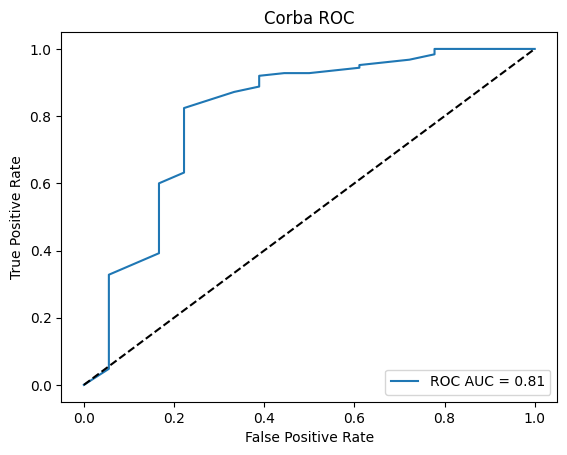

In [185]:
evaluate_model(best_model, x_aux, y, folds)

#### Multilayer amb selecció d'arestes

In [186]:
x = df3.drop(columns=["mstype", "edss"])
y = df3["mstype"]

In [187]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS+CLUSTERING_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     20.994261   30.925471   24.331761    8.739466   15.426781   37.435479   
1     18.270499   28.252429   22.606156    7.017927   14.494215   37.187900   
2     19.185853   26.076601   23.106392    7.604893   13.965619   35.914693   
3     17.555392   27.724236   25.222265    8.141513   15.087189   36.136272   
4     18.061197   26.082460   21.388118    7.251541   14.419552   35.168434   
..          ...         ...         ...         ...         ...         ...   
138   20.626668   29.667578   25.452363    8.424795   16.317481   39.603689   
139   20.497556   29.607237   26.984561    8.808661   16.040173   40.387879   
140   21.848286   30.719663   26.697613    8.892110   16.544635   41.333551   
141   21.749789   30.565550   25.656699    7.596144   15.226042   38.552321   
142   21.957683   30.847532   27.245140    7.531913   16.383752   40.530886   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Clustering_66  \
0     24.132352   34.258167   31.690560   17.391322  ...       0.262686   
1     23.561520   34.653134   29.398500   15.727913  ...       0.259152   
2     22.675379   29.258655   27.461576   14.902771  ...       0.231151   
3     24.221430   34.364947   30.330865   17.211736  ...       0.246136   
4     22.926240   30.256283   28.163724   15.991734  ...       0.233838   
..          ...         ...         ...         ...  ...            ...   
138   25.071249   33.661879   33.760792   16.843842  ...       0.257027   
139   26.671820   35.782592   33.584656   17.321250  ...       0.260511   
140   26.495133   37.485694   34.310312   17.655675  ...       0.273885   
141   26.637520   33.415602   31.809572   17.170038  ...       0.258600   
142   26.713970   36.072178   33.610254   17.960635  ...       0.274906   

     Clustering_67  Clustering_68  Clustering_69  Clustering_70  \
0         0.228612       0.180449       0.184191       0.225981   
1         0.217801       0.172728       0.172225       0.225102   
2         0.204306       0.177683       0.164646       0.207126   
3         0.218830       0.166751       0.170944       0.208105   
4         0.206379       0.175266       0.167263       0.212348   
..             ...            ...            ...            ...   
138       0.235204       0.199069       0.172068       0.216878   
139       0.241631       0.191053       0.188079       0.220715   
140       0.240977       0.196357       0.185042       0.239115   
141       0.230021       0.200203       0.180050       0.226098   
142       0.246114       0.193993       0.190883       0.243752   

     Clustering_71  Clustering_72  Clustering_73  Clustering_74  Clustering_75  
0         0.235822       0.225125       0.229932       0.283444       0.244066  
1         0.225663       0.223304       0.219951       0.276597       0.230390  
2         0.207851       0.198928       0.199322       0.270727       0.216008  
3         0.225049       0.220563       0.206981       0.269224       0.232298  
4         0.208362       0.206946       0.196351       0.254061       0.217717  
..             ...            ...            ...            ...            ...  
138       0.238301       0.214904       0.222357       0.270879       0.231433  
139       0.245768       0.226934       0.229259       0.301581       0.251032  
140       0.250848       0.240701       0.234888       0.299663       0.257560  
141       0.237616       0.215016       0.223589       0.276849       0.235403  
142       0.249174       0.237190       0.236223       0.299742       0.254543  

[143 rows x 304 columns]

In [188]:
model = RandomForestClassifier(class_weight='balanced', random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [189]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_aux,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.9546666666666667
Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Accuracy:  0.9022167487684728
Precision:  0.912299832989488
Recall:  0.984
F1-score:  0.9464219875984583


              precision    recall  f1-score   support

           0       0.75      0.33      0.46        18
           1       0.91      0.98      0.95       125

    accuracy                           0.90       143
   macro avg       0.83      0.66      0.70       143
weighted avg       0.89      0.90      0.89       143





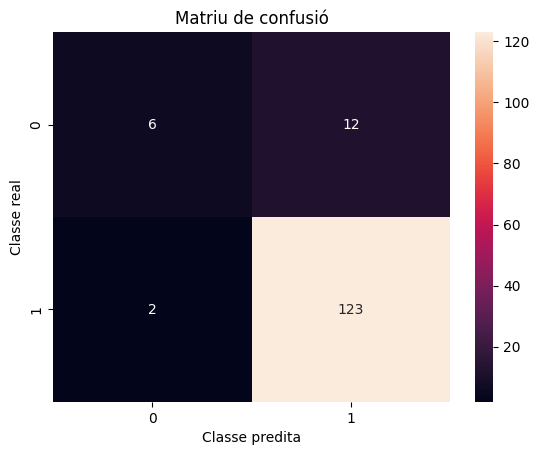

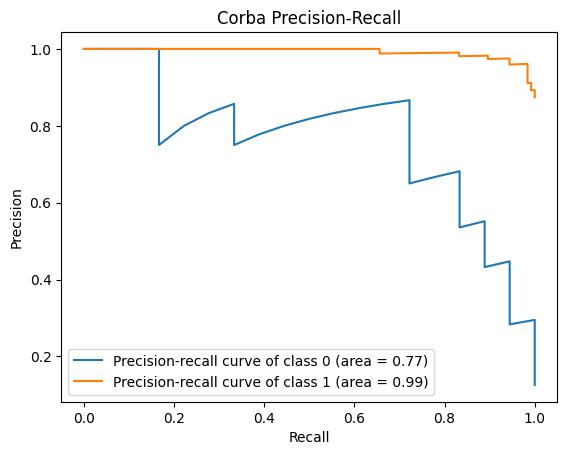

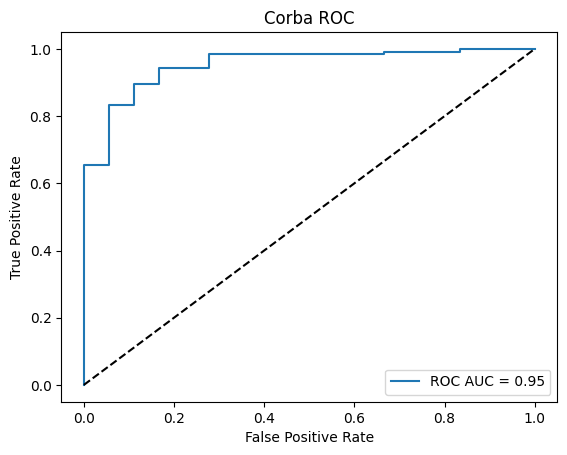

In [190]:
evaluate_model(best_model, x_aux, y, folds)

#### Single-layer FA amb selecció d'arestes

In [191]:
x = df4.drop(columns=["mstype", "edss"])
y = df4["mstype"]

In [192]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     10.480743   13.752801   11.985441    3.904961    7.319794   18.231549   
1      9.125421   12.224827   11.237358    3.135864    6.928494   17.358168   
2      9.485210   11.516828   11.480320    3.268007    6.716047   16.971244   
3      8.653527   12.395658   12.526438    3.878158    7.311625   17.678257   
4      8.975146   11.711132   10.632412    3.428517    6.764899   16.547216   
..          ...         ...         ...         ...         ...         ...   
138   10.210400   13.607235   12.625968    3.847231    7.684441   19.197031   
139   10.224815   13.303207   13.329064    3.720480    7.579796   19.590702   
140   10.683068   13.607567   13.262706    3.932663    7.957666   19.842491   
141   10.646996   13.581947   12.437514    3.654525    7.073533   18.396108   
142   10.902477   13.853444   13.395842    3.559879    7.694182   19.687285   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     11.152640   16.120626   15.554824    7.492134  ...     0.366174   
1     10.467688   16.112620   14.499703    6.747417  ...     0.357558   
2     10.307904   13.695429   13.569751    6.450834  ...     0.331607   
3     10.845597   16.008630   14.798309    7.716483  ...     0.351730   
4      9.980599   14.377907   13.730734    6.752295  ...     0.329242   
..          ...         ...         ...         ...  ...          ...   
138   10.971642   15.416932   16.285140    7.730024  ...     0.369414   
139   11.606020   16.257541   16.286737    7.869841  ...     0.369844   
140   11.961815   17.120877   16.688269    7.955804  ...     0.386842   
141   11.355159   15.741295   15.360904    7.712926  ...     0.370444   
142   11.936675   17.012043   16.103322    8.184430  ...     0.391857   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.347571     0.351386     0.313295     0.329664     0.349992   
1       0.332547     0.329169     0.299250     0.318856     0.334491   
2       0.305925     0.313836     0.282130     0.300120     0.308587   
3       0.338291     0.340875     0.304576     0.314246     0.340844   
4       0.310620     0.313607     0.285811     0.304329     0.313900   
..           ...          ...          ...          ...          ...   
138     0.355628     0.353957     0.313542     0.333481     0.357247   
139     0.354110     0.361299     0.322057     0.333878     0.356393   
140     0.366502     0.374723     0.330124     0.347692     0.369005   
141     0.341450     0.361039     0.314365     0.330653     0.345169   
142     0.361646     0.379568     0.336064     0.356525     0.365260   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.350801     0.368719     0.407565     0.350977  
1       0.334007     0.353251     0.406351     0.337033  
2       0.305261     0.326794     0.369318     0.307262  
3       0.339021     0.357157     0.397584     0.338548  
4       0.313439     0.328739     0.386930     0.311634  
..           ...          ...          ...          ...  
138     0.358730     0.373808     0.404694     0.356552  
139     0.356464     0.374923     0.416272     0.353249  
140     0.368466     0.394220     0.436364     0.368807  
141     0.345252     0.365292     0.403384     0.348461  
142     0.364548     0.387621     0.436751     0.367066  

[143 rows x 304 columns]

In [193]:
model = RandomForestClassifier(class_weight='balanced', random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [194]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_aux,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.892
Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


Accuracy:  0.8948275862068964
Precision:  0.8986772486772487
Recall:  0.992
F1-score:  0.9429608127721336


              precision    recall  f1-score   support

           0       0.80      0.22      0.35        18
           1       0.90      0.99      0.94       125

    accuracy                           0.90       143
   macro avg       0.85      0.61      0.65       143
weighted avg       0.89      0.90      0.87       143





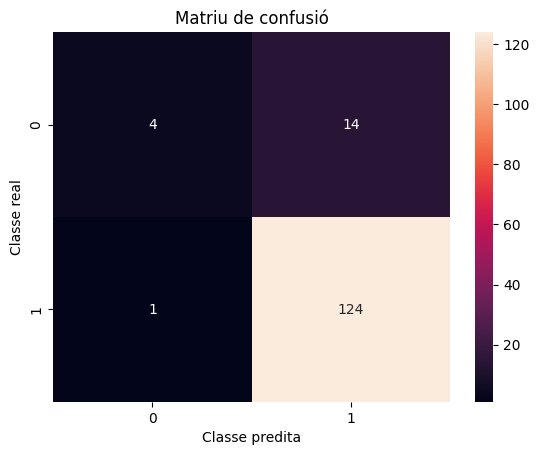

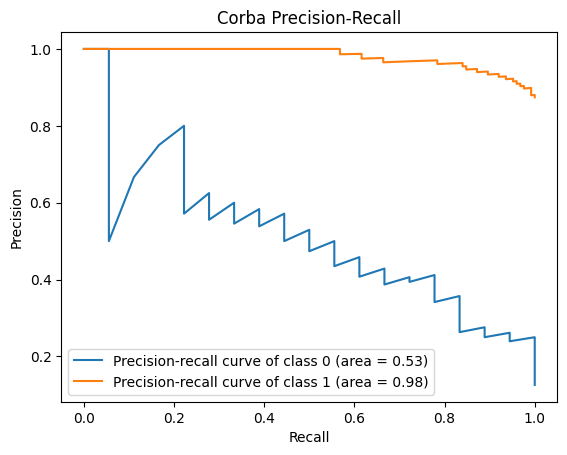

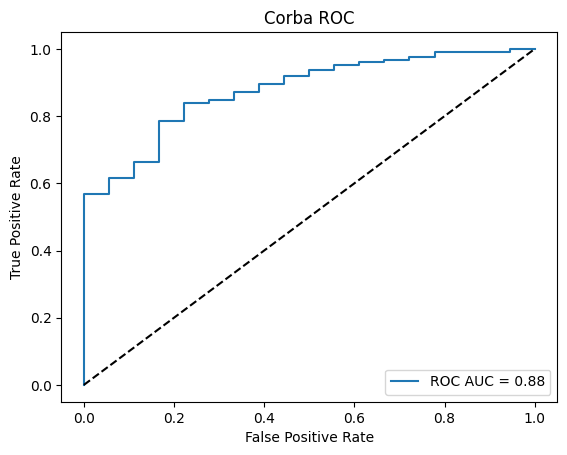

In [195]:
evaluate_model(best_model, x_aux, y, folds)

#### Single-layer GM amb selecció d'arestes

In [196]:
x = df5.drop(columns=["mstype", "edss"])
y = df5["mstype"]

In [197]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLUSTERING_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.019841    1.071230         0.0    0.043774    0.393293         0.0   
1      0.015682    1.076074         0.0    0.031175    0.422697         0.0   
2      0.015422    1.028716         0.0    0.028904    0.333530         0.0   
3      0.007920    0.906835         0.0    0.032805    0.353425         0.0   
4      0.011251    1.006105         0.0    0.034587    0.316551         0.0   
..          ...         ...         ...         ...         ...         ...   
138    0.017122    0.984011         0.0    0.030689    0.398288         0.0   
139    0.010652    0.973974         0.0    0.028148    0.350019         0.0   
140    0.017408    0.697690         0.0    0.029155    0.342529         0.0   
141    0.013695    0.864393         0.0    0.039029    0.406192         0.0   
142    0.015928    0.820201         0.0    0.026055    0.298889         0.0   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0      0.976328         0.0         0.0    1.239833  ...     0.053616   
1      0.898748         0.0         0.0    1.109160  ...     0.042610   
2      0.739178         0.0         0.0    0.945089  ...     0.043119   
3      0.660863         0.0         0.0    0.908107  ...     0.036749   
4      0.788985         0.0         0.0    0.919306  ...     0.037583   
..          ...         ...         ...         ...  ...          ...   
138    0.755185         0.0         0.0    1.013880  ...     0.044078   
139    0.754866         0.0         0.0    1.102764  ...     0.040176   
140    0.706787         0.0         0.0    1.038116  ...     0.042352   
141    0.836240         0.0         0.0    0.977471  ...     0.042278   
142    0.698201         0.0         0.0    0.944805  ...     0.040608   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.029447          0.0     0.048761     0.122305     0.062666   
1       0.022855          0.0     0.045030     0.108926     0.058505   
2       0.021756          0.0     0.037138     0.105784     0.047611   
3       0.018812          0.0     0.034628     0.093252     0.044173   
4       0.020567          0.0     0.036909     0.101007     0.047629   
..           ...          ...          ...          ...          ...   
138     0.024908          0.0     0.037907     0.103998     0.048492   
139     0.022320          0.0     0.038711     0.107093     0.051292   
140     0.022598          0.0     0.036792     0.108316     0.048832   
141     0.021248          0.0     0.040721     0.112127     0.052049   
142     0.021907          0.0     0.036940     0.101944     0.048015   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0            0.0     0.051184          0.0          0.0  
1            0.0     0.047240          0.0          0.0  
2            0.0     0.040166          0.0          0.0  
3            0.0     0.035551          0.0          0.0  
4            0.0     0.037390          0.0          0.0  
..           ...          ...          ...          ...  
138          0.0     0.038634          0.0          0.0  
139          0.0     0.042021          0.0          0.0  
140          0.0     0.040443          0.0          0.0  
141          0.0     0.041713          0.0          0.0  
142          0.0     0.039865          0.0          0.0  

[143 rows x 304 columns]

In [198]:
model = RandomForestClassifier(class_weight='balanced', random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [199]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_aux,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.8933333333333333
Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}


Accuracy:  0.8748768472906404
Precision:  0.910259946949602
Recall:  0.952
F1-score:  0.9299694989106755


              precision    recall  f1-score   support

           0       0.50      0.33      0.40        18
           1       0.91      0.95      0.93       125

    accuracy                           0.87       143
   macro avg       0.70      0.64      0.66       143
weighted avg       0.86      0.87      0.86       143





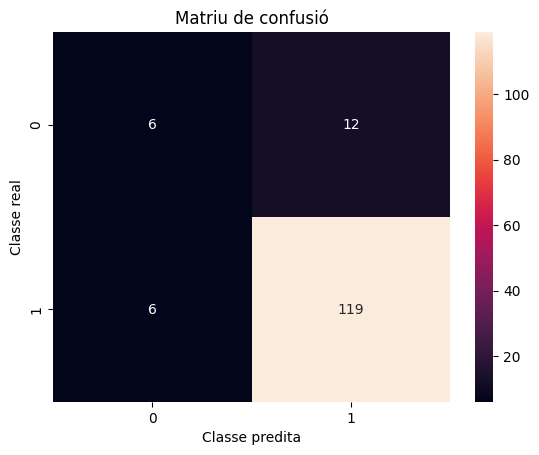

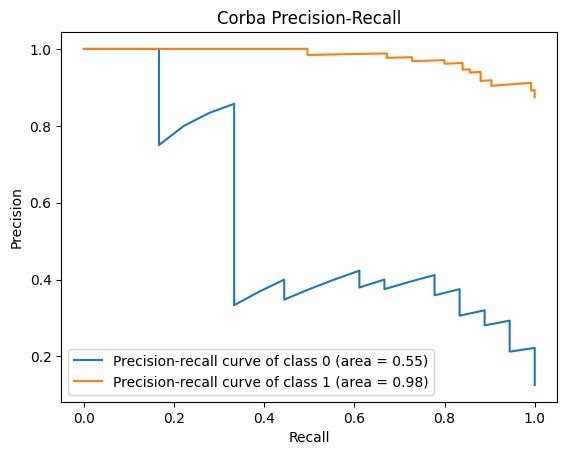

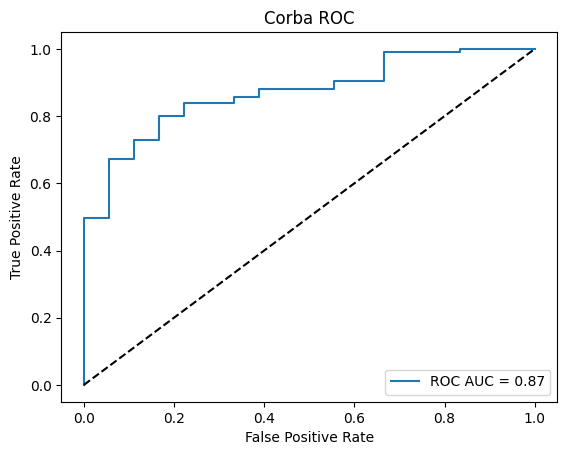

In [200]:
evaluate_model(best_model, x_aux, y, folds)

#### Single-layer RS amb selecció d'arestes

In [201]:
x = df6.drop(columns=["mstype", "edss"])
y = df6["mstype"]

In [202]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.012933    2.348639    0.360878    0.885770    0.393900    0.972382   
1      0.003975    2.726700    0.131439    0.715023    0.214531    2.471565   
2      0.200010    2.014228    0.145752    1.039974    0.199996    1.972205   
3      0.240419    2.026085    0.169388    0.352393    0.110515    0.779757   
4      0.099655    1.654091    0.123295    0.359920    0.573203    2.074003   
..          ...         ...         ...         ...         ...         ...   
138    0.188746    1.469097    0.200427    0.699645    0.550311    1.209628   
139    0.037275    2.026848    0.326434    1.339552    0.530562    1.206475   
140    0.464743    2.806839    0.172201    0.997629    0.286775    1.648569   
141    0.442102    2.537264    0.781671    0.248065    0.672784    1.760105   
142    0.136801    2.320443    0.453455    0.386100    0.696499    1.156316   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Closeness_66  \
0      0.850745    2.016915    0.580912    1.167222  ...      0.083292   
1      1.727396    2.427895    0.399093    1.123919  ...      0.041296   
2      1.320393    1.867797    0.322074    1.056015  ...      0.055046   
3      1.869373    2.347688    0.734247    0.870663  ...      0.048250   
4      2.176057    1.500469    0.702256    1.567838  ...      0.076433   
..          ...         ...         ...         ...  ...           ...   
138    2.372779    2.828015    1.190513    0.369914  ...      0.074611   
139    2.704915    3.267510    1.011183    0.478804  ...      0.084785   
140    1.864716    3.243940    0.933774    0.705951  ...      0.092559   
141    3.090962    1.933011    1.087764    0.766715  ...      0.074004   
142    2.142419    2.048093    1.403611    0.646971  ...      0.081006   

     Closeness_67  Closeness_68  Closeness_69  Closeness_70  Closeness_71  \
0        0.072190      0.087037      0.069026      0.084071      0.076569   
1        0.064091      0.063129      0.052690      0.064843      0.062258   
2        0.082964      0.082376      0.057546      0.073840      0.074692   
3        0.058720      0.061321      0.051648      0.050016      0.058505   
4        0.090418      0.086879      0.077219      0.108275      0.105883   
..            ...           ...           ...           ...           ...   
138      0.077402      0.119901      0.060655      0.072363      0.092725   
139      0.094141      0.103530      0.071243      0.088394      0.117761   
140      0.077154      0.117794      0.063638      0.101060      0.099169   
141      0.088640      0.135949      0.065186      0.085139      0.141878   
142      0.098732      0.100545      0.059204      0.078331      0.101467   

     Closeness_72  Closeness_73  Closeness_74  Closeness_75  
0        0.097971      0.102868      0.076970      0.098043  
1        0.062854      0.070566      0.053445      0.047637  
2        0.086000      0.090734      0.081605      0.075461  
3        0.063299      0.065723      0.047770      0.045452  
4        0.108323      0.113074      0.073160      0.074640  
..            ...           ...           ...           ...  
138      0.091099      0.106720      0.078426      0.091700  
139      0.093489      0.135388      0.108168      0.110939  
140      0.104966      0.128786      0.102709      0.117524  
141      0.087730      0.140445      0.088402      0.046514  
142      0.090594      0.131361      0.077406      0.099463  

[143 rows x 228 columns]

In [203]:
model = RandomForestClassifier(class_weight='balanced', random_state=1)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [204]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_aux,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.9206666666666667
Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}


Accuracy:  0.930049261083744
Precision:  0.9264346764346765
Recall:  1.0
F1-score:  0.9616807535786448


              precision    recall  f1-score   support

           0       1.00      0.44      0.62        18
           1       0.93      1.00      0.96       125

    accuracy                           0.93       143
   macro avg       0.96      0.72      0.79       143
weighted avg       0.94      0.93      0.92       143





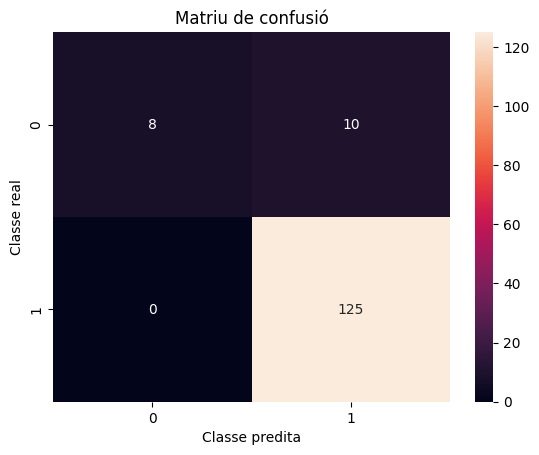

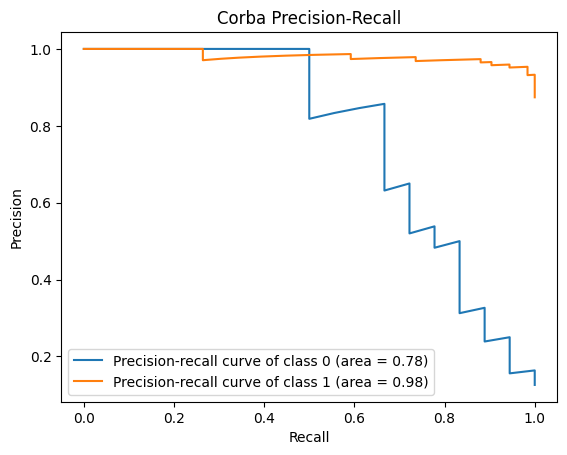

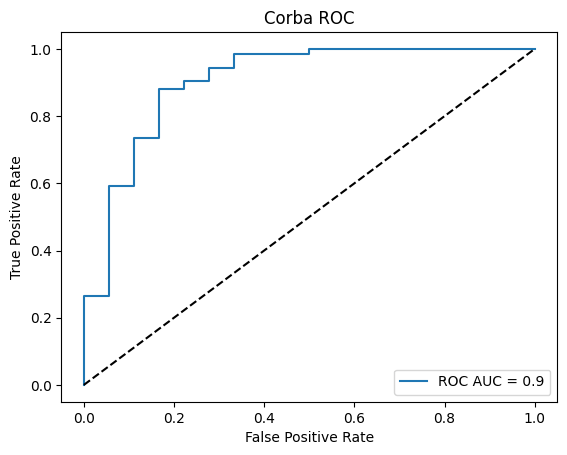

In [205]:
evaluate_model(best_model, x_aux, y, folds)

### Xarxes neuronals

#### Single-layer FA

In [206]:
x = df0.drop(columns=["mstype", "edss"])
y = df0["mstype"]

In [207]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     16.404345   19.934244   16.880274    6.925231   14.868683   27.237312   
1     14.564263   17.414928   15.134213    5.905397   12.780386   25.289463   
2     14.640516   16.196333   15.413794    6.149666   12.940156   24.447312   
3     14.117944   17.741166   17.888479    6.445422   17.751425   26.187135   
4     13.724987   16.343087   14.283896    6.545274   12.585314   22.759765   
..          ...         ...         ...         ...         ...         ...   
138   16.655485   19.146539   16.700146    7.617889   15.122495   25.956406   
139   15.134368   18.966089   17.424447    7.922187   15.291565   30.148821   
140   16.325812   19.457503   17.617547    6.979297   16.901045   28.585863   
141   14.223149   19.131217   14.883435    6.763010   12.154140   26.442900   
142   17.473569   20.529582   17.007257    6.597956   17.569032   27.068842   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     18.612786   23.729318   21.594440   17.103820  ...     0.404505   
1     17.176270   23.635124   20.064056   15.310251  ...     0.390676   
2     15.987123   21.234674   18.726902   14.535856  ...     0.362479   
3     18.658421   24.892061   21.659486   18.235656  ...     0.394411   
4     15.292995   20.699393   18.216965   14.939408  ...     0.363037   
..          ...         ...         ...         ...  ...          ...   
138   16.590008   23.546366   20.671853   19.548557  ...     0.399674   
139   19.847248   22.669545   24.042802   16.325941  ...     0.411943   
140   19.822967   25.647492   23.739913   18.541144  ...     0.425353   
141   15.966015   21.184424   19.354855   18.554706  ...     0.395527   
142   19.064165   26.884717   22.827824   18.531157  ...     0.425194   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.368982     0.361477     0.370647     0.372325     0.368709   
1       0.350216     0.346396     0.361291     0.357996     0.347928   
2       0.321137     0.323869     0.336609     0.335159     0.321751   
3       0.362457     0.366912     0.369140     0.364528     0.365627   
4       0.324367     0.328578     0.336544     0.335277     0.327869   
..           ...          ...          ...          ...          ...   
138     0.374968     0.366035     0.369722     0.374695     0.371155   
139     0.374835     0.369715     0.386245     0.384630     0.378543   
140     0.391793     0.381743     0.395079     0.393692     0.389168   
141     0.353635     0.360722     0.365122     0.365420     0.356498   
142     0.381919     0.381989     0.395951     0.394887     0.384462   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.376409     0.394584     0.444697     0.375068  
1       0.357892     0.380326     0.444446     0.358053  
2       0.331129     0.353703     0.396242     0.331454  
3       0.365138     0.386367     0.439351     0.366825  
4       0.324115     0.350394     0.407564     0.332249  
..           ...          ...          ...          ...  
138     0.375221     0.392292     0.451109     0.377678  
139     0.378105     0.405994     0.462343     0.380065  
140     0.392857     0.423258     0.477610     0.394553  
141     0.359573     0.382538     0.440241     0.366621  
142     0.386017     0.410103     0.459256     0.390308  

[143 rows x 228 columns]

In [208]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [209]:
model = MLPClassifier(random_state=1, early_stopping=True)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [210]:
param_grid = {
    'hidden_layer_sizes': [(200,), (100, 100), (50, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Best Score: 0.6920000000000001
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'adam'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy:  0.12561576354679801


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Precision:  0.0
Recall:  0.0
F1-score:  0.0


              precision    recall  f1-score   support

           0       0.13      1.00      0.22        18
           1       0.00      0.00      0.00       125

    accuracy                           0.13       143
   macro avg       0.06      0.50      0.11       143
weighted avg       0.02      0.13      0.03       143





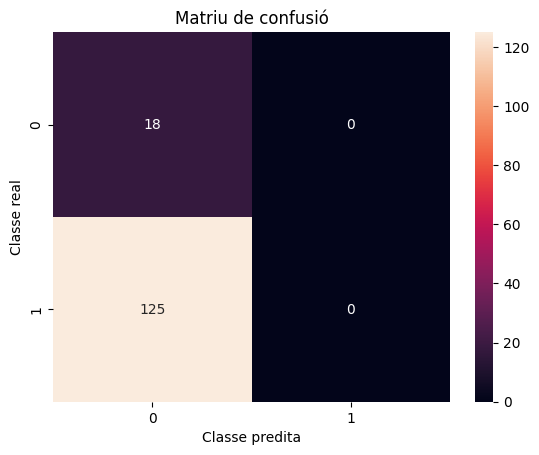

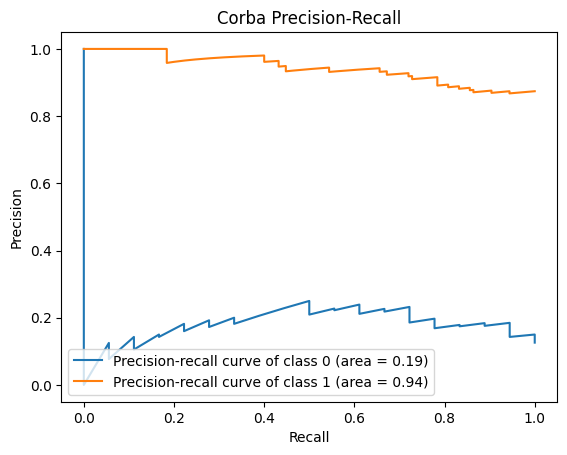

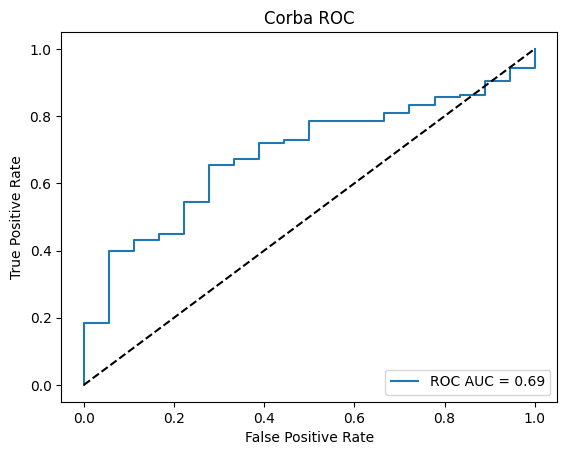

In [211]:
evaluate_model(best_model, x_scaled, y, folds)

#### Multi-layer estàndar

In [212]:
x = df1.drop(columns=["mstype", "edss"])
y = df1["mstype"]

In [213]:
x_aux = x[DEGREE_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Degree_0  Degree_1  Degree_2  Degree_3  Degree_4  Degree_5  Degree_6  \
0    0.760000  0.793333  0.746667  0.640000  0.733333  0.906667  0.786667   
1    0.746667  0.780000  0.740000  0.640000  0.726667  0.906667  0.793333   
2    0.753333  0.780000  0.753333  0.646667  0.740000  0.900000  0.780000   
3    0.746667  0.793333  0.753333  0.626667  0.773333  0.906667  0.793333   
4    0.733333  0.780000  0.740000  0.640000  0.733333  0.886667  0.773333   
..        ...       ...       ...       ...       ...       ...       ...   
138  0.766667  0.786667  0.746667  0.653333  0.746667  0.893333  0.786667   
139  0.740000  0.780000  0.753333  0.660000  0.740000  0.906667  0.793333   
140  0.753333  0.786667  0.746667  0.640000  0.760000  0.900000  0.793333   
141  0.720000  0.786667  0.746667  0.633333  0.740000  0.906667  0.773333   
142  0.753333  0.793333  0.753333  0.633333  0.766667  0.893333  0.793333   

     Degree_7  Degree_8  Degree_9  ...  Local_ef_66  Local_ef_67  Local_ef_68  \
0    0.846667  0.813333  0.793333  ...     0.000073     0.000073     0.000074   
1    0.846667  0.826667  0.800000  ...     0.000075     0.000075     0.000076   
2    0.860000  0.813333  0.793333  ...     0.000065     0.000065     0.000066   
3    0.866667  0.820000  0.800000  ...     0.000071     0.000071     0.000071   
4    0.826667  0.813333  0.800000  ...     0.000078     0.000078     0.000078   
..        ...       ...       ...  ...          ...          ...          ...   
138  0.840000  0.820000  0.820000  ...     0.000071     0.000071     0.000071   
139  0.820000  0.826667  0.780000  ...     0.000075     0.000075     0.000075   
140  0.846667  0.826667  0.820000  ...     0.000078     0.000078     0.000079   
141  0.806667  0.820000  0.800000  ...     0.000077     0.000077     0.000078   
142  0.860000  0.826667  0.813333  ...     0.000074     0.000074     0.000075   

     Local_ef_69  Local_ef_70  Local_ef_71  Local_ef_72  Local_ef_73  \
0       0.000073     0.000073     0.000073     0.000073     0.000073   
1       0.000075     0.000075     0.000075     0.000075     0.000075   
2       0.000066     0.000065     0.000066     0.000066     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000079     0.000078     0.000078     0.000078     0.000079   
141     0.000077     0.000077     0.000077     0.000077     0.000077   
142     0.000075     0.000074     0.000074     0.000075     0.000075   

     Local_ef_74  Local_ef_75  
0       0.000073     0.000073  
1       0.000076     0.000075  
2       0.000066     0.000066  
3       0.000071     0.000071  
4       0.000078     0.000078  
..           ...          ...  
138     0.000072     0.000071  
139     0.000075     0.000075  
140     0.000079     0.000078  
141     0.000078     0.000078  
142     0.000075     0.000075  

[143 rows x 228 columns]

In [214]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [215]:
model = MLPClassifier(random_state=1, early_stopping=True)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [216]:
param_grid = {
    'hidden_layer_sizes': [(200,), (100, 100), (50, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Best Score: 0.8566666666666667
Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'lbfgs'}


Accuracy:  0.8598522167487683
Precision:  0.9091692236909628
Recall:  0.9359999999999999
F1-score:  0.9213278124021743


              precision    recall  f1-score   support

           0       0.43      0.33      0.38        18
           1       0.91      0.94      0.92       125

    accuracy                           0.86       143
   macro avg       0.67      0.63      0.65       143
weighted avg       0.85      0.86      0.85       143





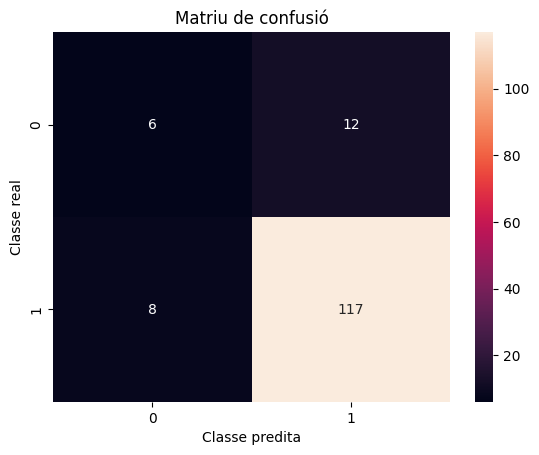

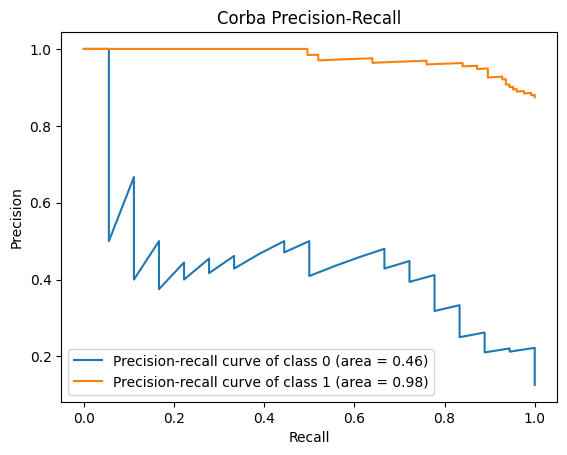

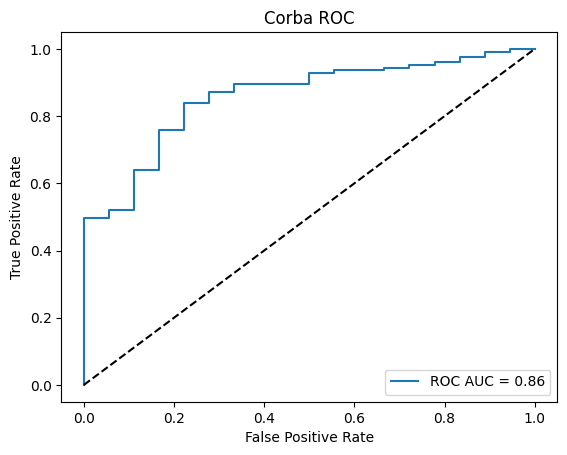

In [217]:
evaluate_model(best_model, x_scaled, y, folds)

#### Multi-layer amb thresholds

In [218]:
x = df2.drop(columns=["mstype", "edss"])
y = df2["mstype"]

In [219]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     59.546602   68.333008   52.062053   36.739089   54.399312   79.505457   
1     59.342370   69.089420   46.414456   28.759438   41.218641   85.061355   
2     44.482329   56.744913   47.792154   36.080874   38.740484   75.261471   
3     46.960781   59.721461   55.798446   28.772582   61.328655   74.071169   
4     54.790684   65.087871   47.325377   35.609662   56.441072   78.020789   
..          ...         ...         ...         ...         ...         ...   
138   48.050861   55.402142   53.238721   30.622538   55.201940   72.899173   
139   45.391052   61.082332   51.016888   39.196244   55.434633   82.234660   
140   61.280921   70.667780   57.908244   35.386812   49.842565   92.770859   
141   58.335901   69.351670   55.355230   32.585370   62.220438   86.858121   
142   52.966774   70.356110   59.456978   37.312291   58.239141   85.348509   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     62.886745   68.902278   73.267825   54.372685  ...     0.000073   
1     67.663033   70.354827   67.883736   59.382047  ...     0.000075   
2     50.185999   60.596573   64.768141   51.507843  ...     0.000065   
3     61.505285   69.114256   70.977930   55.426774  ...     0.000071   
4     65.359995   57.327700   73.273259   59.177871  ...     0.000078   
..          ...         ...         ...         ...  ...          ...   
138   58.730404   67.882382   64.668107   55.426587  ...     0.000071   
139   65.822946   67.285455   75.975785   52.644798  ...     0.000075   
140   58.987973   72.287588   71.549908   63.019200  ...     0.000078   
141   68.393011   55.036246   77.030050   54.511331  ...     0.000077   
142   63.064644   69.417201   76.548589   60.935065  ...     0.000074   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.000073     0.000074     0.000073     0.000073     0.000073   
1       0.000075     0.000076     0.000075     0.000075     0.000075   
2       0.000065     0.000066     0.000066     0.000065     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000078     0.000079     0.000079     0.000078     0.000078   
141     0.000077     0.000078     0.000077     0.000077     0.000077   
142     0.000074     0.000075     0.000075     0.000074     0.000074   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000073     0.000073     0.000073     0.000073  
1       0.000075     0.000075     0.000076     0.000075  
2       0.000066     0.000066     0.000066     0.000066  
3       0.000071     0.000071     0.000071     0.000071  
4       0.000078     0.000078     0.000078     0.000078  
..           ...          ...          ...          ...  
138     0.000071     0.000071     0.000072     0.000071  
139     0.000075     0.000075     0.000075     0.000075  
140     0.000078     0.000079     0.000079     0.000078  
141     0.000077     0.000077     0.000078     0.000078  
142     0.000075     0.000075     0.000075     0.000075  

[143 rows x 228 columns]

In [220]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [221]:
model = MLPClassifier(random_state=1, early_stopping=True)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [222]:
param_grid = {
    'hidden_layer_sizes': [(200,), (100, 100), (50, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Best Score: 0.8373333333333333
Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'lbfgs'}


Accuracy:  0.8529556650246306
Precision:  0.8845747126436783
Recall:  0.96
F1-score:  0.9191473922902494


              precision    recall  f1-score   support

           0       0.29      0.11      0.16        18
           1       0.88      0.96      0.92       125

    accuracy                           0.85       143
   macro avg       0.58      0.54      0.54       143
weighted avg       0.81      0.85      0.82       143





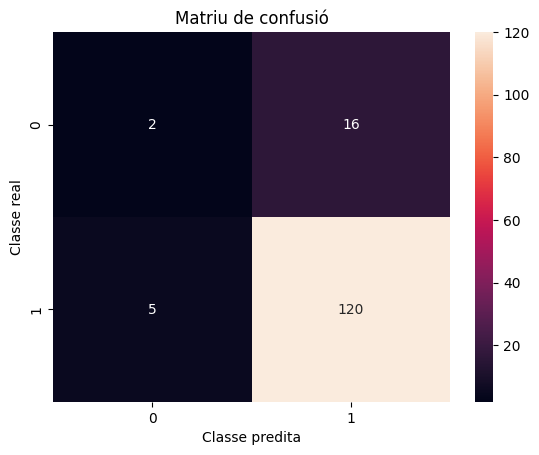

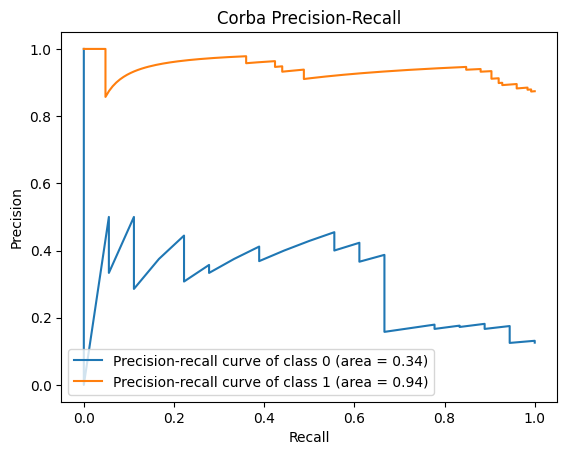

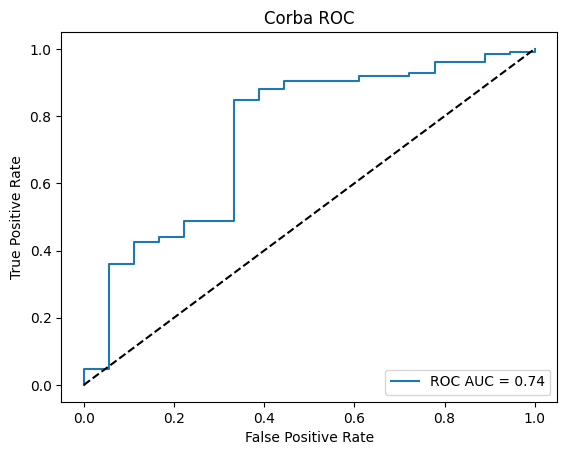

In [223]:
evaluate_model(best_model, x_scaled, y, folds)

#### Multilayer amb selecció d'arestes

In [224]:
x = df3.drop(columns=["mstype", "edss"])
y = df3["mstype"]

In [225]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS+CLUSTERING_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     20.994261   30.925471   24.331761    8.739466   15.426781   37.435479   
1     18.270499   28.252429   22.606156    7.017927   14.494215   37.187900   
2     19.185853   26.076601   23.106392    7.604893   13.965619   35.914693   
3     17.555392   27.724236   25.222265    8.141513   15.087189   36.136272   
4     18.061197   26.082460   21.388118    7.251541   14.419552   35.168434   
..          ...         ...         ...         ...         ...         ...   
138   20.626668   29.667578   25.452363    8.424795   16.317481   39.603689   
139   20.497556   29.607237   26.984561    8.808661   16.040173   40.387879   
140   21.848286   30.719663   26.697613    8.892110   16.544635   41.333551   
141   21.749789   30.565550   25.656699    7.596144   15.226042   38.552321   
142   21.957683   30.847532   27.245140    7.531913   16.383752   40.530886   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Clustering_66  \
0     24.132352   34.258167   31.690560   17.391322  ...       0.262686   
1     23.561520   34.653134   29.398500   15.727913  ...       0.259152   
2     22.675379   29.258655   27.461576   14.902771  ...       0.231151   
3     24.221430   34.364947   30.330865   17.211736  ...       0.246136   
4     22.926240   30.256283   28.163724   15.991734  ...       0.233838   
..          ...         ...         ...         ...  ...            ...   
138   25.071249   33.661879   33.760792   16.843842  ...       0.257027   
139   26.671820   35.782592   33.584656   17.321250  ...       0.260511   
140   26.495133   37.485694   34.310312   17.655675  ...       0.273885   
141   26.637520   33.415602   31.809572   17.170038  ...       0.258600   
142   26.713970   36.072178   33.610254   17.960635  ...       0.274906   

     Clustering_67  Clustering_68  Clustering_69  Clustering_70  \
0         0.228612       0.180449       0.184191       0.225981   
1         0.217801       0.172728       0.172225       0.225102   
2         0.204306       0.177683       0.164646       0.207126   
3         0.218830       0.166751       0.170944       0.208105   
4         0.206379       0.175266       0.167263       0.212348   
..             ...            ...            ...            ...   
138       0.235204       0.199069       0.172068       0.216878   
139       0.241631       0.191053       0.188079       0.220715   
140       0.240977       0.196357       0.185042       0.239115   
141       0.230021       0.200203       0.180050       0.226098   
142       0.246114       0.193993       0.190883       0.243752   

     Clustering_71  Clustering_72  Clustering_73  Clustering_74  Clustering_75  
0         0.235822       0.225125       0.229932       0.283444       0.244066  
1         0.225663       0.223304       0.219951       0.276597       0.230390  
2         0.207851       0.198928       0.199322       0.270727       0.216008  
3         0.225049       0.220563       0.206981       0.269224       0.232298  
4         0.208362       0.206946       0.196351       0.254061       0.217717  
..             ...            ...            ...            ...            ...  
138       0.238301       0.214904       0.222357       0.270879       0.231433  
139       0.245768       0.226934       0.229259       0.301581       0.251032  
140       0.250848       0.240701       0.234888       0.299663       0.257560  
141       0.237616       0.215016       0.223589       0.276849       0.235403  
142       0.249174       0.237190       0.236223       0.299742       0.254543  

[143 rows x 304 columns]

In [226]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [227]:
model = MLPClassifier(random_state=1, early_stopping=True)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [228]:
param_grid = {
    'hidden_layer_sizes': [(200,), (100, 100), (50, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Best Score: 0.992
Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'lbfgs'}


Accuracy:  0.9438423645320198
Precision:  0.9623703703703704
Recall:  0.976
F1-score:  0.9684521193092621


              precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.96      0.98      0.97       125

    accuracy                           0.94       143
   macro avg       0.89      0.85      0.87       143
weighted avg       0.94      0.94      0.94       143





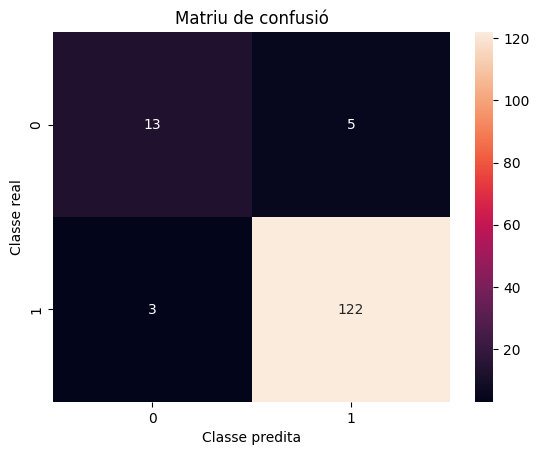

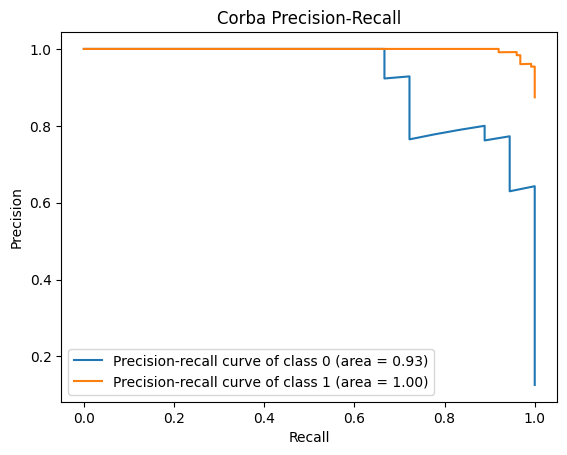

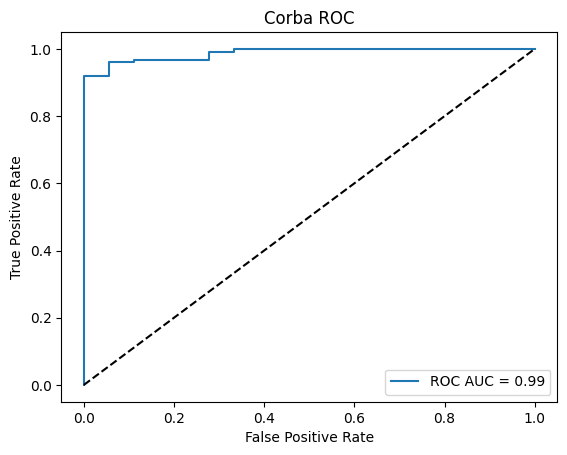

In [229]:
evaluate_model(best_model, x_scaled, y, folds)

#### Single-layer FA amb selecció d'arestes

In [290]:
x = df4.drop(columns=["mstype", "edss"])
y = df4["mstype"]

In [291]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     10.480743   13.752801   11.985441    3.904961    7.319794   18.231549   
1      9.125421   12.224827   11.237358    3.135864    6.928494   17.358168   
2      9.485210   11.516828   11.480320    3.268007    6.716047   16.971244   
3      8.653527   12.395658   12.526438    3.878158    7.311625   17.678257   
4      8.975146   11.711132   10.632412    3.428517    6.764899   16.547216   
..          ...         ...         ...         ...         ...         ...   
138   10.210400   13.607235   12.625968    3.847231    7.684441   19.197031   
139   10.224815   13.303207   13.329064    3.720480    7.579796   19.590702   
140   10.683068   13.607567   13.262706    3.932663    7.957666   19.842491   
141   10.646996   13.581947   12.437514    3.654525    7.073533   18.396108   
142   10.902477   13.853444   13.395842    3.559879    7.694182   19.687285   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     11.152640   16.120626   15.554824    7.492134  ...     0.366174   
1     10.467688   16.112620   14.499703    6.747417  ...     0.357558   
2     10.307904   13.695429   13.569751    6.450834  ...     0.331607   
3     10.845597   16.008630   14.798309    7.716483  ...     0.351730   
4      9.980599   14.377907   13.730734    6.752295  ...     0.329242   
..          ...         ...         ...         ...  ...          ...   
138   10.971642   15.416932   16.285140    7.730024  ...     0.369414   
139   11.606020   16.257541   16.286737    7.869841  ...     0.369844   
140   11.961815   17.120877   16.688269    7.955804  ...     0.386842   
141   11.355159   15.741295   15.360904    7.712926  ...     0.370444   
142   11.936675   17.012043   16.103322    8.184430  ...     0.391857   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.347571     0.351386     0.313295     0.329664     0.349992   
1       0.332547     0.329169     0.299250     0.318856     0.334491   
2       0.305925     0.313836     0.282130     0.300120     0.308587   
3       0.338291     0.340875     0.304576     0.314246     0.340844   
4       0.310620     0.313607     0.285811     0.304329     0.313900   
..           ...          ...          ...          ...          ...   
138     0.355628     0.353957     0.313542     0.333481     0.357247   
139     0.354110     0.361299     0.322057     0.333878     0.356393   
140     0.366502     0.374723     0.330124     0.347692     0.369005   
141     0.341450     0.361039     0.314365     0.330653     0.345169   
142     0.361646     0.379568     0.336064     0.356525     0.365260   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.350801     0.368719     0.407565     0.350977  
1       0.334007     0.353251     0.406351     0.337033  
2       0.305261     0.326794     0.369318     0.307262  
3       0.339021     0.357157     0.397584     0.338548  
4       0.313439     0.328739     0.386930     0.311634  
..           ...          ...          ...          ...  
138     0.358730     0.373808     0.404694     0.356552  
139     0.356464     0.374923     0.416272     0.353249  
140     0.368466     0.394220     0.436364     0.368807  
141     0.345252     0.365292     0.403384     0.348461  
142     0.364548     0.387621     0.436751     0.367066  

[143 rows x 304 columns]

In [292]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [293]:
model = MLPClassifier(random_state=1, early_stopping=True)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [294]:
param_grid = {
    'hidden_layer_sizes': [(200,), (100, 100), (50, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Best Score: 0.924
Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Accuracy:  0.8741379310344828


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Precision:  0.9109049541163484


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Recall:  0.952


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

F1-score:  0.9294330579191845




/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        18
           1       0.91      0.95      0.93       125

    accuracy                           0.87       143
   macro avg       0.70      0.64      0.66       143
weighted avg       0.86      0.87      0.86       143





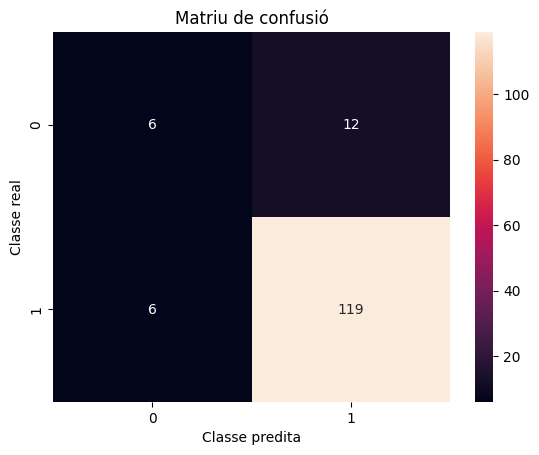

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

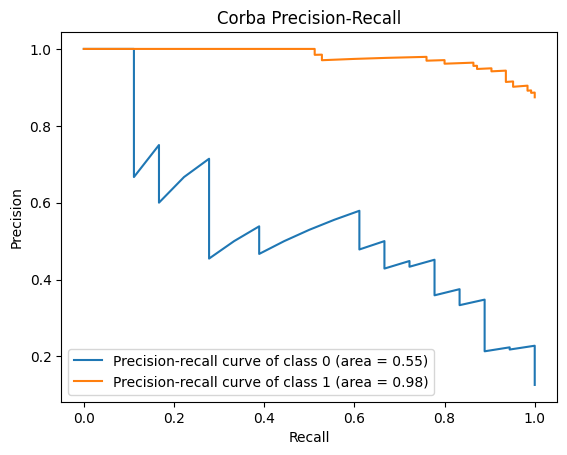

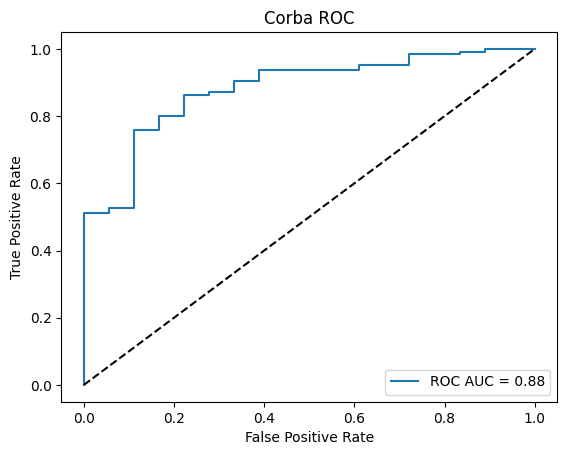

In [295]:
evaluate_model(best_model, x_scaled, y, folds)

#### Single-layer GM amb selecció d'arestes

In [296]:
x = df5.drop(columns=["mstype", "edss"])
y = df5["mstype"]

In [297]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLUSTERING_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.019841    1.071230         0.0    0.043774    0.393293         0.0   
1      0.015682    1.076074         0.0    0.031175    0.422697         0.0   
2      0.015422    1.028716         0.0    0.028904    0.333530         0.0   
3      0.007920    0.906835         0.0    0.032805    0.353425         0.0   
4      0.011251    1.006105         0.0    0.034587    0.316551         0.0   
..          ...         ...         ...         ...         ...         ...   
138    0.017122    0.984011         0.0    0.030689    0.398288         0.0   
139    0.010652    0.973974         0.0    0.028148    0.350019         0.0   
140    0.017408    0.697690         0.0    0.029155    0.342529         0.0   
141    0.013695    0.864393         0.0    0.039029    0.406192         0.0   
142    0.015928    0.820201         0.0    0.026055    0.298889         0.0   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0      0.976328         0.0         0.0    1.239833  ...     0.053616   
1      0.898748         0.0         0.0    1.109160  ...     0.042610   
2      0.739178         0.0         0.0    0.945089  ...     0.043119   
3      0.660863         0.0         0.0    0.908107  ...     0.036749   
4      0.788985         0.0         0.0    0.919306  ...     0.037583   
..          ...         ...         ...         ...  ...          ...   
138    0.755185         0.0         0.0    1.013880  ...     0.044078   
139    0.754866         0.0         0.0    1.102764  ...     0.040176   
140    0.706787         0.0         0.0    1.038116  ...     0.042352   
141    0.836240         0.0         0.0    0.977471  ...     0.042278   
142    0.698201         0.0         0.0    0.944805  ...     0.040608   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.029447          0.0     0.048761     0.122305     0.062666   
1       0.022855          0.0     0.045030     0.108926     0.058505   
2       0.021756          0.0     0.037138     0.105784     0.047611   
3       0.018812          0.0     0.034628     0.093252     0.044173   
4       0.020567          0.0     0.036909     0.101007     0.047629   
..           ...          ...          ...          ...          ...   
138     0.024908          0.0     0.037907     0.103998     0.048492   
139     0.022320          0.0     0.038711     0.107093     0.051292   
140     0.022598          0.0     0.036792     0.108316     0.048832   
141     0.021248          0.0     0.040721     0.112127     0.052049   
142     0.021907          0.0     0.036940     0.101944     0.048015   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0            0.0     0.051184          0.0          0.0  
1            0.0     0.047240          0.0          0.0  
2            0.0     0.040166          0.0          0.0  
3            0.0     0.035551          0.0          0.0  
4            0.0     0.037390          0.0          0.0  
..           ...          ...          ...          ...  
138          0.0     0.038634          0.0          0.0  
139          0.0     0.042021          0.0          0.0  
140          0.0     0.040443          0.0          0.0  
141          0.0     0.041713          0.0          0.0  
142          0.0     0.039865          0.0          0.0  

[143 rows x 304 columns]

In [298]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [299]:
model = MLPClassifier(random_state=1, early_stopping=True)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [300]:
param_grid = {
    'hidden_layer_sizes': [(200,), (100, 100), (50, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Best Score: 0.8013333333333332
Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'lbfgs'}


Accuracy:  0.825615763546798
Precision:  0.9142607392607391
Recall:  0.8879999999999999
F1-score:  0.8989102505715252


              precision    recall  f1-score   support

           0       0.33      0.39      0.36        18
           1       0.91      0.89      0.90       125

    accuracy                           0.83       143
   macro avg       0.62      0.64      0.63       143
weighted avg       0.84      0.83      0.83       143





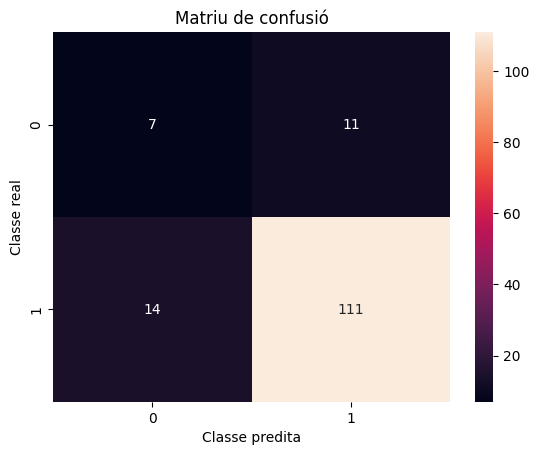

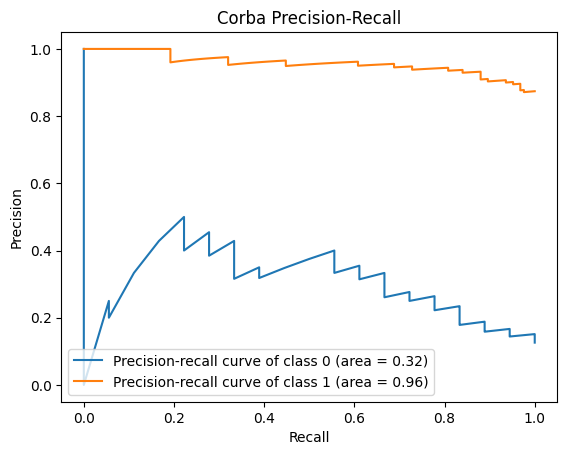

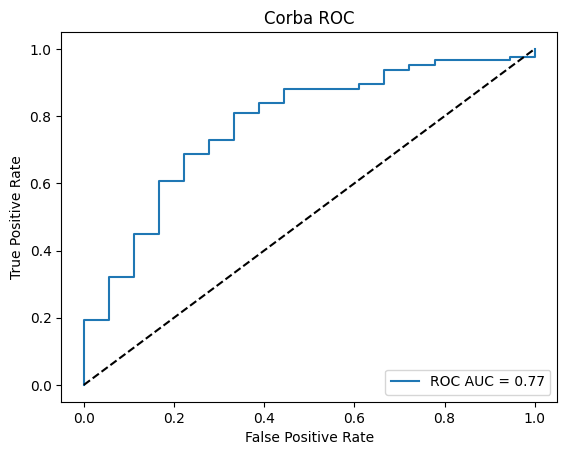

In [301]:
evaluate_model(best_model, x_scaled, y, folds)

#### Single-layer RS amb selecció d'arestes

In [242]:
x = df6.drop(columns=["mstype", "edss"])
y = df6["mstype"]

In [243]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+CLOSENESS_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.012933    2.348639    0.360878    0.885770    0.393900    0.972382   
1      0.003975    2.726700    0.131439    0.715023    0.214531    2.471565   
2      0.200010    2.014228    0.145752    1.039974    0.199996    1.972205   
3      0.240419    2.026085    0.169388    0.352393    0.110515    0.779757   
4      0.099655    1.654091    0.123295    0.359920    0.573203    2.074003   
..          ...         ...         ...         ...         ...         ...   
138    0.188746    1.469097    0.200427    0.699645    0.550311    1.209628   
139    0.037275    2.026848    0.326434    1.339552    0.530562    1.206475   
140    0.464743    2.806839    0.172201    0.997629    0.286775    1.648569   
141    0.442102    2.537264    0.781671    0.248065    0.672784    1.760105   
142    0.136801    2.320443    0.453455    0.386100    0.696499    1.156316   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Closeness_66  \
0      0.850745    2.016915    0.580912    1.167222  ...      0.083292   
1      1.727396    2.427895    0.399093    1.123919  ...      0.041296   
2      1.320393    1.867797    0.322074    1.056015  ...      0.055046   
3      1.869373    2.347688    0.734247    0.870663  ...      0.048250   
4      2.176057    1.500469    0.702256    1.567838  ...      0.076433   
..          ...         ...         ...         ...  ...           ...   
138    2.372779    2.828015    1.190513    0.369914  ...      0.074611   
139    2.704915    3.267510    1.011183    0.478804  ...      0.084785   
140    1.864716    3.243940    0.933774    0.705951  ...      0.092559   
141    3.090962    1.933011    1.087764    0.766715  ...      0.074004   
142    2.142419    2.048093    1.403611    0.646971  ...      0.081006   

     Closeness_67  Closeness_68  Closeness_69  Closeness_70  Closeness_71  \
0        0.072190      0.087037      0.069026      0.084071      0.076569   
1        0.064091      0.063129      0.052690      0.064843      0.062258   
2        0.082964      0.082376      0.057546      0.073840      0.074692   
3        0.058720      0.061321      0.051648      0.050016      0.058505   
4        0.090418      0.086879      0.077219      0.108275      0.105883   
..            ...           ...           ...           ...           ...   
138      0.077402      0.119901      0.060655      0.072363      0.092725   
139      0.094141      0.103530      0.071243      0.088394      0.117761   
140      0.077154      0.117794      0.063638      0.101060      0.099169   
141      0.088640      0.135949      0.065186      0.085139      0.141878   
142      0.098732      0.100545      0.059204      0.078331      0.101467   

     Closeness_72  Closeness_73  Closeness_74  Closeness_75  
0        0.097971      0.102868      0.076970      0.098043  
1        0.062854      0.070566      0.053445      0.047637  
2        0.086000      0.090734      0.081605      0.075461  
3        0.063299      0.065723      0.047770      0.045452  
4        0.108323      0.113074      0.073160      0.074640  
..            ...           ...           ...           ...  
138      0.091099      0.106720      0.078426      0.091700  
139      0.093489      0.135388      0.108168      0.110939  
140      0.104966      0.128786      0.102709      0.117524  
141      0.087730      0.140445      0.088402      0.046514  
142      0.090594      0.131361      0.077406      0.099463  

[143 rows x 228 columns]

In [244]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [245]:
model = MLPClassifier(random_state=1, early_stopping=True)

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [246]:
param_grid = {
    'hidden_layer_sizes': [(200,), (100, 100), (50, 100, 50)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: 0.9506666666666665
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'lbfgs'}


Accuracy:  0.9583743842364532
Precision:  0.9615384615384615
Recall:  0.992
F1-score:  0.976470588235294


              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.96      0.99      0.98       125

    accuracy                           0.96       143
   macro avg       0.94      0.86      0.89       143
weighted avg       0.96      0.96      0.96       143





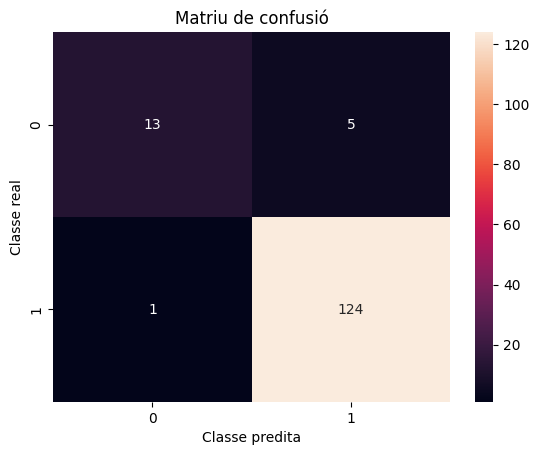

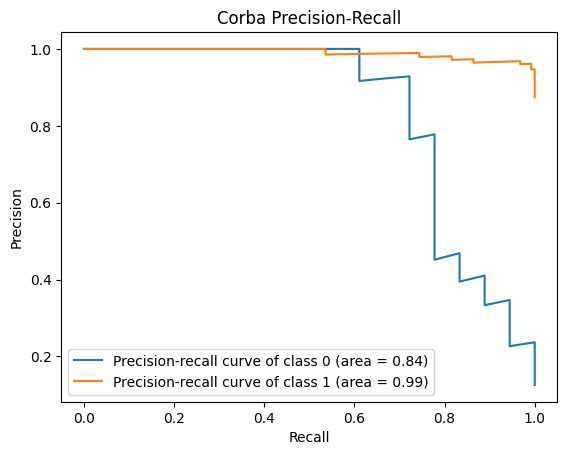

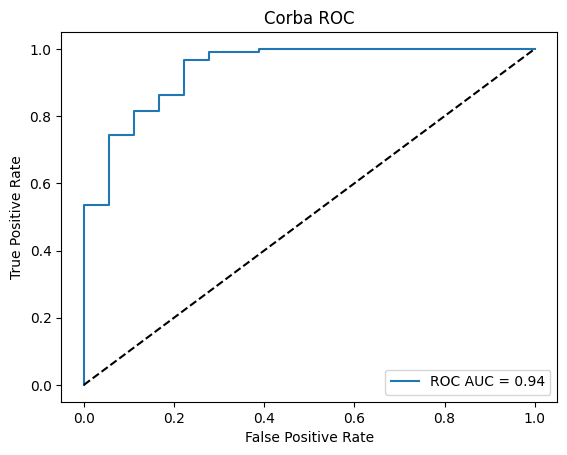

In [247]:
evaluate_model(best_model, x_scaled, y, folds)

### SVR

#### Single-layer FA

In [248]:
x = df0.drop(columns=["mstype", "edss"])
y = df0["edss"]

In [249]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     16.404345   19.934244   16.880274    6.925231   14.868683   27.237312   
1     14.564263   17.414928   15.134213    5.905397   12.780386   25.289463   
2     14.640516   16.196333   15.413794    6.149666   12.940156   24.447312   
3     14.117944   17.741166   17.888479    6.445422   17.751425   26.187135   
4     13.724987   16.343087   14.283896    6.545274   12.585314   22.759765   
..          ...         ...         ...         ...         ...         ...   
138   16.655485   19.146539   16.700146    7.617889   15.122495   25.956406   
139   15.134368   18.966089   17.424447    7.922187   15.291565   30.148821   
140   16.325812   19.457503   17.617547    6.979297   16.901045   28.585863   
141   14.223149   19.131217   14.883435    6.763010   12.154140   26.442900   
142   17.473569   20.529582   17.007257    6.597956   17.569032   27.068842   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     18.612786   23.729318   21.594440   17.103820  ...     0.404505   
1     17.176270   23.635124   20.064056   15.310251  ...     0.390676   
2     15.987123   21.234674   18.726902   14.535856  ...     0.362479   
3     18.658421   24.892061   21.659486   18.235656  ...     0.394411   
4     15.292995   20.699393   18.216965   14.939408  ...     0.363037   
..          ...         ...         ...         ...  ...          ...   
138   16.590008   23.546366   20.671853   19.548557  ...     0.399674   
139   19.847248   22.669545   24.042802   16.325941  ...     0.411943   
140   19.822967   25.647492   23.739913   18.541144  ...     0.425353   
141   15.966015   21.184424   19.354855   18.554706  ...     0.395527   
142   19.064165   26.884717   22.827824   18.531157  ...     0.425194   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.368982     0.361477     0.370647     0.372325     0.368709   
1       0.350216     0.346396     0.361291     0.357996     0.347928   
2       0.321137     0.323869     0.336609     0.335159     0.321751   
3       0.362457     0.366912     0.369140     0.364528     0.365627   
4       0.324367     0.328578     0.336544     0.335277     0.327869   
..           ...          ...          ...          ...          ...   
138     0.374968     0.366035     0.369722     0.374695     0.371155   
139     0.374835     0.369715     0.386245     0.384630     0.378543   
140     0.391793     0.381743     0.395079     0.393692     0.389168   
141     0.353635     0.360722     0.365122     0.365420     0.356498   
142     0.381919     0.381989     0.395951     0.394887     0.384462   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.376409     0.394584     0.444697     0.375068  
1       0.357892     0.380326     0.444446     0.358053  
2       0.331129     0.353703     0.396242     0.331454  
3       0.365138     0.386367     0.439351     0.366825  
4       0.324115     0.350394     0.407564     0.332249  
..           ...          ...          ...          ...  
138     0.375221     0.392292     0.451109     0.377678  
139     0.378105     0.405994     0.462343     0.380065  
140     0.392857     0.423258     0.477610     0.394553  
141     0.359573     0.382538     0.440241     0.366621  
142     0.386017     0.410103     0.459256     0.390308  

[143 rows x 228 columns]

In [250]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [251]:
model = svm.SVR()

folds = KFold(n_splits=5,shuffle=True,random_state=1)

In [252]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: -1.326783106776641
Best Hyperparameters: {'C': 10, 'degree': 2, 'epsilon': 0.3, 'gamma': 0.01, 'kernel': 'rbf'}


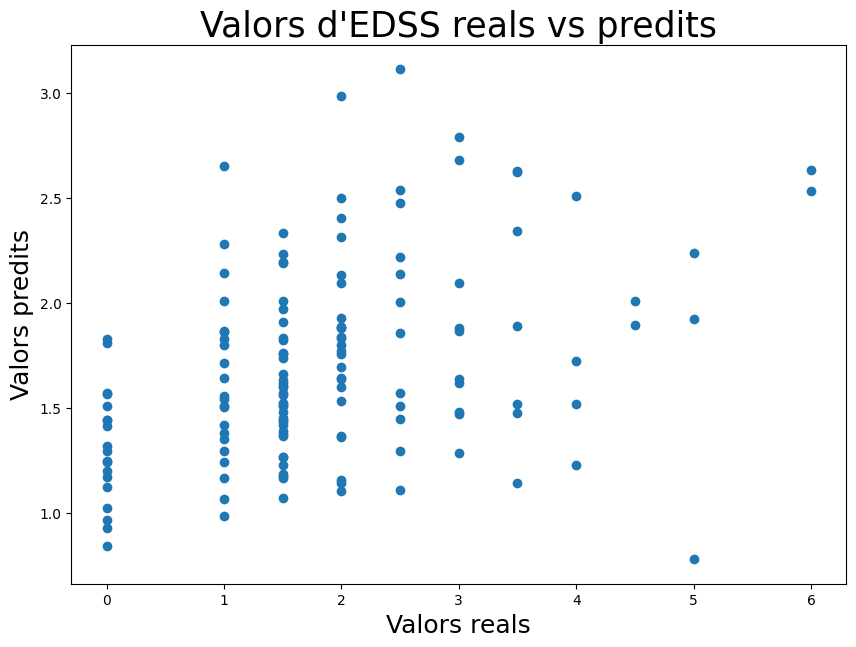

In [253]:
preds = cross_val_predict(best_model, x_scaled, y, cv=folds)

plt.figure(figsize=(10,7))
plt.title("Valors d'EDSS reals vs predits",fontsize=25)
plt.xlabel("Valors reals",fontsize=18)
plt.ylabel("Valors predits", fontsize=18)
plt.scatter(x=y,y=preds)

#### Multilayer estàndar

In [254]:
x = df1.drop(columns=["mstype", "edss"])
y = df1["edss"]

In [255]:
x_aux = x[STRENGTH_COLS+DEGREE_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     60.529405   69.378024   53.034299   37.775491   55.286493   80.007689   
1     60.377519   70.035300   47.401603   29.757332   41.984186   85.500512   
2     45.492595   57.800087   48.847820   37.088257   39.745758   75.855531   
3     48.016134   60.627154   56.706096   29.853317   62.177411   74.583873   
4     55.826084   66.073892   48.352602   36.703653   57.397551   78.772301   
..          ...         ...         ...         ...         ...         ...   
138   49.106890   56.347892   54.122550   31.622556   55.863777   73.401377   
139   46.453662   61.994366   51.950492   40.058479   56.371708   82.817353   
140   62.282425   71.640226   58.903008   36.322777   50.753535   93.443879   
141   59.343661   70.267884   56.277826   33.731075   63.004345   87.291414   
142   54.015524   71.268138   60.506873   38.234905   59.307604   85.930816   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     63.214293   69.931481   73.516474   55.101006  ...     0.000073   
1     68.040950   71.353002   68.335315   60.210242  ...     0.000075   
2     50.843964   61.741032   65.078458   52.528691  ...     0.000065   
3     62.011536   70.183489   71.444263   56.435708  ...     0.000071   
4     65.785631   58.429581   73.712537   60.136246  ...     0.000078   
..          ...         ...         ...         ...  ...          ...   
138   59.107137   68.994738   65.042204   56.328789  ...     0.000071   
139   66.312657   68.390095   76.489680   53.428971  ...     0.000075   
140   59.548881   73.294128   71.919462   63.858976  ...     0.000078   
141   68.824512   56.039196   77.315394   55.478863  ...     0.000077   
142   63.636849   70.460936   77.006325   61.958757  ...     0.000074   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.000073     0.000074     0.000073     0.000073     0.000073   
1       0.000075     0.000076     0.000075     0.000075     0.000075   
2       0.000065     0.000066     0.000066     0.000065     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000078     0.000079     0.000079     0.000078     0.000078   
141     0.000077     0.000078     0.000077     0.000077     0.000077   
142     0.000074     0.000075     0.000075     0.000074     0.000074   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000073     0.000073     0.000073     0.000073  
1       0.000075     0.000075     0.000076     0.000075  
2       0.000066     0.000066     0.000066     0.000066  
3       0.000071     0.000071     0.000071     0.000071  
4       0.000078     0.000078     0.000078     0.000078  
..           ...          ...          ...          ...  
138     0.000071     0.000071     0.000072     0.000071  
139     0.000075     0.000075     0.000075     0.000075  
140     0.000078     0.000079     0.000079     0.000078  
141     0.000077     0.000077     0.000078     0.000078  
142     0.000075     0.000075     0.000075     0.000075  

[143 rows x 228 columns]

In [256]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [257]:
model = svm.SVR()

folds = KFold(n_splits=5,shuffle=True,random_state=1)

In [258]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: -1.242507857033821
Best Hyperparameters: {'C': 10, 'degree': 2, 'epsilon': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}


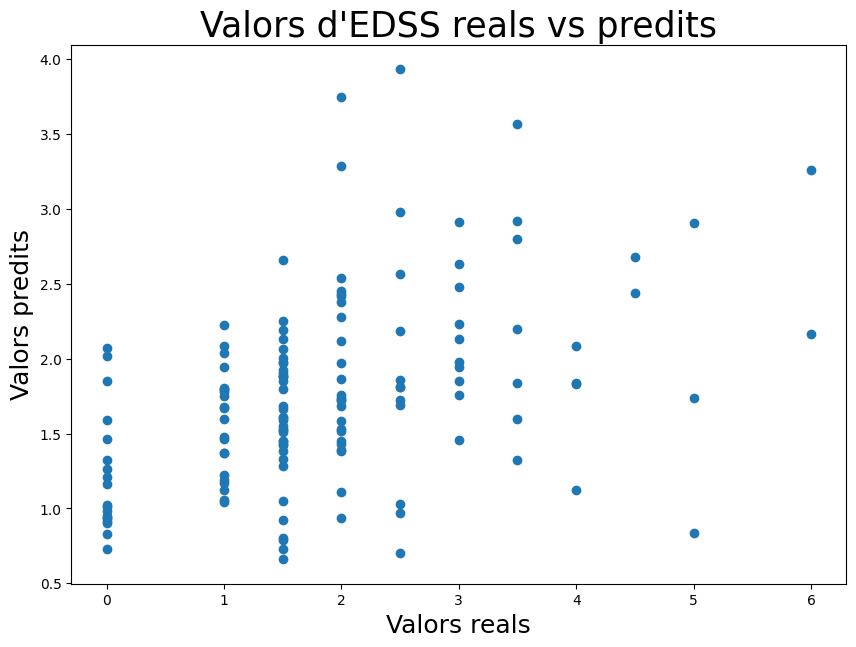

In [259]:
preds = cross_val_predict(best_model, x_scaled, y, cv=folds)

plt.figure(figsize=(10,7))
plt.title("Valors d'EDSS reals vs predits",fontsize=25)
plt.xlabel("Valors reals",fontsize=18)
plt.ylabel("Valors predits", fontsize=18)
plt.scatter(x=y,y=preds)

#### Multilayer amb thresholds

In [260]:
x = df2.drop(columns=["mstype", "edss"])
y = df2["edss"]

In [261]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     59.546602   68.333008   52.062053   36.739089   54.399312   79.505457   
1     59.342370   69.089420   46.414456   28.759438   41.218641   85.061355   
2     44.482329   56.744913   47.792154   36.080874   38.740484   75.261471   
3     46.960781   59.721461   55.798446   28.772582   61.328655   74.071169   
4     54.790684   65.087871   47.325377   35.609662   56.441072   78.020789   
..          ...         ...         ...         ...         ...         ...   
138   48.050861   55.402142   53.238721   30.622538   55.201940   72.899173   
139   45.391052   61.082332   51.016888   39.196244   55.434633   82.234660   
140   61.280921   70.667780   57.908244   35.386812   49.842565   92.770859   
141   58.335901   69.351670   55.355230   32.585370   62.220438   86.858121   
142   52.966774   70.356110   59.456978   37.312291   58.239141   85.348509   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     62.886745   68.902278   73.267825   54.372685  ...     0.000073   
1     67.663033   70.354827   67.883736   59.382047  ...     0.000075   
2     50.185999   60.596573   64.768141   51.507843  ...     0.000065   
3     61.505285   69.114256   70.977930   55.426774  ...     0.000071   
4     65.359995   57.327700   73.273259   59.177871  ...     0.000078   
..          ...         ...         ...         ...  ...          ...   
138   58.730404   67.882382   64.668107   55.426587  ...     0.000071   
139   65.822946   67.285455   75.975785   52.644798  ...     0.000075   
140   58.987973   72.287588   71.549908   63.019200  ...     0.000078   
141   68.393011   55.036246   77.030050   54.511331  ...     0.000077   
142   63.064644   69.417201   76.548589   60.935065  ...     0.000074   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.000073     0.000074     0.000073     0.000073     0.000073   
1       0.000075     0.000076     0.000075     0.000075     0.000075   
2       0.000065     0.000066     0.000066     0.000065     0.000066   
3       0.000071     0.000071     0.000071     0.000071     0.000071   
4       0.000078     0.000078     0.000078     0.000078     0.000078   
..           ...          ...          ...          ...          ...   
138     0.000071     0.000071     0.000071     0.000071     0.000071   
139     0.000075     0.000075     0.000075     0.000075     0.000075   
140     0.000078     0.000079     0.000079     0.000078     0.000078   
141     0.000077     0.000078     0.000077     0.000077     0.000077   
142     0.000074     0.000075     0.000075     0.000074     0.000074   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.000073     0.000073     0.000073     0.000073  
1       0.000075     0.000075     0.000076     0.000075  
2       0.000066     0.000066     0.000066     0.000066  
3       0.000071     0.000071     0.000071     0.000071  
4       0.000078     0.000078     0.000078     0.000078  
..           ...          ...          ...          ...  
138     0.000071     0.000071     0.000072     0.000071  
139     0.000075     0.000075     0.000075     0.000075  
140     0.000078     0.000079     0.000079     0.000078  
141     0.000077     0.000077     0.000078     0.000078  
142     0.000075     0.000075     0.000075     0.000075  

[143 rows x 228 columns]

In [262]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [263]:
model = svm.SVR()

folds = KFold(n_splits=5,shuffle=True,random_state=1)

In [264]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: -1.3769055750809307
Best Hyperparameters: {'C': 10, 'degree': 2, 'epsilon': 0.3, 'gamma': 0.01, 'kernel': 'rbf'}


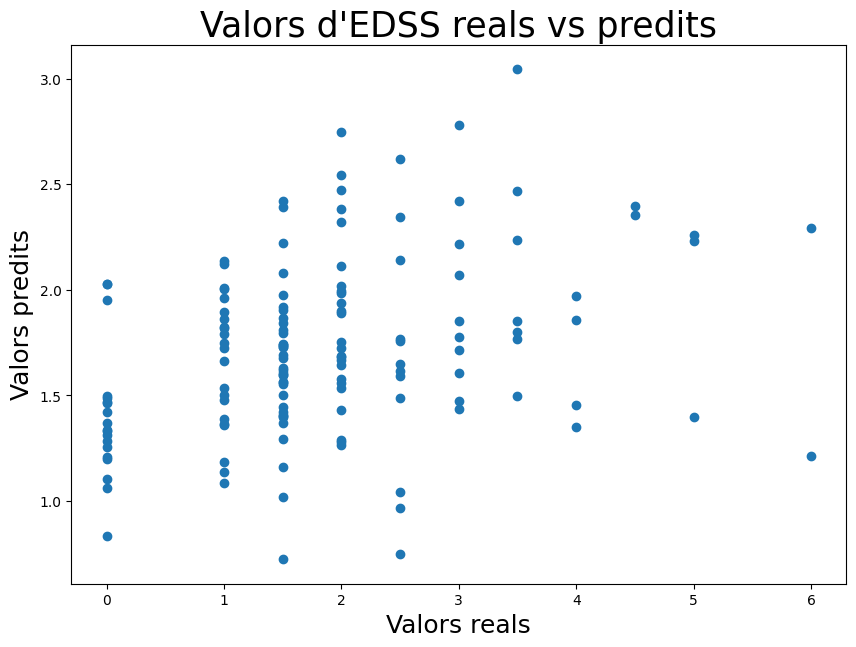

In [265]:
preds = cross_val_predict(best_model, x_scaled, y, cv=folds)

plt.figure(figsize=(10,7))
plt.title("Valors d'EDSS reals vs predits",fontsize=25)
plt.xlabel("Valors reals",fontsize=18)
plt.ylabel("Valors predits", fontsize=18)
plt.scatter(x=y,y=preds)

#### Multilayer amb selecció d'arestes

In [266]:
x = df3.drop(columns=["mstype", "edss"])
y = df3["edss"]

In [267]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+CLUSTERING_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     20.994261   30.925471   24.331761    8.739466   15.426781   37.435479   
1     18.270499   28.252429   22.606156    7.017927   14.494215   37.187900   
2     19.185853   26.076601   23.106392    7.604893   13.965619   35.914693   
3     17.555392   27.724236   25.222265    8.141513   15.087189   36.136272   
4     18.061197   26.082460   21.388118    7.251541   14.419552   35.168434   
..          ...         ...         ...         ...         ...         ...   
138   20.626668   29.667578   25.452363    8.424795   16.317481   39.603689   
139   20.497556   29.607237   26.984561    8.808661   16.040173   40.387879   
140   21.848286   30.719663   26.697613    8.892110   16.544635   41.333551   
141   21.749789   30.565550   25.656699    7.596144   15.226042   38.552321   
142   21.957683   30.847532   27.245140    7.531913   16.383752   40.530886   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Clustering_66  \
0     24.132352   34.258167   31.690560   17.391322  ...       0.262686   
1     23.561520   34.653134   29.398500   15.727913  ...       0.259152   
2     22.675379   29.258655   27.461576   14.902771  ...       0.231151   
3     24.221430   34.364947   30.330865   17.211736  ...       0.246136   
4     22.926240   30.256283   28.163724   15.991734  ...       0.233838   
..          ...         ...         ...         ...  ...            ...   
138   25.071249   33.661879   33.760792   16.843842  ...       0.257027   
139   26.671820   35.782592   33.584656   17.321250  ...       0.260511   
140   26.495133   37.485694   34.310312   17.655675  ...       0.273885   
141   26.637520   33.415602   31.809572   17.170038  ...       0.258600   
142   26.713970   36.072178   33.610254   17.960635  ...       0.274906   

     Clustering_67  Clustering_68  Clustering_69  Clustering_70  \
0         0.228612       0.180449       0.184191       0.225981   
1         0.217801       0.172728       0.172225       0.225102   
2         0.204306       0.177683       0.164646       0.207126   
3         0.218830       0.166751       0.170944       0.208105   
4         0.206379       0.175266       0.167263       0.212348   
..             ...            ...            ...            ...   
138       0.235204       0.199069       0.172068       0.216878   
139       0.241631       0.191053       0.188079       0.220715   
140       0.240977       0.196357       0.185042       0.239115   
141       0.230021       0.200203       0.180050       0.226098   
142       0.246114       0.193993       0.190883       0.243752   

     Clustering_71  Clustering_72  Clustering_73  Clustering_74  Clustering_75  
0         0.235822       0.225125       0.229932       0.283444       0.244066  
1         0.225663       0.223304       0.219951       0.276597       0.230390  
2         0.207851       0.198928       0.199322       0.270727       0.216008  
3         0.225049       0.220563       0.206981       0.269224       0.232298  
4         0.208362       0.206946       0.196351       0.254061       0.217717  
..             ...            ...            ...            ...            ...  
138       0.238301       0.214904       0.222357       0.270879       0.231433  
139       0.245768       0.226934       0.229259       0.301581       0.251032  
140       0.250848       0.240701       0.234888       0.299663       0.257560  
141       0.237616       0.215016       0.223589       0.276849       0.235403  
142       0.249174       0.237190       0.236223       0.299742       0.254543  

[143 rows x 228 columns]

In [268]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [269]:
model = svm.SVR()

folds = KFold(n_splits=5,shuffle=True,random_state=1)

In [270]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: -1.116425662885281
Best Hyperparameters: {'C': 10, 'degree': 2, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


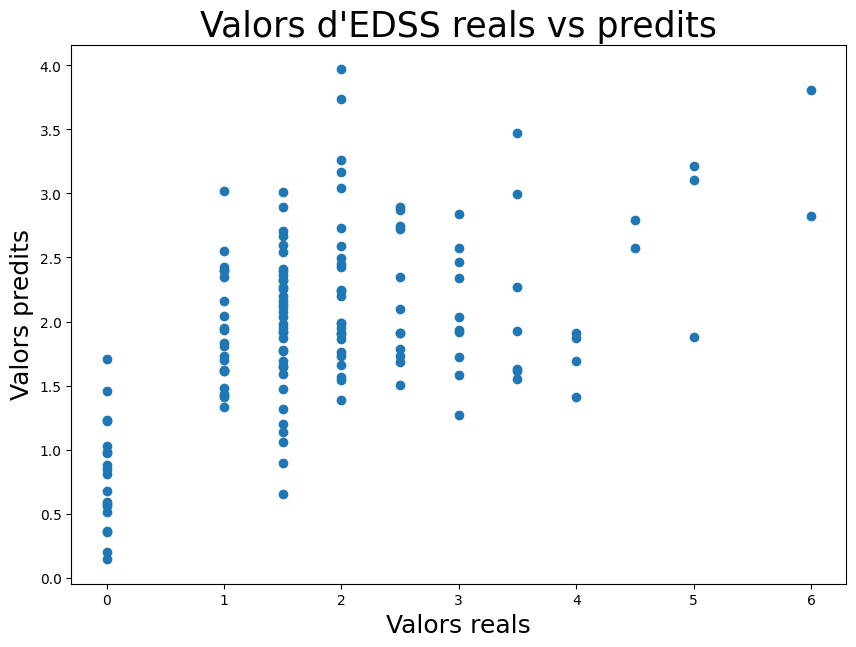

In [271]:
preds = cross_val_predict(best_model, x_scaled, y, cv=folds)

plt.figure(figsize=(10,7))
plt.title("Valors d'EDSS reals vs predits",fontsize=25)
plt.xlabel("Valors reals",fontsize=18)
plt.ylabel("Valors predits", fontsize=18)
plt.scatter(x=y,y=preds)

#### Single-layer FA amb selecció d'arestes

In [272]:
x = df4.drop(columns=["mstype", "edss"])
y = df4["edss"]

In [273]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+LOCAL_EF_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0     10.480743   13.752801   11.985441    3.904961    7.319794   18.231549   
1      9.125421   12.224827   11.237358    3.135864    6.928494   17.358168   
2      9.485210   11.516828   11.480320    3.268007    6.716047   16.971244   
3      8.653527   12.395658   12.526438    3.878158    7.311625   17.678257   
4      8.975146   11.711132   10.632412    3.428517    6.764899   16.547216   
..          ...         ...         ...         ...         ...         ...   
138   10.210400   13.607235   12.625968    3.847231    7.684441   19.197031   
139   10.224815   13.303207   13.329064    3.720480    7.579796   19.590702   
140   10.683068   13.607567   13.262706    3.932663    7.957666   19.842491   
141   10.646996   13.581947   12.437514    3.654525    7.073533   18.396108   
142   10.902477   13.853444   13.395842    3.559879    7.694182   19.687285   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Local_ef_66  \
0     11.152640   16.120626   15.554824    7.492134  ...     0.366174   
1     10.467688   16.112620   14.499703    6.747417  ...     0.357558   
2     10.307904   13.695429   13.569751    6.450834  ...     0.331607   
3     10.845597   16.008630   14.798309    7.716483  ...     0.351730   
4      9.980599   14.377907   13.730734    6.752295  ...     0.329242   
..          ...         ...         ...         ...  ...          ...   
138   10.971642   15.416932   16.285140    7.730024  ...     0.369414   
139   11.606020   16.257541   16.286737    7.869841  ...     0.369844   
140   11.961815   17.120877   16.688269    7.955804  ...     0.386842   
141   11.355159   15.741295   15.360904    7.712926  ...     0.370444   
142   11.936675   17.012043   16.103322    8.184430  ...     0.391857   

     Local_ef_67  Local_ef_68  Local_ef_69  Local_ef_70  Local_ef_71  \
0       0.347571     0.351386     0.313295     0.329664     0.349992   
1       0.332547     0.329169     0.299250     0.318856     0.334491   
2       0.305925     0.313836     0.282130     0.300120     0.308587   
3       0.338291     0.340875     0.304576     0.314246     0.340844   
4       0.310620     0.313607     0.285811     0.304329     0.313900   
..           ...          ...          ...          ...          ...   
138     0.355628     0.353957     0.313542     0.333481     0.357247   
139     0.354110     0.361299     0.322057     0.333878     0.356393   
140     0.366502     0.374723     0.330124     0.347692     0.369005   
141     0.341450     0.361039     0.314365     0.330653     0.345169   
142     0.361646     0.379568     0.336064     0.356525     0.365260   

     Local_ef_72  Local_ef_73  Local_ef_74  Local_ef_75  
0       0.350801     0.368719     0.407565     0.350977  
1       0.334007     0.353251     0.406351     0.337033  
2       0.305261     0.326794     0.369318     0.307262  
3       0.339021     0.357157     0.397584     0.338548  
4       0.313439     0.328739     0.386930     0.311634  
..           ...          ...          ...          ...  
138     0.358730     0.373808     0.404694     0.356552  
139     0.356464     0.374923     0.416272     0.353249  
140     0.368466     0.394220     0.436364     0.368807  
141     0.345252     0.365292     0.403384     0.348461  
142     0.364548     0.387621     0.436751     0.367066  

[143 rows x 228 columns]

In [274]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [275]:
model = svm.SVR()

folds = KFold(n_splits=5,shuffle=True,random_state=1)

In [276]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: -1.2446542983997797
Best Hyperparameters: {'C': 10, 'degree': 2, 'epsilon': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}


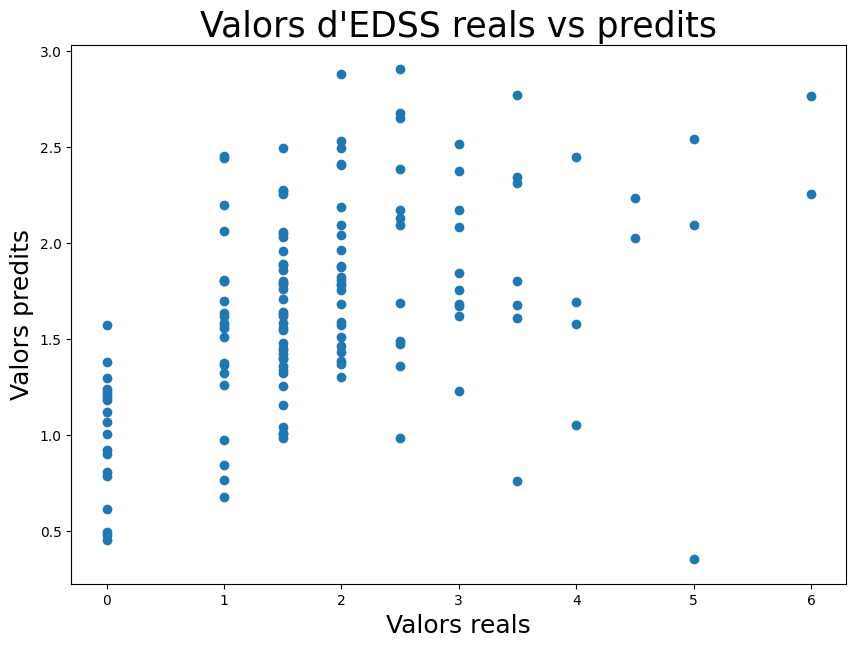

In [277]:
preds = cross_val_predict(best_model, x_scaled, y, cv=folds)

plt.figure(figsize=(10,7))
plt.title("Valors d'EDSS reals vs predits",fontsize=25)
plt.xlabel("Valors reals",fontsize=18)
plt.ylabel("Valors predits", fontsize=18)
plt.scatter(x=y,y=preds)

#### Single-layer GM amb selecció d'arestes

In [278]:
x = df5.drop(columns=["mstype", "edss"])
y = df5["edss"]

In [279]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+CLUSTERING_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.019841    1.071230         0.0    0.043774    0.393293         0.0   
1      0.015682    1.076074         0.0    0.031175    0.422697         0.0   
2      0.015422    1.028716         0.0    0.028904    0.333530         0.0   
3      0.007920    0.906835         0.0    0.032805    0.353425         0.0   
4      0.011251    1.006105         0.0    0.034587    0.316551         0.0   
..          ...         ...         ...         ...         ...         ...   
138    0.017122    0.984011         0.0    0.030689    0.398288         0.0   
139    0.010652    0.973974         0.0    0.028148    0.350019         0.0   
140    0.017408    0.697690         0.0    0.029155    0.342529         0.0   
141    0.013695    0.864393         0.0    0.039029    0.406192         0.0   
142    0.015928    0.820201         0.0    0.026055    0.298889         0.0   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  Clustering_66  \
0      0.976328         0.0         0.0    1.239833  ...       0.083486   
1      0.898748         0.0         0.0    1.109160  ...       0.068276   
2      0.739178         0.0         0.0    0.945089  ...       0.065730   
3      0.660863         0.0         0.0    0.908107  ...       0.058862   
4      0.788985         0.0         0.0    0.919306  ...       0.056216   
..          ...         ...         ...         ...  ...            ...   
138    0.755185         0.0         0.0    1.013880  ...       0.069489   
139    0.754866         0.0         0.0    1.102764  ...       0.065926   
140    0.706787         0.0         0.0    1.038116  ...       0.062573   
141    0.836240         0.0         0.0    0.977471  ...       0.067376   
142    0.698201         0.0         0.0    0.944805  ...       0.065011   

     Clustering_67  Clustering_68  Clustering_69  Clustering_70  \
0         0.070566            0.0       0.059594       0.135568   
1         0.055492            0.0       0.057652       0.123749   
2         0.053382            0.0       0.044706       0.115181   
3         0.047957            0.0       0.042918       0.108509   
4         0.049614            0.0       0.047279       0.116206   
..             ...            ...            ...            ...   
138       0.055327            0.0       0.050338       0.117306   
139       0.051680            0.0       0.048582       0.117729   
140       0.055000            0.0       0.047052       0.118089   
141       0.052543            0.0       0.048614       0.121923   
142       0.052996            0.0       0.045162       0.115108   

     Clustering_71  Clustering_72  Clustering_73  Clustering_74  Clustering_75  
0         0.091444            0.0       0.071189            0.0            0.0  
1         0.081555            0.0       0.060951            0.0            0.0  
2         0.066697            0.0       0.055460            0.0            0.0  
3         0.072637            0.0       0.049369            0.0            0.0  
4         0.065147            0.0       0.052240            0.0            0.0  
..             ...            ...            ...            ...            ...  
138       0.077534            0.0       0.057444            0.0            0.0  
139       0.069740            0.0       0.056912            0.0            0.0  
140       0.067493            0.0       0.054687            0.0            0.0  
141       0.073416            0.0       0.054568            0.0            0.0  
142       0.066985            0.0       0.054895            0.0            0.0  

[143 rows x 228 columns]

In [280]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [281]:
model = svm.SVR()

folds = KFold(n_splits=5,shuffle=True,random_state=1)

In [282]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: -1.3877703644799948
Best Hyperparameters: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}


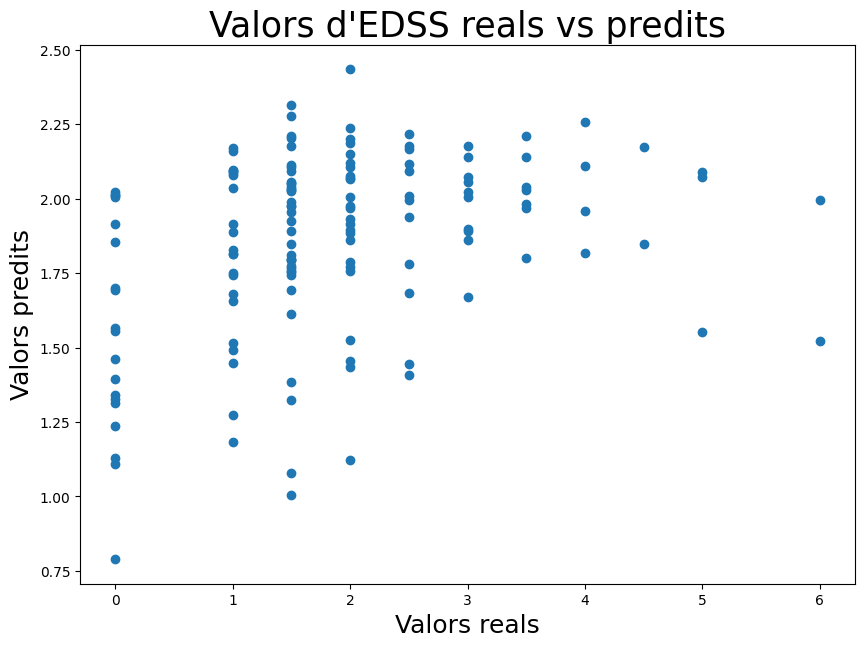

In [283]:
preds = cross_val_predict(best_model, x_scaled, y, cv=folds)

plt.figure(figsize=(10,7))
plt.title("Valors d'EDSS reals vs predits",fontsize=25)
plt.xlabel("Valors reals",fontsize=18)
plt.ylabel("Valors predits", fontsize=18)
plt.scatter(x=y,y=preds)

#### Single-layer RS amb selecció d'arestes

In [284]:
x = df6.drop(columns=["mstype", "edss"])
y = df6["edss"]

In [285]:
x_aux = x[STRENGTH_COLS+CLOSENESS_COLS+PAGERANK_COLS]
x_aux

Strength_0  Strength_1  Strength_2  Strength_3  Strength_4  Strength_5  \
0      0.012933    2.348639    0.360878    0.885770    0.393900    0.972382   
1      0.003975    2.726700    0.131439    0.715023    0.214531    2.471565   
2      0.200010    2.014228    0.145752    1.039974    0.199996    1.972205   
3      0.240419    2.026085    0.169388    0.352393    0.110515    0.779757   
4      0.099655    1.654091    0.123295    0.359920    0.573203    2.074003   
..          ...         ...         ...         ...         ...         ...   
138    0.188746    1.469097    0.200427    0.699645    0.550311    1.209628   
139    0.037275    2.026848    0.326434    1.339552    0.530562    1.206475   
140    0.464743    2.806839    0.172201    0.997629    0.286775    1.648569   
141    0.442102    2.537264    0.781671    0.248065    0.672784    1.760105   
142    0.136801    2.320443    0.453455    0.386100    0.696499    1.156316   

     Strength_6  Strength_7  Strength_8  Strength_9  ...  PageRank_66  \
0      0.850745    2.016915    0.580912    1.167222  ...     0.006402   
1      1.727396    2.427895    0.399093    1.123919  ...     0.003877   
2      1.320393    1.867797    0.322074    1.056015  ...     0.004905   
3      1.869373    2.347688    0.734247    0.870663  ...     0.006321   
4      2.176057    1.500469    0.702256    1.567838  ...     0.005223   
..          ...         ...         ...         ...  ...          ...   
138    2.372779    2.828015    1.190513    0.369914  ...     0.004922   
139    2.704915    3.267510    1.011183    0.478804  ...     0.005382   
140    1.864716    3.243940    0.933774    0.705951  ...     0.004961   
141    3.090962    1.933011    1.087764    0.766715  ...     0.004234   
142    2.142419    2.048093    1.403611    0.646971  ...     0.004606   

     PageRank_67  PageRank_68  PageRank_69  PageRank_70  PageRank_71  \
0       0.014768     0.026944     0.008085     0.020295     0.009106   
1       0.019577     0.025937     0.008551     0.031543     0.011196   
2       0.018388     0.031642     0.006761     0.024040     0.008698   
3       0.017041     0.025287     0.008743     0.014122     0.011529   
4       0.019119     0.027658     0.008928     0.026854     0.012373   
..           ...          ...          ...          ...          ...   
138     0.017999     0.030845     0.005832     0.011046     0.011435   
139     0.018653     0.021125     0.011495     0.010977     0.015774   
140     0.007595     0.017017     0.006266     0.015531     0.009561   
141     0.012361     0.024288     0.008606     0.012797     0.015988   
142     0.021745     0.016703     0.008260     0.021609     0.014372   

     PageRank_72  PageRank_73  PageRank_74  PageRank_75  
0       0.019598     0.028763     0.010534     0.012781  
1       0.019856     0.024428     0.008399     0.006993  
2       0.019589     0.025282     0.013026     0.013268  
3       0.019500     0.020761     0.006936     0.010105  
4       0.014928     0.019864     0.005827     0.004953  
..           ...          ...          ...          ...  
138     0.010947     0.020965     0.010720     0.010848  
139     0.010264     0.030599     0.012942     0.014140  
140     0.009824     0.024539     0.009272     0.011215  
141     0.006745     0.022353     0.008924     0.004173  
142     0.012561     0.028525     0.007384     0.008753  

[143 rows x 228 columns]

In [286]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_aux)

In [287]:
model = svm.SVR()

folds = KFold(n_splits=5,shuffle=True,random_state=1)

In [288]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'degree': [2, 3, 4, 5],
    'epsilon': [0.1, 0.2, 0.3, 0.5]
}

search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=folds)
result = search.fit(x_scaled,y)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)
best_model = search.best_estimator_

Best Score: -1.2978519564163544
Best Hyperparameters: {'C': 1000, 'degree': 4, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'poly'}


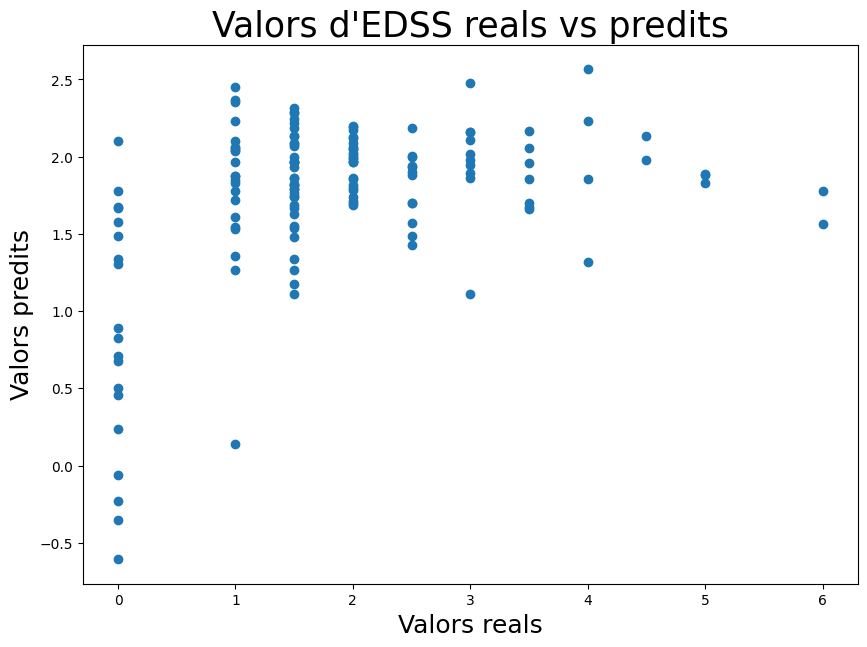

In [289]:
preds = cross_val_predict(best_model, x_scaled, y, cv=folds)

plt.figure(figsize=(10,7))
plt.title("Valors d'EDSS reals vs predits",fontsize=25)
plt.xlabel("Valors reals",fontsize=18)
plt.ylabel("Valors predits", fontsize=18)
plt.scatter(x=y,y=preds)